# Random Forest (Supervised) Time Series Analysis

This section treats the envisaged dataset as a time series problem. Proposed techniques / methodology here is to:
* Combine all 3 matrices into a agglomorated matrix of 61 + 162 + 1179 features (1402). Duplicate columns ('SNAP_ID') will be reduced to a single one.
* Perform normalization on the data.
* Time Shift the provided datasets with varied 'lag' values.
* Perform Feature Selction on the dataset by selecting and retaining 1/4 of the total features. (Multivariate analysis - through a Random Forest Ensemble Elimination approach)
* Perform Feature Decomposition on the dataset by decomposing those selected features into a smaller number of components
* Slicing agglomorated matrix into Features/Labels.
* Splitting of train/validation/test set. This is split into 50/50 partitions, where in each half is estimated to total the average workload of an entire week (7 days).
* Feed dataset into a number of machine learning models (RandomForest).

A Many to Many approach is opted for in this experiment. The following experiment is trained on a number (greater than 1) of past sequences (t-lag), and all used to train and later predict a number of (t+lag) sequences.

Applicable links:
* https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/
* https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
* https://machinelearningmastery.com/crash-course-recurrent-neural-networks-deep-learning/
* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
* https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
* https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

### Module Installation and Importing Libraries

* https://machinelearningmastery.com/setup-python-environment-machine-learning-deep-learning-anaconda/
* https://vertexai-plaidml.readthedocs-hosted.com/en/latest/installing.html

In [32]:
# scipy
import scipy as sc
print('scipy: %s' % sc.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
# pandas
import pandas as pd
from pandas.plotting import lag_plot
print('pandas: %s' % pd.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
import sklearn as sk
print('sklearn: %s' % sk.__version__)
# math
import math
import csv
import os.path
import time

scipy: 1.1.0
numpy: 1.15.4
pandas: 0.23.4
statsmodels: 0.9.0
sklearn: 0.20.2


### Configuration Cell

Tweak parametric changes from this cell to influence outcome of experiment. 
NB: This experiment demonstrates at time  step = 1 (1 minute in advance). Further down in experiment, other timestep results are also featured and evaluated.

In [33]:
# Experiment Config
tpcds='TPCDS10' # Schema upon which to operate test
lag=12 # Time Series shift / Lag Step. Each lag value equates to 1 minute. Cannot be less than 1
if lag < 1:
    raise ValueError('Lag value must be greater than 1!')
bin_value = 2
if bin_value < 2:
    raise ValueError('Number of buckets must be greater than 1')
nrows=None
test_split=.5 # Denotes which Data Split to operate under when it comes to training / validation
sub_sample_start=350 # Denotes frist 0..n samples (Used for plotting purposes)
y_label = ['CPU_TIME_DELTA','IOWAIT_DELTA'] # Denotes which label to use for time series experiments

# Forest Config
parallel_degree = 2
max_features=None
max_depth=None
n_estimators=100

### Read data from file into Pandas Dataframes

In [34]:
# Root path
#root_dir = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds
root_dir = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds

# Open Data
rep_hist_snapshot_path = root_dir + '/rep_hist_snapshot.csv'
rep_hist_sysmetric_summary_path = root_dir + '/rep_hist_sysmetric_summary.csv'
rep_hist_sysstat_path = root_dir + '/rep_hist_sysstat.csv'

rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path, nrows=nrows)
rep_hist_sysmetric_summary_df = pd.read_csv(rep_hist_sysmetric_summary_path, nrows=nrows)
rep_hist_sysstat_df = pd.read_csv(rep_hist_sysstat_path, nrows=nrows)

def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list

rep_hist_snapshot_df.columns = prettify_header(rep_hist_snapshot_df.columns.values)
rep_hist_sysmetric_summary_df.columns = prettify_header(rep_hist_sysmetric_summary_df.columns.values)
rep_hist_sysstat_df.columns = prettify_header(rep_hist_sysstat_df.columns.values)

print(rep_hist_snapshot_df.columns.values)
print(rep_hist_sysmetric_summary_df.columns.values)
print(rep_hist_sysstat_df.columns.values)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['SNAP_ID' 'DBID' 'INSTANCE_NUMBER' 'SQL_ID' 'PLAN_HASH_VALUE'
 'OPTIMIZER_COST' 'OPTIMIZER_MODE' 'OPTIMIZER_ENV_HASH_VALUE'
 'SHARABLE_MEM' 'LOADED_VERSIONS' 'VERSION_COUNT' 'MODULE' 'ACTION'
 'SQL_PROFILE' 'FORCE_MATCHING_SIGNATURE' 'PARSING_SCHEMA_ID'
 'PARSING_SCHEMA_NAME' 'PARSING_USER_ID' 'FETCHES_TOTAL' 'FETCHES_DELTA'
 'END_OF_FETCH_COUNT_TOTAL' 'END_OF_FETCH_COUNT_DELTA' 'SORTS_TOTAL'
 'SORTS_DELTA' 'EXECUTIONS_TOTAL' 'EXECUTIONS_DELTA'
 'PX_SERVERS_EXECS_TOTAL' 'PX_SERVERS_EXECS_DELTA' 'LOADS_TOTAL'
 'LOADS_DELTA' 'INVALIDATIONS_TOTAL' 'INVALIDATIONS_DELTA'
 'PARSE_CALLS_TOTAL' 'PARSE_CALLS_DELTA' 'DISK_READS_TOTAL'
 'DISK_READS_DELTA' 'BUFFER_GETS_TOTAL' 'BUFFER_GETS_DELTA'
 'ROWS_PROCESSED_TOTAL' 'ROWS_PROCESSED_DELTA' 'CPU_TIME_TOTAL'
 'CPU_TIME_DELTA' 'ELAPSED_TIME_TOTAL' 'ELAPSED_TIME_DELTA' 'IOWAIT_TOTAL'
 'IOWAIT_DELTA' 'CLWAIT_TOTAL' 'CLWAIT_DELTA' 'APWAIT_TOTAL'
 'APWAIT_DELTA' 'CCWAIT_TOTAL' 'CCWAIT_DELTA' 'DIRECT_WRITES_TOTAL'
 'DIRECT_WRITES_DELTA' 'PLSEXEC_TIME_T

### Pivoting Tables and Changing Matrix Shapes

Changes all dataframe shapes to be similar to each other, where in a number of snap_id timestamps are cojoined with instance metrics.

In [35]:
print('Header Lengths [Before Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))

# Table REP_HIST_SYSMETRIC_SUMMARY
rep_hist_sysmetric_summary_df = rep_hist_sysmetric_summary_df.pivot_table(index='SNAP_ID', columns='METRIC_NAME', values='AVERAGE')
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
rep_hist_sysmetric_summary_df[['SNAP_ID']] = rep_hist_sysmetric_summary_df[['SNAP_ID']].astype(int)
#rep_hist_sysmetric_summary_df = rep_hist_sysstat_df.groupby(['SNAP_ID']).sum()
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
rep_hist_sysmetric_summary_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)

# Table REP_HIST_SYSSTAT
rep_hist_sysstat_df = rep_hist_sysstat_df.pivot_table(index='SNAP_ID', columns='STAT_NAME', values='VALUE')
rep_hist_sysstat_df.reset_index(inplace=True)
rep_hist_sysstat_df[['SNAP_ID']] = rep_hist_sysstat_df[['SNAP_ID']].astype(int)
#rep_hist_sysstat_df = rep_hist_sysstat_df.groupby(['SNAP_ID']).sum()
rep_hist_sysstat_df.reset_index(inplace=True)
rep_hist_sysstat_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)

rep_hist_sysmetric_summary_df.rename(str.upper, inplace=True, axis='columns')
rep_hist_sysstat_df.rename(str.upper, inplace=True, axis='columns')

# Group By Values by SNAP_ID , sum all metrics (for table REP_HIST_SNAPSHOT)
rep_hist_snapshot_df = rep_hist_snapshot_df.groupby(['SNAP_ID','DBID','INSTANCE_NUMBER']).sum()
rep_hist_snapshot_df.reset_index(inplace=True)

print('\nHeader Lengths [After Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))

# DF Shape
print('\nDataframe shapes:\nTable [REP_HIST_SNAPSHOT] - ' + str(rep_hist_snapshot_df.shape))
print('Table [REP_HIST_SYSMETRIC_SUMMARY] - ' + str(rep_hist_sysmetric_summary_df.shape))
print('Table [REP_HIST_SYSSTAT] - ' + str(rep_hist_sysstat_df.shape))

Header Lengths [Before Pivot]
REP_HIST_SNAPSHOT: 90
REP_HIST_SYSMETRIC_SUMMARY: 26
REP_HIST_SYSSTAT: 16

Header Lengths [After Pivot]
REP_HIST_SNAPSHOT: 77
REP_HIST_SYSMETRIC_SUMMARY: 163
REP_HIST_SYSSTAT: 1180

Dataframe shapes:
Table [REP_HIST_SNAPSHOT] - (12308, 77)
Table [REP_HIST_SYSMETRIC_SUMMARY] - (12323, 163)
Table [REP_HIST_SYSSTAT] - (12107, 1180)


### Dealing with Empty Values

In [36]:
def get_na_columns(df, headers):
    """
    Return columns which consist of NAN values
    """
    na_list = []
    for head in headers:
        if df[head].isnull().values.any():
            na_list.append(head)
    return na_list

print('N/A Columns\n')
print('\n REP_HIST_SNAPSHOT Features ' + str(len(rep_hist_snapshot_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_df.columns)) + "\n")
print('REP_HIST_SYSMETRIC_SUMMARY Features ' + str(len(rep_hist_sysmetric_summary_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_sysmetric_summary_df,headers=rep_hist_sysmetric_summary_df.columns)) + "\n")
print('REP_HIST_SYSSTAT Features ' + str(len(rep_hist_sysstat_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_sysstat_df,headers=rep_hist_sysstat_df.columns)) + "\n")

def fill_na(df):
    """
    Replaces NA columns with 0s
    """
    return df.fillna(0)

# Populating NaN values with amount '0'
rep_hist_snapshot_df = fill_na(df=rep_hist_snapshot_df)
rep_hist_sysmetric_summary_df = fill_na(df=rep_hist_sysmetric_summary_df)
rep_hist_sysstat_df = fill_na(df=rep_hist_sysstat_df)

N/A Columns


 REP_HIST_SNAPSHOT Features 77: []

REP_HIST_SYSMETRIC_SUMMARY Features 163: ['VM OUT BYTES PER SEC']

REP_HIST_SYSSTAT Features 1180: ['BA SPARE STATISTIC 12', 'BA SPARE STATISTIC 9', 'CLI FLSTASK CREATE', 'CLUSTERWIDE GLOBAL TRANSACTIONS', 'DDL STATEMENTS PARALLELIZED', 'EHCC COMPRESSED LENGTH COMPRESSED', 'EFFECTIVE IO TIME', 'FORWARDED 2PC COMMANDS ACROSS RAC NODES', 'IM POPULATE (FASTSTART) CUS READ ATTEMPTS', 'IM POPULATE CUS MEMCOMPRESS FOR CAPACITY LOW', 'IM REPOPULATE (TRICKLE) CUS MEMCOMPRESS FOR QUERY LOW', 'IM REPOPULATE (TRICKLE) CUS REQUESTED', 'IM REPOPULATE CUS NO MEMCOMPRESS', 'IM SCAN ROWS JOURNAL', 'IM SCAN ROWS PROJECTED', 'IM SPACE SMU BYTES ALLOCATED', 'IM SPACE SMU CREATIONS COMMITTED', 'IM SPACE PRIVATE JOURNAL EXTENTS ALLOCATED', 'IPC CPU USED BY THIS SESSION', 'PARALLEL OPERATIONS DOWNGRADED TO SERIAL', 'WORKLOAD REPLAY: THINK TIME', 'BACKUP DATA COMPRESSED REMOTELY', 'CALLS TO KCMGRS', 'CELL CUS SENT UNCOMPRESSED', 'CONSISTENT GETS', 'DATA WAREH

### Merging Frames

This part merges the following pandas data frame into a single frame:
* REP_HIST_SNAPSHOT
* REP_HIST_SYSMETRIC_SUMMARY
* REP_HIST_SYSSTAT

In [37]:
df = pd.merge(rep_hist_snapshot_df, rep_hist_sysmetric_summary_df,how='inner',on ='SNAP_ID')
df = pd.merge(df, rep_hist_sysstat_df,how='inner',on ='SNAP_ID')
print(df.shape)
print('----------------------------------')
print(df.columns.tolist())

(12019, 1418)
----------------------------------
['SNAP_ID', 'DBID', 'INSTANCE_NUMBER', 'PLAN_HASH_VALUE', 'OPTIMIZER_COST', 'OPTIMIZER_ENV_HASH_VALUE', 'SHARABLE_MEM', 'LOADED_VERSIONS', 'VERSION_COUNT', 'SQL_PROFILE', 'PARSING_SCHEMA_ID', 'PARSING_USER_ID', 'FETCHES_TOTAL', 'FETCHES_DELTA', 'END_OF_FETCH_COUNT_TOTAL', 'END_OF_FETCH_COUNT_DELTA', 'SORTS_TOTAL', 'SORTS_DELTA', 'EXECUTIONS_TOTAL', 'EXECUTIONS_DELTA', 'PX_SERVERS_EXECS_TOTAL', 'PX_SERVERS_EXECS_DELTA', 'LOADS_TOTAL', 'LOADS_DELTA', 'INVALIDATIONS_TOTAL', 'INVALIDATIONS_DELTA', 'PARSE_CALLS_TOTAL', 'PARSE_CALLS_DELTA', 'DISK_READS_TOTAL', 'DISK_READS_DELTA', 'BUFFER_GETS_TOTAL', 'BUFFER_GETS_DELTA', 'ROWS_PROCESSED_TOTAL', 'ROWS_PROCESSED_DELTA', 'CPU_TIME_TOTAL', 'CPU_TIME_DELTA', 'ELAPSED_TIME_TOTAL', 'ELAPSED_TIME_DELTA', 'IOWAIT_TOTAL', 'IOWAIT_DELTA', 'CLWAIT_TOTAL', 'CLWAIT_DELTA', 'APWAIT_TOTAL', 'APWAIT_DELTA', 'CCWAIT_TOTAL', 'CCWAIT_DELTA', 'DIRECT_WRITES_TOTAL', 'DIRECT_WRITES_DELTA', 'PLSEXEC_TIME_TOTAL', 'PLS

### Data Ordering

Sorting of datasets in order of SNAP_ID.

In [38]:
df.sort_values(by=['SNAP_ID'], ascending=True, inplace=True)
print(df.shape)

(12019, 1418)


### Floating point precision conversion

Each column is converted into a column of type values which are floating point for higher precision.

In [39]:
df.astype('float32', inplace=True)
df = np.round(df, 3) # rounds to 3 dp
print(df.shape)

(12019, 1418)


### Redundant Feature Removal
In this step, redundant features are dropped. Features are considered redundant if exhibit a standard devaition of 0 (meaning no change in value).

In [40]:
def drop_flatline_columns(df):
    columns = df.columns
    flatline_features = []
    for i in range(len(columns)):
        try:
            std = df[columns[i]].std()
            if std == 0:
                flatline_features.append(columns[i])
        except:
            pass
    #
    #print('Features which are considered flatline:\n')
    #for col in flatline_features:
    #    print(col)
    print('\nShape before changes: [' + str(df.shape) + ']')
    df = df.drop(columns=flatline_features)
    print('Shape after changes: [' + str(df.shape) + ']')
    print('Dropped a total [' + str(len(flatline_features)) + ']')
    return df
#
print('Before column drop:')
print(df.shape)
df = drop_flatline_columns(df=df)
print('\nAfter flatline column drop:')
print(df.shape)
dropped_columns_df = [ 'PLAN_HASH_VALUE',
                       'OPTIMIZER_ENV_HASH_VALUE',
                       'LOADED_VERSIONS',
                       'VERSION_COUNT',
                       'PARSING_SCHEMA_ID',
                       'PARSING_USER_ID',
                       'CON_DBID',
                       'SNAP_LEVEL',
                       'SNAP_FLAG',
                       'COMMAND_TYPE']
df.drop(columns=dropped_columns_df, inplace=True)
print('\nAfter additional column drop:')
print(df.shape)

Before column drop:
(12019, 1418)

Shape before changes: [(12019, 1418)]
Shape after changes: [(12019, 536)]
Dropped a total [882]

After flatline column drop:
(12019, 536)

After additional column drop:
(12019, 526)


## Visualizing Labels

https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

### Histograms

A simple and commonly used plot to quickly check the distribution of a sample of data is the histogram.

In the histogram, the data is divided into a pre-specified number of groups called bins. The data is then sorted into each bin and the count of the number of observations in each bin is retained.

The plot shows the bins across the x-axis maintaining their ordinal relationship, and the count in each bin on the y-axis.

A sample of data has a Gaussian distribution of the histogram plot, showing the familiar bell shape.

### Quantile-Quantile Plot

Another popular plot for checking the distribution of a data sample is the quantile-quantile plot, Q-Q plot, or QQ plot for short.

This plot generates its own sample of the idealized distribution that we are comparing with, in this case the Gaussian distribution. The idealized samples are divided into groups (e.g. 5), called quantiles. Each data point in the sample is paired with a similar member from the idealized distribution at the same cumulative distribution.

The resulting points are plotted as a scatter plot with the idealized value on the x-axis and the data sample on the y-axis.

A perfect match for the distribution will be shown by a line of dots on a 45-degree angle from the bottom left of the plot to the top right. Often a line is drawn on the plot to help make this expectation clear. Deviations by the dots from the line shows a deviation from the expected distribution.

### Shapiro-Wilk Test

The Shapiro-Wilk test evaluates a data sample and quantifies how likely it is that the data was drawn from a Gaussian distribution, named for Samuel Shapiro and Martin Wilk.

In practice, the Shapiro-Wilk test is believed to be a reliable test of normality, although there is some suggestion that the test may be suitable for smaller samples of data, e.g. thousands of observations or fewer.

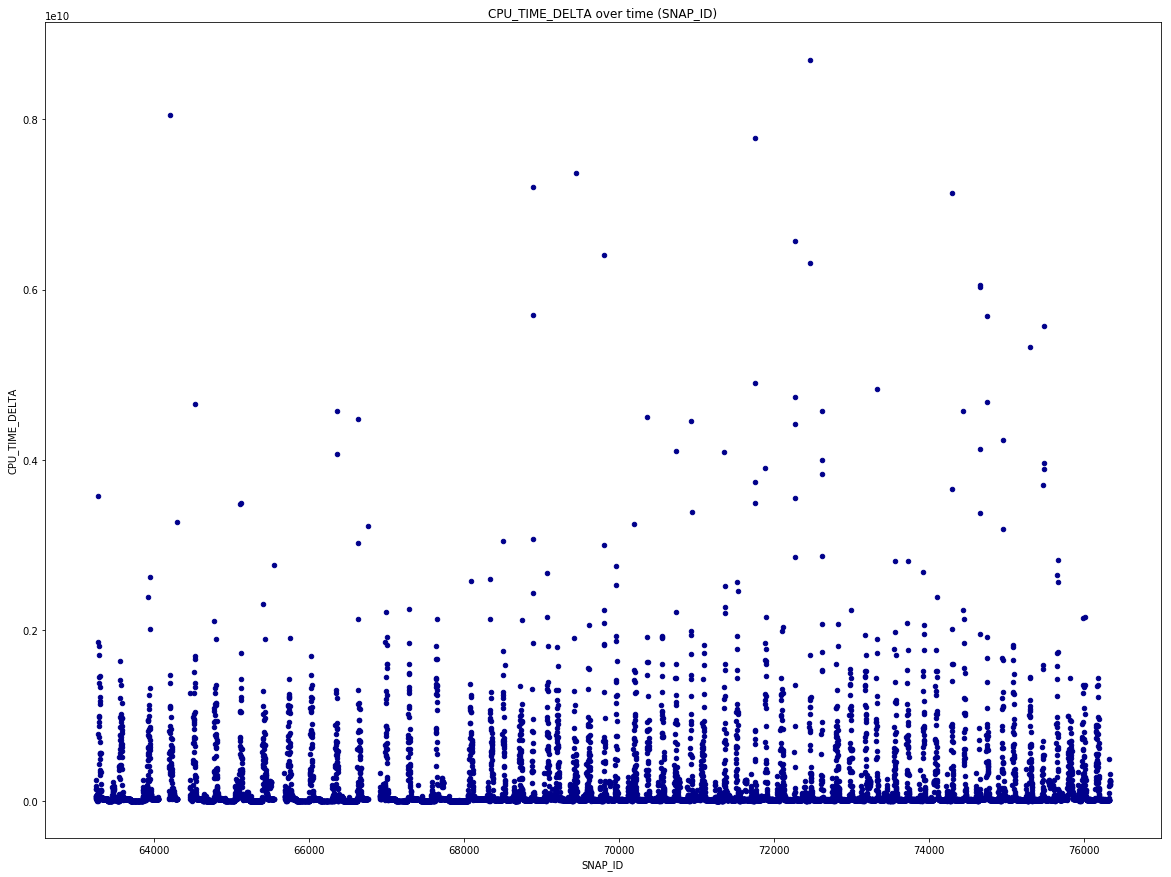

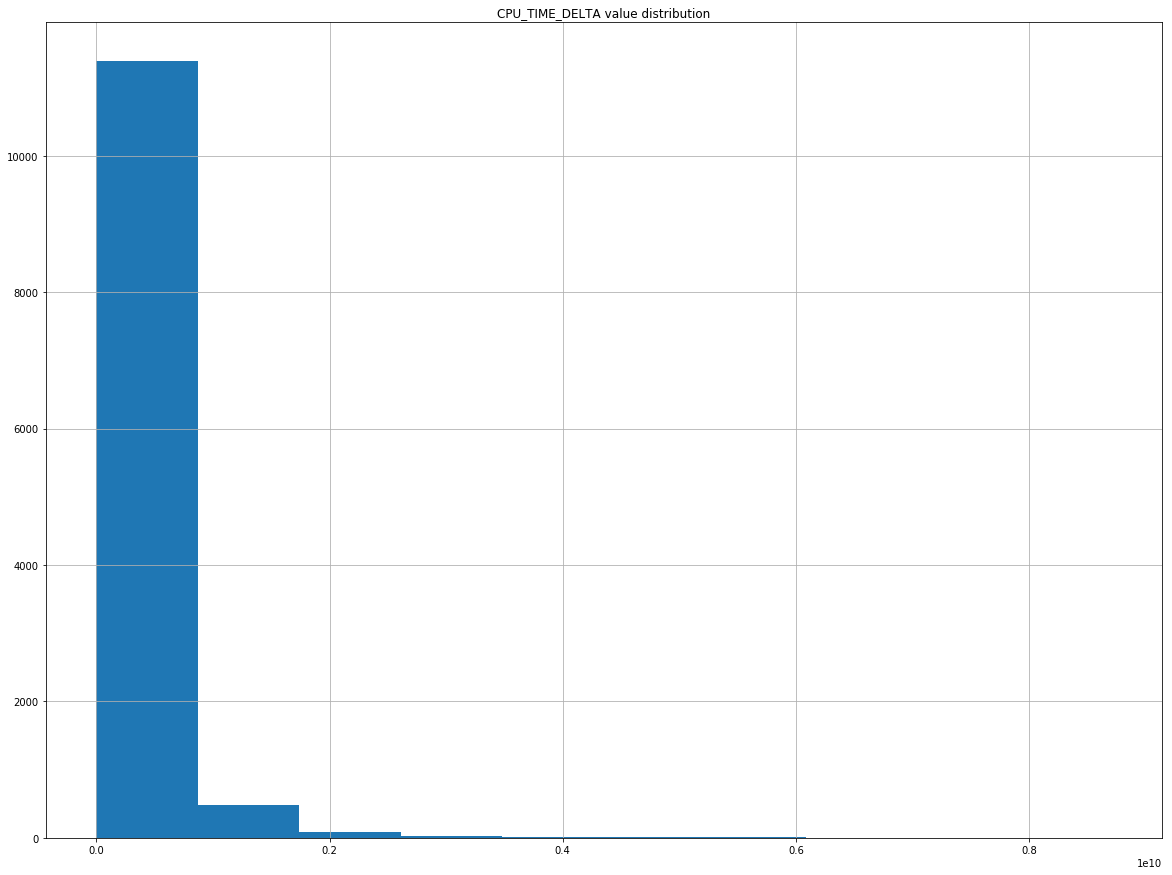

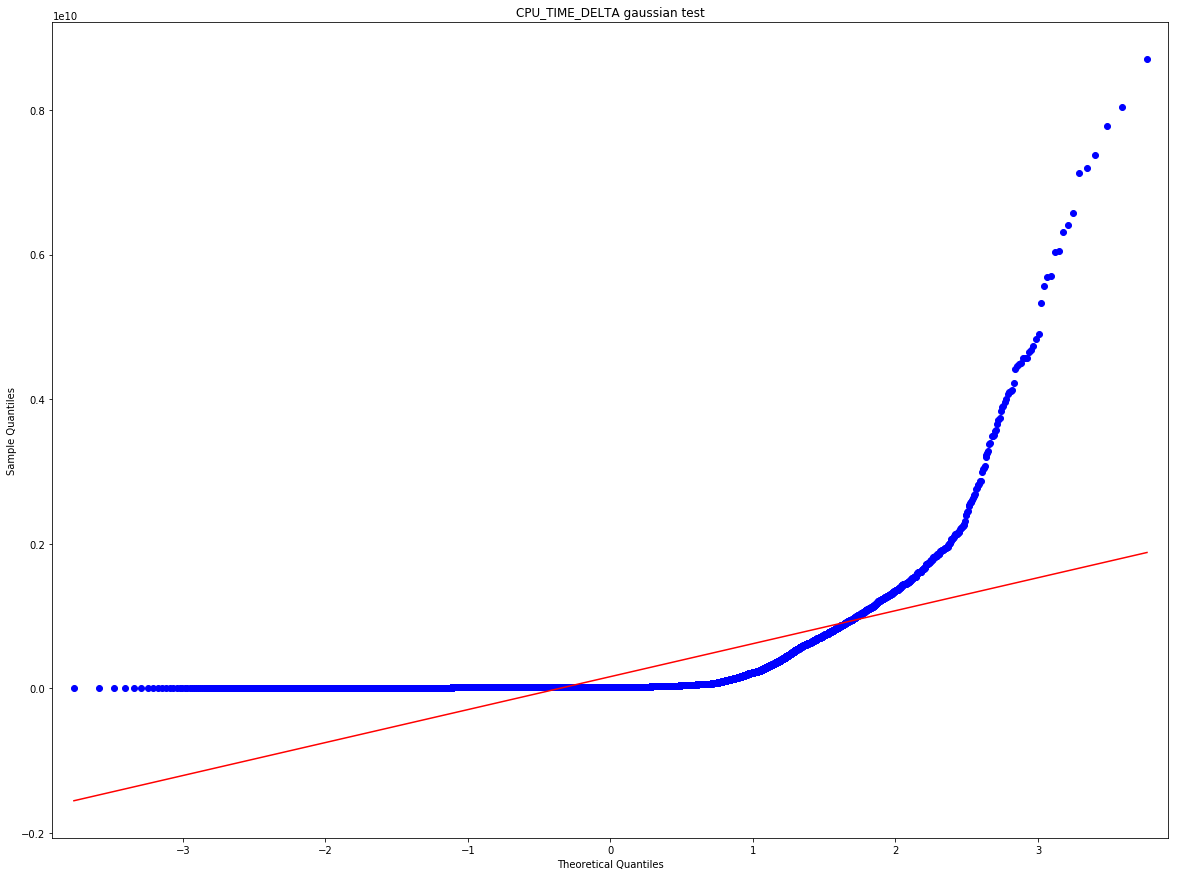

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistics=0.360, p=0.000
Sample does not look Gaussian (reject H0)


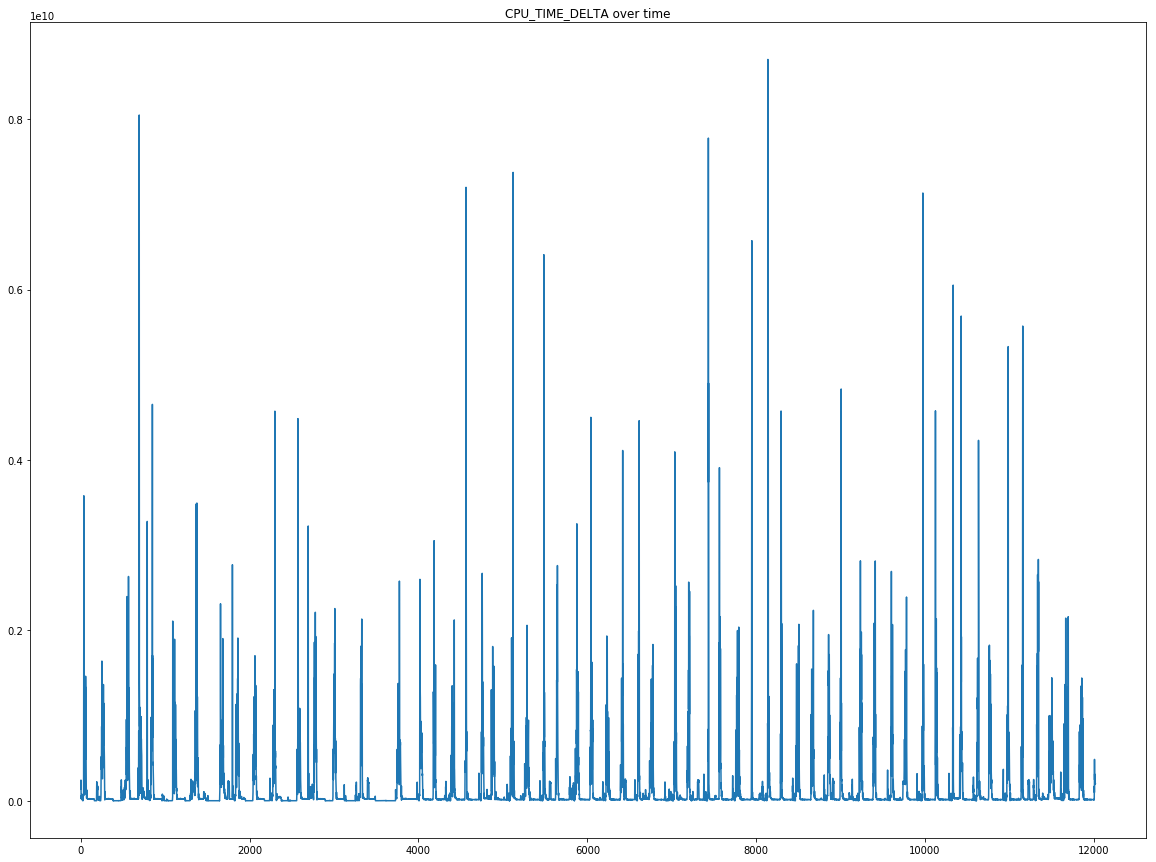

---------------------------------------------------------------


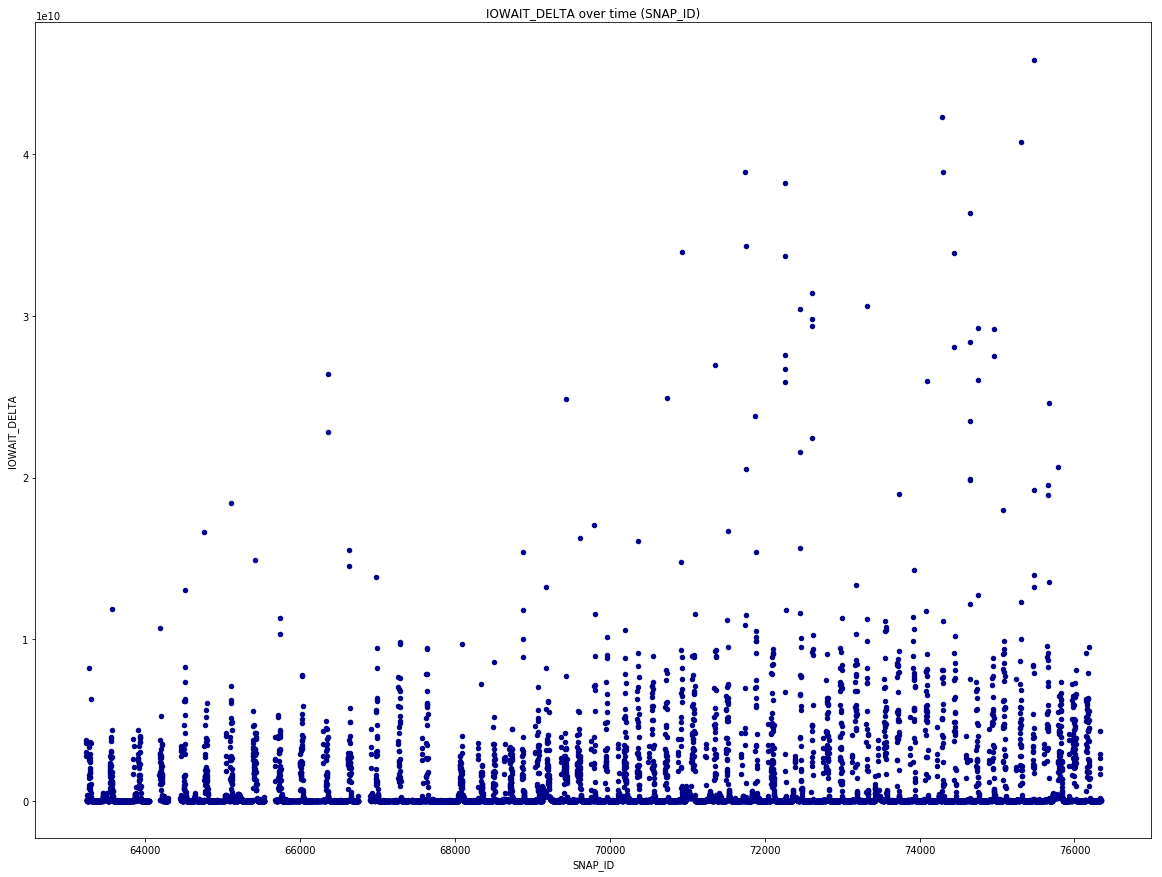

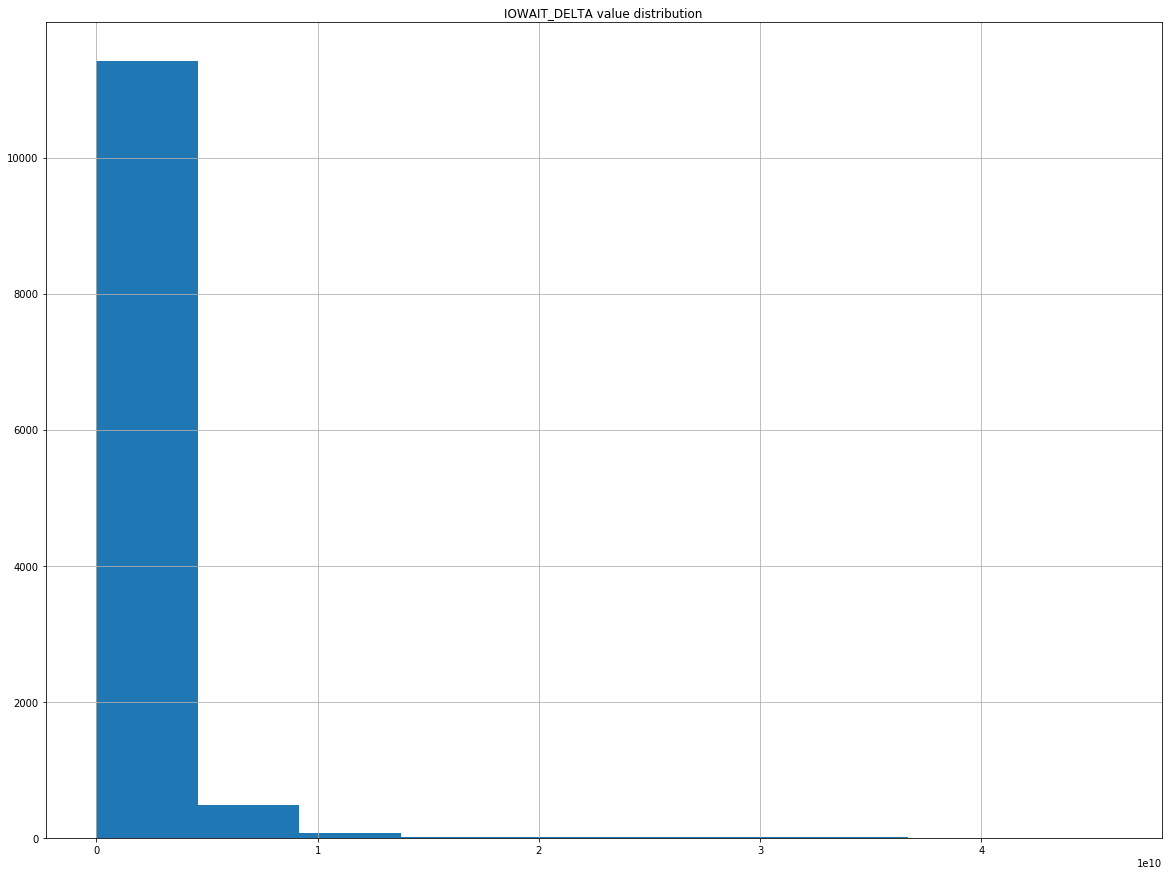

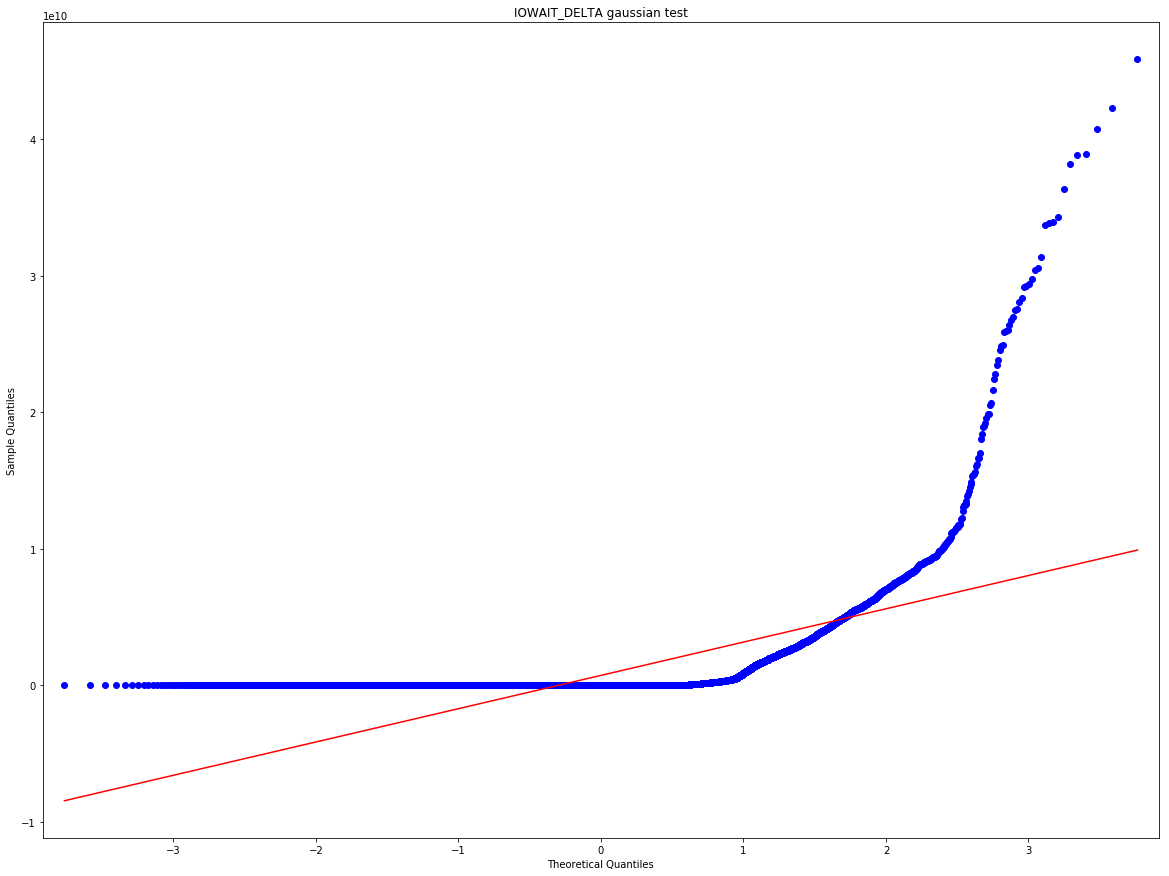

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistics=0.326, p=0.000
Sample does not look Gaussian (reject H0)


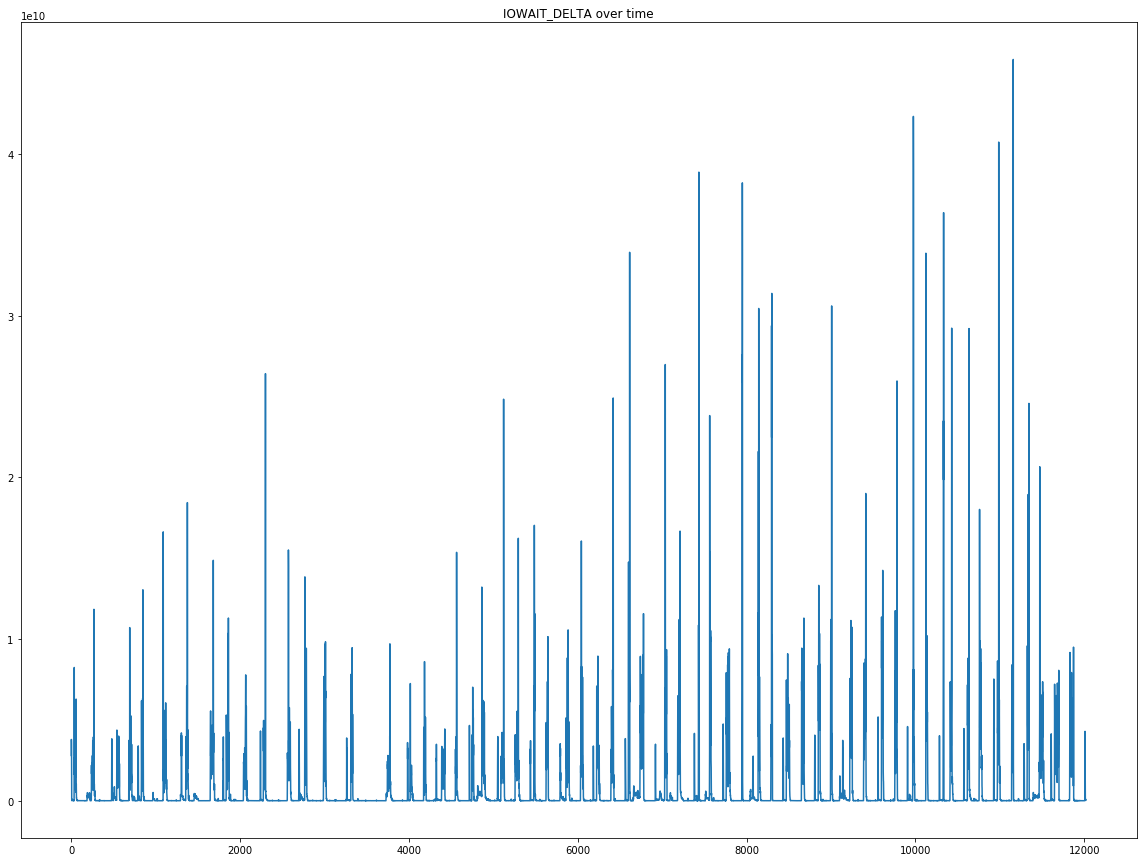

---------------------------------------------------------------


In [41]:
def shapiro_wilk(data):
    # normality test
    stat, p = sc.stats.shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

for label in y_label:
    
    df.plot.scatter(x='SNAP_ID',
                    y=label,
                    c='DarkBlue')
    plt.title(label + " over time (SNAP_ID)")
    plt.show()
    
    df[label].hist(bins=10)
    plt.title(label + ' value distribution')
    plt.show()
    
    qqplot(df[label], line='s')
    plt.title(label + ' gaussian test')
    plt.show()
    
    shapiro_wilk(data=df[label])
    
    df[label].plot.line()
    plt.title(label + ' over time')
    plt.show()
    print('---------------------------------------------------------------')

### Outlier Detection - Standard Deviation Method

Detection and transformation of outliers, categorized as more than 3 standard deviations away.

If we know that the distribution of values in the sample is Gaussian or Gaussian-like, we can use the standard deviation of the sample as a cut-off for identifying outliers.

The Gaussian distribution has the property that the standard deviation from the mean can be used to reliably summarize the percentage of values in the sample.

For example, within one standard deviation of the mean will cover 68% of the data.

So, if the mean is 50 and the standard deviation is 5, as in the test dataset above, then all data in the sample between 45 and 55 will account for about 68% of the data sample. We can cover more of the data sample if we expand the range as follows:

* 1 Standard Deviation from the Mean: 68%
* 2 Standard Deviations from the Mean: 95%
* 3 Standard Deviations from the Mean: 99.7%

A value that falls outside of 3 standard deviations is part of the distribution, but it is an unlikely or rare event at approximately 1 in 370 samples.

Three standard deviations from the mean is a common cut-off in practice for identifying outliers in a Gaussian or Gaussian-like distribution. For smaller samples of data, perhaps a value of 2 standard deviations (95%) can be used, and for larger samples, perhaps a value of 4 standard deviations (99.9%) can be used.

More infor here: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

In [42]:
def get_outliers_std(df=None, headers=None):
    """
    Detect and return which rows are considered outliers within the dataset, determined by :quartile_limit (99%)
    """
    outlier_rows = [] # This list of lists consists of elements of the following notation [column,rowid]
    for header in headers:
        outlier_count = 0
        try:
            # calculate summary statistics
            data_mean, data_std = df[header].mean(), df[header].std()
            # identify outliers
            cut_off = data_std * 3
            lower, upper = data_mean - cut_off, data_mean + cut_off
            
            series_row = (df[df[header] > upper].index)
            outlier_count += len(list(np.array(series_row)))
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
            
            series_row = (df[df[header] < lower].index)
            outlier_count += len(list(np.array(series_row)))
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
            print(header + ' - [' + str(outlier_count) + '] outliers')
        except Exception as e:
            print(str(e))
    
    unique_outlier_rows = []
    for col, rowid in outlier_rows:
        unique_outlier_rows.append([col,rowid])
    return unique_outlier_rows

#Printing outliers to screen
outliers = get_outliers_std(df=df,
                            headers=y_label)
print('Total Outliers: [' + str(len(outliers)) + ']\n')
for label in y_label:
    min_val = df[label].min()
    max_val = df[label].max()
    mean_val = df[label].mean()
    std_val = df[label].std()
    print('Label[' + label + '] - Min[' + str(min_val) + '] - Max[' + str(max_val) + '] - Mean[' + str(mean_val) + '] - Std[' + str(std_val) + ']')
print('\n---------------------------------------------\n')
for i in range(len(outliers)):
    print('Header [' + str(outliers[i][0]) + '] - Location [' + str(outliers[i][1]) + '] - Value [' + str(df.iloc[outliers[i][1]][outliers[i][0]]) + ']') 

CPU_TIME_DELTA - [201] outliers
IOWAIT_DELTA - [192] outliers
Total Outliers: [393]

Label[CPU_TIME_DELTA] - Min[329477] - Max[8700003444] - Mean[161398913.89217073] - Std[456114349.27022684]
Label[IOWAIT_DELTA] - Min[73670.0] - Max[45852641484.0] - Mean[739431945.1054996] - Std[2438539045.7624965]

---------------------------------------------

Header [CPU_TIME_DELTA] - Location [35] - Value [1860334766.0]
Header [CPU_TIME_DELTA] - Location [36] - Value [3579433459.0]
Header [CPU_TIME_DELTA] - Location [37] - Value [1714481645.0]
Header [CPU_TIME_DELTA] - Location [38] - Value [1813313472.0]
Header [CPU_TIME_DELTA] - Location [250] - Value [1639268256.0]
Header [CPU_TIME_DELTA] - Location [548] - Value [2396388182.0]
Header [CPU_TIME_DELTA] - Location [565] - Value [2632412043.0]
Header [CPU_TIME_DELTA] - Location [566] - Value [2015728318.0]
Header [CPU_TIME_DELTA] - Location [692] - Value [8047880163.0]
Header [CPU_TIME_DELTA] - Location [787] - Value [3278140800.0]
Header [CPU_TIME

Header [CPU_TIME_DELTA] - Location [9602] - Value [2691485405.0]
Header [CPU_TIME_DELTA] - Location [9610] - Value [1956016072.0]
Header [CPU_TIME_DELTA] - Location [9611] - Value [1767933259.0]
Header [CPU_TIME_DELTA] - Location [9615] - Value [2068252405.0]
Header [CPU_TIME_DELTA] - Location [9770] - Value [1774003280.0]
Header [CPU_TIME_DELTA] - Location [9781] - Value [2390984706.0]
Header [CPU_TIME_DELTA] - Location [9975] - Value [7132799279.0]
Header [CPU_TIME_DELTA] - Location [9976] - Value [3658747731.0]
Header [CPU_TIME_DELTA] - Location [9977] - Value [2016109277.0]
Header [CPU_TIME_DELTA] - Location [9978] - Value [1609498772.0]
Header [CPU_TIME_DELTA] - Location [9983] - Value [1601871603.0]
Header [CPU_TIME_DELTA] - Location [10123] - Value [2243705479.0]
Header [CPU_TIME_DELTA] - Location [10124] - Value [4576388180.0]
Header [CPU_TIME_DELTA] - Location [10125] - Value [1851828943.0]
Header [CPU_TIME_DELTA] - Location [10134] - Value [2134890865.0]
Header [CPU_TIME_DELT

Header [IOWAIT_DELTA] - Location [8857] - Value [8682448046.0]
Header [IOWAIT_DELTA] - Location [8863] - Value [10344323902.0]
Header [IOWAIT_DELTA] - Location [8868] - Value [8440835629.0]
Header [IOWAIT_DELTA] - Location [8996] - Value [9887988219.0]
Header [IOWAIT_DELTA] - Location [8997] - Value [8201436246.0]
Header [IOWAIT_DELTA] - Location [9001] - Value [11220703731.0]
Header [IOWAIT_DELTA] - Location [9007] - Value [30606803635.0]
Header [IOWAIT_DELTA] - Location [9233] - Value [8829133378.0]
Header [IOWAIT_DELTA] - Location [9235] - Value [11148522917.0]
Header [IOWAIT_DELTA] - Location [9236] - Value [10496088270.0]
Header [IOWAIT_DELTA] - Location [9248] - Value [10729618577.0]
Header [IOWAIT_DELTA] - Location [9249] - Value [10552109921.0]
Header [IOWAIT_DELTA] - Location [9388] - Value [8515456903.0]
Header [IOWAIT_DELTA] - Location [9390] - Value [8386617402.0]
Header [IOWAIT_DELTA] - Location [9401] - Value [8372584869.0]
Header [IOWAIT_DELTA] - Location [9404] - Value 

### Outlier Detection - Interquartile Range Method

https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

Not all data is normal or normal enough to treat it as being drawn from a Gaussian distribution.

A good statistic for summarizing a non-Gaussian distribution sample of data is the Interquartile Range, or IQR for short.

The IQR is calculated as the difference between the 75th and the 25th percentiles of the data and defines the box in a box and whisker plot.

Remember that percentiles can be calculated by sorting the observations and selecting values at specific indices. The 50th percentile is the middle value, or the average of the two middle values for an even number of examples. If we had 10,000 samples, then the 50th percentile would be the average of the 5000th and 5001st values.

We refer to the percentiles as quartiles (“quart” meaning 4) because the data is divided into four groups via the 25th, 50th and 75th values.

The IQR defines the middle 50% of the data, or the body of the data.

The IQR can be used to identify outliers by defining limits on the sample values that are a factor k of the IQR below the 25th percentile or above the 75th percentile. The common value for the factor k is the value 1.5. A factor k of 3 or more can be used to identify values that are extreme outliers or “far outs” when described in the context of box and whisker plots.

On a box and whisker plot, these limits are drawn as fences on the whiskers (or the lines) that are drawn from the box. Values that fall outside of these values are drawn as dots.

In [43]:
def get_outliers_quartile(df=None, headers=None):
    """
    Detect and return which rows are considered outliers within the dataset, determined by :quartile_limit (99%)
    """
    outlier_rows = [] # This list of lists consists of elements of the following notation [column,rowid]
    for header in headers:
        outlier_count = 0
        try:
            q25, q75 = np.percentile(df[header], 25), np.percentile(df[header], 75)
            iqr = q75 - q25
            cut_off = iqr * .6 # This values needs to remain as it. It was found to be a good value so as to capture the relavent outlier data
            lower, upper = q25 - cut_off, q75 + cut_off
            
            series_row = (df[df[header] > upper].index)
            outlier_count += len(list(np.array(series_row)))
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
            
            series_row = (df[df[header] < lower].index)
            outlier_count += len(list(np.array(series_row)))
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
            print(header + ' - [' + str(outlier_count) + '] outliers')
        except Exception as e:
            print(str(e))
    
    unique_outlier_rows = []
    for col, rowid in outlier_rows:
        unique_outlier_rows.append([col,rowid])
    return unique_outlier_rows

#Printing outliers to screen
outliers = get_outliers_quartile(df=df,
                                 headers=y_label)
print('Total Outliers: [' + str(len(outliers)) + ']\n')
for label in y_label:
    min_val = df[label].min()
    max_val = df[label].max()
    mean_val = df[label].mean()
    std_val = df[label].std()
    print('Label[' + label + '] - Min[' + str(min_val) + '] - Max[' + str(max_val) + '] - Mean[' + str(mean_val) + '] - Std[' + str(std_val) + ']')
print('\n---------------------------------------------\n')
for i in range(len(outliers)):
    print('Header [' + str(outliers[i][0]) + '] - Location [' + str(outliers[i][1]) + '] - Value [' + str(df.iloc[outliers[i][1]][outliers[i][0]]) + ']') 

CPU_TIME_DELTA - [2629] outliers
IOWAIT_DELTA - [2719] outliers
Total Outliers: [5348]

Label[CPU_TIME_DELTA] - Min[329477] - Max[8700003444] - Mean[161398913.89217073] - Std[456114349.27022684]
Label[IOWAIT_DELTA] - Min[73670.0] - Max[45852641484.0] - Mean[739431945.1054996] - Std[2438539045.7624965]

---------------------------------------------

Header [CPU_TIME_DELTA] - Location [0] - Value [174283515.0]
Header [CPU_TIME_DELTA] - Location [1] - Value [136668485.0]
Header [CPU_TIME_DELTA] - Location [2] - Value [242558401.0]
Header [CPU_TIME_DELTA] - Location [3] - Value [137722627.0]
Header [CPU_TIME_DELTA] - Location [34] - Value [788291004.0]
Header [CPU_TIME_DELTA] - Location [35] - Value [1860334766.0]
Header [CPU_TIME_DELTA] - Location [36] - Value [3579433459.0]
Header [CPU_TIME_DELTA] - Location [37] - Value [1714481645.0]
Header [CPU_TIME_DELTA] - Location [38] - Value [1813313472.0]
Header [CPU_TIME_DELTA] - Location [39] - Value [881802332.0]
Header [CPU_TIME_DELTA] - Loc

Header [CPU_TIME_DELTA] - Location [700] - Value [579602676.0]
Header [CPU_TIME_DELTA] - Location [701] - Value [309490261.0]
Header [CPU_TIME_DELTA] - Location [702] - Value [440012279.0]
Header [CPU_TIME_DELTA] - Location [703] - Value [742524289.0]
Header [CPU_TIME_DELTA] - Location [704] - Value [848918088.0]
Header [CPU_TIME_DELTA] - Location [705] - Value [391790414.0]
Header [CPU_TIME_DELTA] - Location [706] - Value [309144648.0]
Header [CPU_TIME_DELTA] - Location [707] - Value [90993914.0]
Header [CPU_TIME_DELTA] - Location [709] - Value [243890615.0]
Header [CPU_TIME_DELTA] - Location [710] - Value [661369711.0]
Header [CPU_TIME_DELTA] - Location [711] - Value [425384810.0]
Header [CPU_TIME_DELTA] - Location [712] - Value [426202779.0]
Header [CPU_TIME_DELTA] - Location [713] - Value [543713678.0]
Header [CPU_TIME_DELTA] - Location [714] - Value [987710863.0]
Header [CPU_TIME_DELTA] - Location [715] - Value [341145513.0]
Header [CPU_TIME_DELTA] - Location [716] - Value [302247

Header [CPU_TIME_DELTA] - Location [1371] - Value [1327015989.0]
Header [CPU_TIME_DELTA] - Location [1372] - Value [1733228681.0]
Header [CPU_TIME_DELTA] - Location [1373] - Value [1039820170.0]
Header [CPU_TIME_DELTA] - Location [1374] - Value [624203900.0]
Header [CPU_TIME_DELTA] - Location [1375] - Value [3494188991.0]
Header [CPU_TIME_DELTA] - Location [1376] - Value [1179165584.0]
Header [CPU_TIME_DELTA] - Location [1377] - Value [612759563.0]
Header [CPU_TIME_DELTA] - Location [1378] - Value [1433012666.0]
Header [CPU_TIME_DELTA] - Location [1379] - Value [604996325.0]
Header [CPU_TIME_DELTA] - Location [1380] - Value [522906533.0]
Header [CPU_TIME_DELTA] - Location [1381] - Value [1221352661.0]
Header [CPU_TIME_DELTA] - Location [1382] - Value [610229138.0]
Header [CPU_TIME_DELTA] - Location [1383] - Value [219159901.0]
Header [CPU_TIME_DELTA] - Location [1384] - Value [164467404.0]
Header [CPU_TIME_DELTA] - Location [1385] - Value [265448132.0]
Header [CPU_TIME_DELTA] - Locatio

Header [CPU_TIME_DELTA] - Location [1886] - Value [96899893.0]
Header [CPU_TIME_DELTA] - Location [2040] - Value [98673078.0]
Header [CPU_TIME_DELTA] - Location [2041] - Value [195889581.0]
Header [CPU_TIME_DELTA] - Location [2042] - Value [328868570.0]
Header [CPU_TIME_DELTA] - Location [2043] - Value [545183096.0]
Header [CPU_TIME_DELTA] - Location [2044] - Value [300014564.0]
Header [CPU_TIME_DELTA] - Location [2045] - Value [233085372.0]
Header [CPU_TIME_DELTA] - Location [2046] - Value [342995613.0]
Header [CPU_TIME_DELTA] - Location [2047] - Value [245563942.0]
Header [CPU_TIME_DELTA] - Location [2048] - Value [783247669.0]
Header [CPU_TIME_DELTA] - Location [2049] - Value [378611946.0]
Header [CPU_TIME_DELTA] - Location [2050] - Value [254450533.0]
Header [CPU_TIME_DELTA] - Location [2051] - Value [319071571.0]
Header [CPU_TIME_DELTA] - Location [2052] - Value [1086592478.0]
Header [CPU_TIME_DELTA] - Location [2053] - Value [1221210637.0]
Header [CPU_TIME_DELTA] - Location [2054

Header [CPU_TIME_DELTA] - Location [2773] - Value [537392186.0]
Header [CPU_TIME_DELTA] - Location [2774] - Value [525088187.0]
Header [CPU_TIME_DELTA] - Location [2775] - Value [620768282.0]
Header [CPU_TIME_DELTA] - Location [2776] - Value [1292992252.0]
Header [CPU_TIME_DELTA] - Location [2777] - Value [1194188735.0]
Header [CPU_TIME_DELTA] - Location [2778] - Value [2212128085.0]
Header [CPU_TIME_DELTA] - Location [2779] - Value [1148858915.0]
Header [CPU_TIME_DELTA] - Location [2780] - Value [883793734.0]
Header [CPU_TIME_DELTA] - Location [2781] - Value [757828926.0]
Header [CPU_TIME_DELTA] - Location [2782] - Value [1237025898.0]
Header [CPU_TIME_DELTA] - Location [2783] - Value [1928487685.0]
Header [CPU_TIME_DELTA] - Location [2784] - Value [1606153908.0]
Header [CPU_TIME_DELTA] - Location [2785] - Value [1606008356.0]
Header [CPU_TIME_DELTA] - Location [2786] - Value [1555872826.0]
Header [CPU_TIME_DELTA] - Location [2787] - Value [1834026762.0]
Header [CPU_TIME_DELTA] - Loca

Header [CPU_TIME_DELTA] - Location [4045] - Value [326147624.0]
Header [CPU_TIME_DELTA] - Location [4046] - Value [295452617.0]
Header [CPU_TIME_DELTA] - Location [4047] - Value [317202118.0]
Header [CPU_TIME_DELTA] - Location [4048] - Value [263898977.0]
Header [CPU_TIME_DELTA] - Location [4049] - Value [252859284.0]
Header [CPU_TIME_DELTA] - Location [4050] - Value [216831909.0]
Header [CPU_TIME_DELTA] - Location [4053] - Value [130976579.0]
Header [CPU_TIME_DELTA] - Location [4175] - Value [787959260.0]
Header [CPU_TIME_DELTA] - Location [4176] - Value [1278280867.0]
Header [CPU_TIME_DELTA] - Location [4177] - Value [1243582853.0]
Header [CPU_TIME_DELTA] - Location [4178] - Value [1089502130.0]
Header [CPU_TIME_DELTA] - Location [4179] - Value [688924537.0]
Header [CPU_TIME_DELTA] - Location [4180] - Value [670021284.0]
Header [CPU_TIME_DELTA] - Location [4181] - Value [703449533.0]
Header [CPU_TIME_DELTA] - Location [4182] - Value [1207053991.0]
Header [CPU_TIME_DELTA] - Location [

Header [CPU_TIME_DELTA] - Location [4751] - Value [984588410.0]
Header [CPU_TIME_DELTA] - Location [4752] - Value [777689551.0]
Header [CPU_TIME_DELTA] - Location [4753] - Value [1363723112.0]
Header [CPU_TIME_DELTA] - Location [4754] - Value [1310607684.0]
Header [CPU_TIME_DELTA] - Location [4755] - Value [2669045365.0]
Header [CPU_TIME_DELTA] - Location [4756] - Value [2157577878.0]
Header [CPU_TIME_DELTA] - Location [4757] - Value [1815986758.0]
Header [CPU_TIME_DELTA] - Location [4758] - Value [318757224.0]
Header [CPU_TIME_DELTA] - Location [4759] - Value [382962008.0]
Header [CPU_TIME_DELTA] - Location [4760] - Value [1397162037.0]
Header [CPU_TIME_DELTA] - Location [4761] - Value [915943378.0]
Header [CPU_TIME_DELTA] - Location [4762] - Value [1289516316.0]
Header [CPU_TIME_DELTA] - Location [4763] - Value [795949939.0]
Header [CPU_TIME_DELTA] - Location [4764] - Value [463144183.0]
Header [CPU_TIME_DELTA] - Location [4765] - Value [582389558.0]
Header [CPU_TIME_DELTA] - Locatio

Header [CPU_TIME_DELTA] - Location [5625] - Value [495035872.0]
Header [CPU_TIME_DELTA] - Location [5626] - Value [107775351.0]
Header [CPU_TIME_DELTA] - Location [5628] - Value [292102622.0]
Header [CPU_TIME_DELTA] - Location [5629] - Value [424324386.0]
Header [CPU_TIME_DELTA] - Location [5630] - Value [133987819.0]
Header [CPU_TIME_DELTA] - Location [5631] - Value [229719538.0]
Header [CPU_TIME_DELTA] - Location [5632] - Value [97441483.0]
Header [CPU_TIME_DELTA] - Location [5633] - Value [156326496.0]
Header [CPU_TIME_DELTA] - Location [5634] - Value [180248644.0]
Header [CPU_TIME_DELTA] - Location [5635] - Value [267015886.0]
Header [CPU_TIME_DELTA] - Location [5636] - Value [649229144.0]
Header [CPU_TIME_DELTA] - Location [5637] - Value [1416997217.0]
Header [CPU_TIME_DELTA] - Location [5638] - Value [1226227770.0]
Header [CPU_TIME_DELTA] - Location [5639] - Value [1016278626.0]
Header [CPU_TIME_DELTA] - Location [5640] - Value [766228769.0]
Header [CPU_TIME_DELTA] - Location [56

Header [CPU_TIME_DELTA] - Location [6419] - Value [4110878251.0]
Header [CPU_TIME_DELTA] - Location [6420] - Value [1241846703.0]
Header [CPU_TIME_DELTA] - Location [6421] - Value [1608813875.0]
Header [CPU_TIME_DELTA] - Location [6422] - Value [667251921.0]
Header [CPU_TIME_DELTA] - Location [6423] - Value [157412047.0]
Header [CPU_TIME_DELTA] - Location [6424] - Value [208262993.0]
Header [CPU_TIME_DELTA] - Location [6425] - Value [896244235.0]
Header [CPU_TIME_DELTA] - Location [6426] - Value [897371757.0]
Header [CPU_TIME_DELTA] - Location [6427] - Value [397347522.0]
Header [CPU_TIME_DELTA] - Location [6428] - Value [286365054.0]
Header [CPU_TIME_DELTA] - Location [6429] - Value [262398247.0]
Header [CPU_TIME_DELTA] - Location [6430] - Value [171413257.0]
Header [CPU_TIME_DELTA] - Location [6431] - Value [168442554.0]
Header [CPU_TIME_DELTA] - Location [6432] - Value [104866411.0]
Header [CPU_TIME_DELTA] - Location [6436] - Value [108880123.0]
Header [CPU_TIME_DELTA] - Location [6

Header [CPU_TIME_DELTA] - Location [7058] - Value [131828453.0]
Header [CPU_TIME_DELTA] - Location [7067] - Value [100063037.0]
Header [CPU_TIME_DELTA] - Location [7183] - Value [352523184.0]
Header [CPU_TIME_DELTA] - Location [7184] - Value [217847433.0]
Header [CPU_TIME_DELTA] - Location [7185] - Value [495373156.0]
Header [CPU_TIME_DELTA] - Location [7186] - Value [641965038.0]
Header [CPU_TIME_DELTA] - Location [7187] - Value [297966195.0]
Header [CPU_TIME_DELTA] - Location [7188] - Value [290002160.0]
Header [CPU_TIME_DELTA] - Location [7189] - Value [152210124.0]
Header [CPU_TIME_DELTA] - Location [7190] - Value [446254095.0]
Header [CPU_TIME_DELTA] - Location [7191] - Value [937265514.0]
Header [CPU_TIME_DELTA] - Location [7192] - Value [616117232.0]
Header [CPU_TIME_DELTA] - Location [7193] - Value [1047294849.0]
Header [CPU_TIME_DELTA] - Location [7194] - Value [558322475.0]
Header [CPU_TIME_DELTA] - Location [7195] - Value [768381495.0]
Header [CPU_TIME_DELTA] - Location [719

Header [CPU_TIME_DELTA] - Location [8288] - Value [552694657.0]
Header [CPU_TIME_DELTA] - Location [8289] - Value [786738867.0]
Header [CPU_TIME_DELTA] - Location [8290] - Value [202360613.0]
Header [CPU_TIME_DELTA] - Location [8291] - Value [242130422.0]
Header [CPU_TIME_DELTA] - Location [8292] - Value [300097514.0]
Header [CPU_TIME_DELTA] - Location [8293] - Value [925047103.0]
Header [CPU_TIME_DELTA] - Location [8294] - Value [1522151901.0]
Header [CPU_TIME_DELTA] - Location [8295] - Value [4574129964.0]
Header [CPU_TIME_DELTA] - Location [8296] - Value [3839938156.0]
Header [CPU_TIME_DELTA] - Location [8297] - Value [4003204853.0]
Header [CPU_TIME_DELTA] - Location [8298] - Value [2873243699.0]
Header [CPU_TIME_DELTA] - Location [8299] - Value [828786352.0]
Header [CPU_TIME_DELTA] - Location [8300] - Value [289344768.0]
Header [CPU_TIME_DELTA] - Location [8301] - Value [224155732.0]
Header [CPU_TIME_DELTA] - Location [8302] - Value [2080937142.0]
Header [CPU_TIME_DELTA] - Location

Header [CPU_TIME_DELTA] - Location [9388] - Value [665459961.0]
Header [CPU_TIME_DELTA] - Location [9389] - Value [744703924.0]
Header [CPU_TIME_DELTA] - Location [9390] - Value [316675245.0]
Header [CPU_TIME_DELTA] - Location [9391] - Value [167227155.0]
Header [CPU_TIME_DELTA] - Location [9392] - Value [325000195.0]
Header [CPU_TIME_DELTA] - Location [9393] - Value [209229321.0]
Header [CPU_TIME_DELTA] - Location [9394] - Value [362853308.0]
Header [CPU_TIME_DELTA] - Location [9395] - Value [720217652.0]
Header [CPU_TIME_DELTA] - Location [9396] - Value [1007694776.0]
Header [CPU_TIME_DELTA] - Location [9397] - Value [756511100.0]
Header [CPU_TIME_DELTA] - Location [9398] - Value [1377871171.0]
Header [CPU_TIME_DELTA] - Location [9399] - Value [2085406950.0]
Header [CPU_TIME_DELTA] - Location [9400] - Value [1533434186.0]
Header [CPU_TIME_DELTA] - Location [9401] - Value [1136890987.0]
Header [CPU_TIME_DELTA] - Location [9402] - Value [645891491.0]
Header [CPU_TIME_DELTA] - Location 

Header [CPU_TIME_DELTA] - Location [9975] - Value [7132799279.0]
Header [CPU_TIME_DELTA] - Location [9976] - Value [3658747731.0]
Header [CPU_TIME_DELTA] - Location [9977] - Value [2016109277.0]
Header [CPU_TIME_DELTA] - Location [9978] - Value [1609498772.0]
Header [CPU_TIME_DELTA] - Location [9979] - Value [1405990249.0]
Header [CPU_TIME_DELTA] - Location [9980] - Value [864785372.0]
Header [CPU_TIME_DELTA] - Location [9981] - Value [821276451.0]
Header [CPU_TIME_DELTA] - Location [9982] - Value [899157193.0]
Header [CPU_TIME_DELTA] - Location [9983] - Value [1601871603.0]
Header [CPU_TIME_DELTA] - Location [9984] - Value [690856427.0]
Header [CPU_TIME_DELTA] - Location [9985] - Value [574598237.0]
Header [CPU_TIME_DELTA] - Location [9986] - Value [148231084.0]
Header [CPU_TIME_DELTA] - Location [9987] - Value [187910307.0]
Header [CPU_TIME_DELTA] - Location [9988] - Value [302410514.0]
Header [CPU_TIME_DELTA] - Location [9989] - Value [411288655.0]
Header [CPU_TIME_DELTA] - Location

Header [CPU_TIME_DELTA] - Location [11143] - Value [304205171.0]
Header [CPU_TIME_DELTA] - Location [11144] - Value [239764744.0]
Header [CPU_TIME_DELTA] - Location [11145] - Value [105410903.0]
Header [CPU_TIME_DELTA] - Location [11146] - Value [139685034.0]
Header [CPU_TIME_DELTA] - Location [11147] - Value [158838436.0]
Header [CPU_TIME_DELTA] - Location [11148] - Value [486790034.0]
Header [CPU_TIME_DELTA] - Location [11149] - Value [704637690.0]
Header [CPU_TIME_DELTA] - Location [11150] - Value [383617301.0]
Header [CPU_TIME_DELTA] - Location [11151] - Value [319862517.0]
Header [CPU_TIME_DELTA] - Location [11152] - Value [534290387.0]
Header [CPU_TIME_DELTA] - Location [11153] - Value [1595259006.0]
Header [CPU_TIME_DELTA] - Location [11154] - Value [1544549253.0]
Header [CPU_TIME_DELTA] - Location [11155] - Value [509133029.0]
Header [CPU_TIME_DELTA] - Location [11156] - Value [3711974924.0]
Header [CPU_TIME_DELTA] - Location [11157] - Value [3891203811.0]
Header [CPU_TIME_DELT

Header [CPU_TIME_DELTA] - Location [12008] - Value [485420177.0]
Header [CPU_TIME_DELTA] - Location [12009] - Value [246403251.0]
Header [CPU_TIME_DELTA] - Location [12010] - Value [313738533.0]
Header [CPU_TIME_DELTA] - Location [12011] - Value [232145134.0]
Header [CPU_TIME_DELTA] - Location [12012] - Value [224893663.0]
Header [CPU_TIME_DELTA] - Location [12013] - Value [236550591.0]
Header [CPU_TIME_DELTA] - Location [12014] - Value [232754210.0]
Header [CPU_TIME_DELTA] - Location [12015] - Value [227474262.0]
Header [CPU_TIME_DELTA] - Location [12016] - Value [188862036.0]
Header [CPU_TIME_DELTA] - Location [12017] - Value [196989683.0]
Header [CPU_TIME_DELTA] - Location [12018] - Value [198834066.0]
Header [IOWAIT_DELTA] - Location [0] - Value [2801905125.0]
Header [IOWAIT_DELTA] - Location [1] - Value [3789764238.0]
Header [IOWAIT_DELTA] - Location [2] - Value [3565006264.0]
Header [IOWAIT_DELTA] - Location [3] - Value [3001697458.0]
Header [IOWAIT_DELTA] - Location [4] - Value 

Header [IOWAIT_DELTA] - Location [712] - Value [1349831464.0]
Header [IOWAIT_DELTA] - Location [713] - Value [1177489043.0]
Header [IOWAIT_DELTA] - Location [714] - Value [3492184155.0]
Header [IOWAIT_DELTA] - Location [715] - Value [3437525230.0]
Header [IOWAIT_DELTA] - Location [716] - Value [1126214416.0]
Header [IOWAIT_DELTA] - Location [717] - Value [1504601237.0]
Header [IOWAIT_DELTA] - Location [718] - Value [259589061.0]
Header [IOWAIT_DELTA] - Location [719] - Value [338533345.0]
Header [IOWAIT_DELTA] - Location [720] - Value [217221251.0]
Header [IOWAIT_DELTA] - Location [737] - Value [211882882.0]
Header [IOWAIT_DELTA] - Location [738] - Value [235705278.0]
Header [IOWAIT_DELTA] - Location [739] - Value [282919473.0]
Header [IOWAIT_DELTA] - Location [741] - Value [202803522.0]
Header [IOWAIT_DELTA] - Location [742] - Value [215129891.0]
Header [IOWAIT_DELTA] - Location [749] - Value [202467582.0]
Header [IOWAIT_DELTA] - Location [787] - Value [197127150.0]
Header [IOWAIT_DEL

Header [IOWAIT_DELTA] - Location [1802] - Value [2161642504.0]
Header [IOWAIT_DELTA] - Location [1835] - Value [1279771380.0]
Header [IOWAIT_DELTA] - Location [1836] - Value [5301462122.0]
Header [IOWAIT_DELTA] - Location [1837] - Value [5165104662.0]
Header [IOWAIT_DELTA] - Location [1838] - Value [4024879109.0]
Header [IOWAIT_DELTA] - Location [1839] - Value [3903571269.0]
Header [IOWAIT_DELTA] - Location [1840] - Value [1397100418.0]
Header [IOWAIT_DELTA] - Location [1841] - Value [822808750.0]
Header [IOWAIT_DELTA] - Location [1842] - Value [665512038.0]
Header [IOWAIT_DELTA] - Location [1843] - Value [3131038589.0]
Header [IOWAIT_DELTA] - Location [1844] - Value [2958451719.0]
Header [IOWAIT_DELTA] - Location [1845] - Value [2942934729.0]
Header [IOWAIT_DELTA] - Location [1846] - Value [1509983583.0]
Header [IOWAIT_DELTA] - Location [1847] - Value [1007581716.0]
Header [IOWAIT_DELTA] - Location [1848] - Value [719825018.0]
Header [IOWAIT_DELTA] - Location [1849] - Value [786006359

Header [IOWAIT_DELTA] - Location [2786] - Value [6158612114.0]
Header [IOWAIT_DELTA] - Location [2787] - Value [4020666960.0]
Header [IOWAIT_DELTA] - Location [2788] - Value [2840563612.0]
Header [IOWAIT_DELTA] - Location [2789] - Value [741589173.0]
Header [IOWAIT_DELTA] - Location [2790] - Value [408002826.0]
Header [IOWAIT_DELTA] - Location [2791] - Value [410462044.0]
Header [IOWAIT_DELTA] - Location [2792] - Value [366196560.0]
Header [IOWAIT_DELTA] - Location [2793] - Value [304112904.0]
Header [IOWAIT_DELTA] - Location [2794] - Value [241024197.0]
Header [IOWAIT_DELTA] - Location [2795] - Value [278217649.0]
Header [IOWAIT_DELTA] - Location [2987] - Value [1388070069.0]
Header [IOWAIT_DELTA] - Location [2988] - Value [3730224587.0]
Header [IOWAIT_DELTA] - Location [2989] - Value [3525176904.0]
Header [IOWAIT_DELTA] - Location [2990] - Value [7059035665.0]
Header [IOWAIT_DELTA] - Location [2991] - Value [5868982909.0]
Header [IOWAIT_DELTA] - Location [2992] - Value [7686966429.0]

Header [IOWAIT_DELTA] - Location [4565] - Value [9986766064.0]
Header [IOWAIT_DELTA] - Location [4566] - Value [8926751485.0]
Header [IOWAIT_DELTA] - Location [4567] - Value [2872655669.0]
Header [IOWAIT_DELTA] - Location [4568] - Value [668152158.0]
Header [IOWAIT_DELTA] - Location [4569] - Value [589055261.0]
Header [IOWAIT_DELTA] - Location [4570] - Value [334781312.0]
Header [IOWAIT_DELTA] - Location [4571] - Value [509795357.0]
Header [IOWAIT_DELTA] - Location [4572] - Value [508611991.0]
Header [IOWAIT_DELTA] - Location [4573] - Value [579587062.0]
Header [IOWAIT_DELTA] - Location [4574] - Value [538804350.0]
Header [IOWAIT_DELTA] - Location [4575] - Value [329919743.0]
Header [IOWAIT_DELTA] - Location [4576] - Value [321889309.0]
Header [IOWAIT_DELTA] - Location [4577] - Value [309999966.0]
Header [IOWAIT_DELTA] - Location [4578] - Value [250823657.0]
Header [IOWAIT_DELTA] - Location [4579] - Value [247451363.0]
Header [IOWAIT_DELTA] - Location [4715] - Value [2947934076.0]
Head

Header [IOWAIT_DELTA] - Location [5105] - Value [2675623772.0]
Header [IOWAIT_DELTA] - Location [5106] - Value [3195870315.0]
Header [IOWAIT_DELTA] - Location [5107] - Value [1453080698.0]
Header [IOWAIT_DELTA] - Location [5108] - Value [1742374761.0]
Header [IOWAIT_DELTA] - Location [5109] - Value [1433139300.0]
Header [IOWAIT_DELTA] - Location [5110] - Value [1430736617.0]
Header [IOWAIT_DELTA] - Location [5111] - Value [1707392985.0]
Header [IOWAIT_DELTA] - Location [5112] - Value [3242314559.0]
Header [IOWAIT_DELTA] - Location [5113] - Value [1743536299.0]
Header [IOWAIT_DELTA] - Location [5114] - Value [2045205121.0]
Header [IOWAIT_DELTA] - Location [5115] - Value [1756241687.0]
Header [IOWAIT_DELTA] - Location [5116] - Value [2229827172.0]
Header [IOWAIT_DELTA] - Location [5117] - Value [2325064165.0]
Header [IOWAIT_DELTA] - Location [5118] - Value [2001236033.0]
Header [IOWAIT_DELTA] - Location [5119] - Value [2173553305.0]
Header [IOWAIT_DELTA] - Location [5120] - Value [192850

Header [IOWAIT_DELTA] - Location [5865] - Value [2439393348.0]
Header [IOWAIT_DELTA] - Location [5866] - Value [1990353769.0]
Header [IOWAIT_DELTA] - Location [5867] - Value [2408726017.0]
Header [IOWAIT_DELTA] - Location [5868] - Value [1997788258.0]
Header [IOWAIT_DELTA] - Location [5869] - Value [1502857471.0]
Header [IOWAIT_DELTA] - Location [5870] - Value [3043514810.0]
Header [IOWAIT_DELTA] - Location [5871] - Value [2335649439.0]
Header [IOWAIT_DELTA] - Location [5872] - Value [826239045.0]
Header [IOWAIT_DELTA] - Location [5873] - Value [1750871939.0]
Header [IOWAIT_DELTA] - Location [5874] - Value [5259299113.0]
Header [IOWAIT_DELTA] - Location [5875] - Value [4276964944.0]
Header [IOWAIT_DELTA] - Location [5876] - Value [8836088063.0]
Header [IOWAIT_DELTA] - Location [5877] - Value [5129196252.0]
Header [IOWAIT_DELTA] - Location [5878] - Value [2091005408.0]
Header [IOWAIT_DELTA] - Location [5879] - Value [1468508344.0]
Header [IOWAIT_DELTA] - Location [5880] - Value [1282350

Header [IOWAIT_DELTA] - Location [7030] - Value [6977913849.0]
Header [IOWAIT_DELTA] - Location [7031] - Value [5168398695.0]
Header [IOWAIT_DELTA] - Location [7032] - Value [2570484987.0]
Header [IOWAIT_DELTA] - Location [7033] - Value [3210048813.0]
Header [IOWAIT_DELTA] - Location [7034] - Value [4698248461.0]
Header [IOWAIT_DELTA] - Location [7035] - Value [4476024848.0]
Header [IOWAIT_DELTA] - Location [7036] - Value [26981156046.0]
Header [IOWAIT_DELTA] - Location [7037] - Value [4773559122.0]
Header [IOWAIT_DELTA] - Location [7038] - Value [2912406930.0]
Header [IOWAIT_DELTA] - Location [7039] - Value [3834714638.0]
Header [IOWAIT_DELTA] - Location [7040] - Value [2167526994.0]
Header [IOWAIT_DELTA] - Location [7041] - Value [1670624350.0]
Header [IOWAIT_DELTA] - Location [7042] - Value [1423012900.0]
Header [IOWAIT_DELTA] - Location [7043] - Value [1516340560.0]
Header [IOWAIT_DELTA] - Location [7044] - Value [1737888440.0]
Header [IOWAIT_DELTA] - Location [7045] - Value [92983

Header [IOWAIT_DELTA] - Location [8295] - Value [29382578247.0]
Header [IOWAIT_DELTA] - Location [8296] - Value [22472989176.0]
Header [IOWAIT_DELTA] - Location [8297] - Value [29805598048.0]
Header [IOWAIT_DELTA] - Location [8298] - Value [31382132570.0]
Header [IOWAIT_DELTA] - Location [8299] - Value [9234514956.0]
Header [IOWAIT_DELTA] - Location [8300] - Value [5939520045.0]
Header [IOWAIT_DELTA] - Location [8301] - Value [3019489404.0]
Header [IOWAIT_DELTA] - Location [8302] - Value [10259011378.0]
Header [IOWAIT_DELTA] - Location [8303] - Value [9422068174.0]
Header [IOWAIT_DELTA] - Location [8304] - Value [9027563167.0]
Header [IOWAIT_DELTA] - Location [8305] - Value [1586817812.0]
Header [IOWAIT_DELTA] - Location [8431] - Value [1722561957.0]
Header [IOWAIT_DELTA] - Location [8432] - Value [2652670566.0]
Header [IOWAIT_DELTA] - Location [8433] - Value [3881529754.0]
Header [IOWAIT_DELTA] - Location [8434] - Value [3239593937.0]
Header [IOWAIT_DELTA] - Location [8435] - Value [2

Header [IOWAIT_DELTA] - Location [9245] - Value [3311762116.0]
Header [IOWAIT_DELTA] - Location [9246] - Value [5829106518.0]
Header [IOWAIT_DELTA] - Location [9247] - Value [5695854113.0]
Header [IOWAIT_DELTA] - Location [9248] - Value [10729618577.0]
Header [IOWAIT_DELTA] - Location [9249] - Value [10552109921.0]
Header [IOWAIT_DELTA] - Location [9250] - Value [4726928532.0]
Header [IOWAIT_DELTA] - Location [9251] - Value [1688145410.0]
Header [IOWAIT_DELTA] - Location [9252] - Value [506466538.0]
Header [IOWAIT_DELTA] - Location [9253] - Value [451745951.0]
Header [IOWAIT_DELTA] - Location [9254] - Value [533563684.0]
Header [IOWAIT_DELTA] - Location [9255] - Value [642277760.0]
Header [IOWAIT_DELTA] - Location [9256] - Value [626185607.0]
Header [IOWAIT_DELTA] - Location [9257] - Value [358731887.0]
Header [IOWAIT_DELTA] - Location [9258] - Value [260840435.0]
Header [IOWAIT_DELTA] - Location [9259] - Value [221677856.0]
Header [IOWAIT_DELTA] - Location [9385] - Value [888867183.0]

Header [IOWAIT_DELTA] - Location [10981] - Value [3543185745.0]
Header [IOWAIT_DELTA] - Location [10982] - Value [4478121936.0]
Header [IOWAIT_DELTA] - Location [10983] - Value [6878279902.0]
Header [IOWAIT_DELTA] - Location [10984] - Value [3327390321.0]
Header [IOWAIT_DELTA] - Location [10985] - Value [5048196399.0]
Header [IOWAIT_DELTA] - Location [10986] - Value [40741187761.0]
Header [IOWAIT_DELTA] - Location [10987] - Value [12273323710.0]
Header [IOWAIT_DELTA] - Location [10988] - Value [9997254211.0]
Header [IOWAIT_DELTA] - Location [10989] - Value [5063375295.0]
Header [IOWAIT_DELTA] - Location [10990] - Value [2771935794.0]
Header [IOWAIT_DELTA] - Location [10991] - Value [4668216753.0]
Header [IOWAIT_DELTA] - Location [10992] - Value [5767184260.0]
Header [IOWAIT_DELTA] - Location [10993] - Value [6242393822.0]
Header [IOWAIT_DELTA] - Location [10994] - Value [3427453938.0]
Header [IOWAIT_DELTA] - Location [10995] - Value [1932721086.0]
Header [IOWAIT_DELTA] - Location [1099

Header [IOWAIT_DELTA] - Location [11500] - Value [6208821682.0]
Header [IOWAIT_DELTA] - Location [11501] - Value [6306252834.0]
Header [IOWAIT_DELTA] - Location [11502] - Value [3017197312.0]
Header [IOWAIT_DELTA] - Location [11503] - Value [5582254849.0]
Header [IOWAIT_DELTA] - Location [11504] - Value [3930723073.0]
Header [IOWAIT_DELTA] - Location [11505] - Value [4629324170.0]
Header [IOWAIT_DELTA] - Location [11506] - Value [7360656809.0]
Header [IOWAIT_DELTA] - Location [11507] - Value [5985841542.0]
Header [IOWAIT_DELTA] - Location [11508] - Value [5623047131.0]
Header [IOWAIT_DELTA] - Location [11509] - Value [6700866104.0]
Header [IOWAIT_DELTA] - Location [11510] - Value [3578486672.0]
Header [IOWAIT_DELTA] - Location [11511] - Value [2332076640.0]
Header [IOWAIT_DELTA] - Location [11512] - Value [2051919058.0]
Header [IOWAIT_DELTA] - Location [11513] - Value [2384663506.0]
Header [IOWAIT_DELTA] - Location [11514] - Value [1073300164.0]
Header [IOWAIT_DELTA] - Location [11515]

In [44]:
# def edit_outliers(df=None, headers=None):
#     """
#     This method uses the interquartile method to edit all outliers to std.
#     """
#     outliers = get_outliers_quartile(df=df,
#                                      headers=y_label)
#     for label in y_label:
#         min_val = df[label].min()
#         max_val = df[label].max()
#         mean_val = df[label].mean()
#         std_val = df[label].std()
        
#         for i in range(len(outliers)):
#             if label == outliers[i][0]:
#                 df[label].iloc[outliers[i][1]] = mean_val + std_val
#                 # print('Header [' + str(outliers[i][0]) + '] - Location [' + str(outliers[i][1]) + '] - Value [' + str(df.iloc[outliers[i][1]][outliers[i][0]]) + ']')
#     return df

# print("DF with outliers: " + str(df.shape))
# df = edit_outliers(df=df,
#                    headers=y_label)
# print("DF with edited outliers: " + str(df.shape))

### Normalization

Relavent Sources:

* http://jmlr.csail.mit.edu/papers/volume3/guyon03a/guyon03a.pdf
* https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a normalization preprocessing technique for data distribution that can closely approximate minimum and maximum observable values per column:

<i>"Normalization requires that you know or are able to accurately estimate the minimum and maximum observable values. You may be able to estimate these values from your available data. If your time series is trending up or down, estimating these expected values may be difficult and normalization may not be the best method to use on your problem."</i>

Normalization formula is stated as follows: $$y=(x-min)/(max-min)$$

### Standardization

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a standardization preprocessing technique for data distributions that observe a Gaussian spread, with a mean of 0 and a standard deviation of 1 (approximately close to these values):

<i>"Standardization assumes that your observations fit a Gaussian distribution (bell curve) with a well behaved mean and standard deviation. You can still standardize your time series data if this expectation is not met, but you may not get reliable results."</i>

Standardization formula is stated as follows: $$y=(x-mean)/StandardDeviation$$
Mean defined as: $$mean=sum(x)/count(x)$$
Standard Deviation defined as: $$StandardDeviation=sqrt(sum((x-mean)^2)/count(x))$$

In [45]:
class Normalizer:

    @staticmethod
    def robust_scaler(dataframe):
        """
        Normalize df using interquartile ranges as min-max, this way outliers do not play a heavy emphasis on the
        normalization of values.
        :param dataframe: (Pandas) Pandas data matrix
        :return: (Pandas) Normalized data matrix
        """
        headers = dataframe.columns
        X = preprocessing.robust_scale(dataframe.values)
        return pd.DataFrame(X, columns=headers)

    @staticmethod
    def minmax_scaler(dataframe):
        """
        Normalize df using min-max ranges for normalization method
        :param dataframe: (Pandas) Pandas data matrix
        :return: (Pandas) Normalized data matrix
        """
        headers = dataframe.columns
        X = preprocessing.minmax_scale(dataframe.values, feature_range=(0, 1))
        return pd.DataFrame(X, columns=headers)

    @staticmethod
    def normalize(dataframe):
        """
        The normalizer scales each value by dividing each value by its magnitude in n-dimensional space for n number of features.
        :param dataframe: (Pandas) Pandas data matrix
        :return: (Pandas) Normalized data matrix
        """
        headers = dataframe.columns
        X = preprocessing.normalize(dataframe.values)
        return pd.DataFrame(X, columns=headers)

print('------------------BEFORE------------------')
print('------------------DF------------------')
print(df.shape)
print('\n')
#print(df.head())
#
# ROBUST SCALER
# df = Normalizer.robust_scaler(dataframe=df)
#
# MINMAX SCALER
df = Normalizer.minmax_scaler(dataframe=df)
#
# NORMALIZER
#df = Normalizer.normalize(dataframe=df)

print('\n\n------------------AFTER------------------')
print('------------------df------------------')
print(df.shape)
print('\n\n')
print('\n\ndf')
print(df.head())

------------------BEFORE------------------
------------------DF------------------
(12019, 526)




------------------AFTER------------------
------------------df------------------
(12019, 526)





df
    SNAP_ID  OPTIMIZER_COST  SHARABLE_MEM  FETCHES_TOTAL  FETCHES_DELTA  \
0  0.000000    2.605271e-11      0.167701       0.000009       0.000677   
1  0.000076    1.220871e-11      0.171481       0.001315       0.009464   
2  0.000153    9.694292e-12      0.165446       0.001223       0.063340   
3  0.000229    1.727390e-11      0.162728       0.000000       0.052713   
4  0.000306    8.939728e-10      0.167356       0.347447       0.006810   

   END_OF_FETCH_COUNT_TOTAL  END_OF_FETCH_COUNT_DELTA  SORTS_TOTAL  \
0                  0.000960                  0.001879     0.005663   
1                  0.014546                  0.012079     0.005729   
2                  0.017512                  0.021505     0.000108   
3                  0.000000                  0.000000     0.000066  

### Rearranging Labels

Removes the label column, and adds it at the beginning of the matrix for later usage

In [46]:
y_df = df[y_label]
X_df = df
print("Label " + str(y_label) + " shape: " + str(y_df.shape))
print("Feature matrix shape: " + str(X_df.shape))
print(X_df.head())

Label ['CPU_TIME_DELTA', 'IOWAIT_DELTA'] shape: (12019, 2)
Feature matrix shape: (12019, 526)
    SNAP_ID  OPTIMIZER_COST  SHARABLE_MEM  FETCHES_TOTAL  FETCHES_DELTA  \
0  0.000000    2.605271e-11      0.167701       0.000009       0.000677   
1  0.000076    1.220871e-11      0.171481       0.001315       0.009464   
2  0.000153    9.694292e-12      0.165446       0.001223       0.063340   
3  0.000229    1.727390e-11      0.162728       0.000000       0.052713   
4  0.000306    8.939728e-10      0.167356       0.347447       0.006810   

   END_OF_FETCH_COUNT_TOTAL  END_OF_FETCH_COUNT_DELTA  SORTS_TOTAL  \
0                  0.000960                  0.001879     0.005663   
1                  0.014546                  0.012079     0.005729   
2                  0.017512                  0.021505     0.000108   
3                  0.000000                  0.000000     0.000066   
4                  0.288003                  0.018143     0.000219   

   SORTS_DELTA  EXECUTIONS_TOTAL  

### Lag and Autocorrelation Analysis
This section checks for potential autocorrelation within the presented time series. Three seperate plots are layed out as follows:

* Plot 1 - Lag plot denoting correlation between time lag 0 and time lag 1.
* Plot 2 - Auto correlation plot denoting time series correlation over a number of lag values
* Plot 3 - Auto correlation plot denoting time series correlation up till lag value 100. This achieves a much more closer look towards the first 100 lag correlations for the time series, achieving a more detailed plot.
Relavent sources:

* http://pandasplotting.blogspot.com/2012/06/autocorrelation-plot.html
* https://pandas.pydata.org/pandas-docs/stable/visualization.html
* https://machinelearningmastery.com/time-series-data-visualization-with-python/

Label - [CPU_TIME_DELTA]


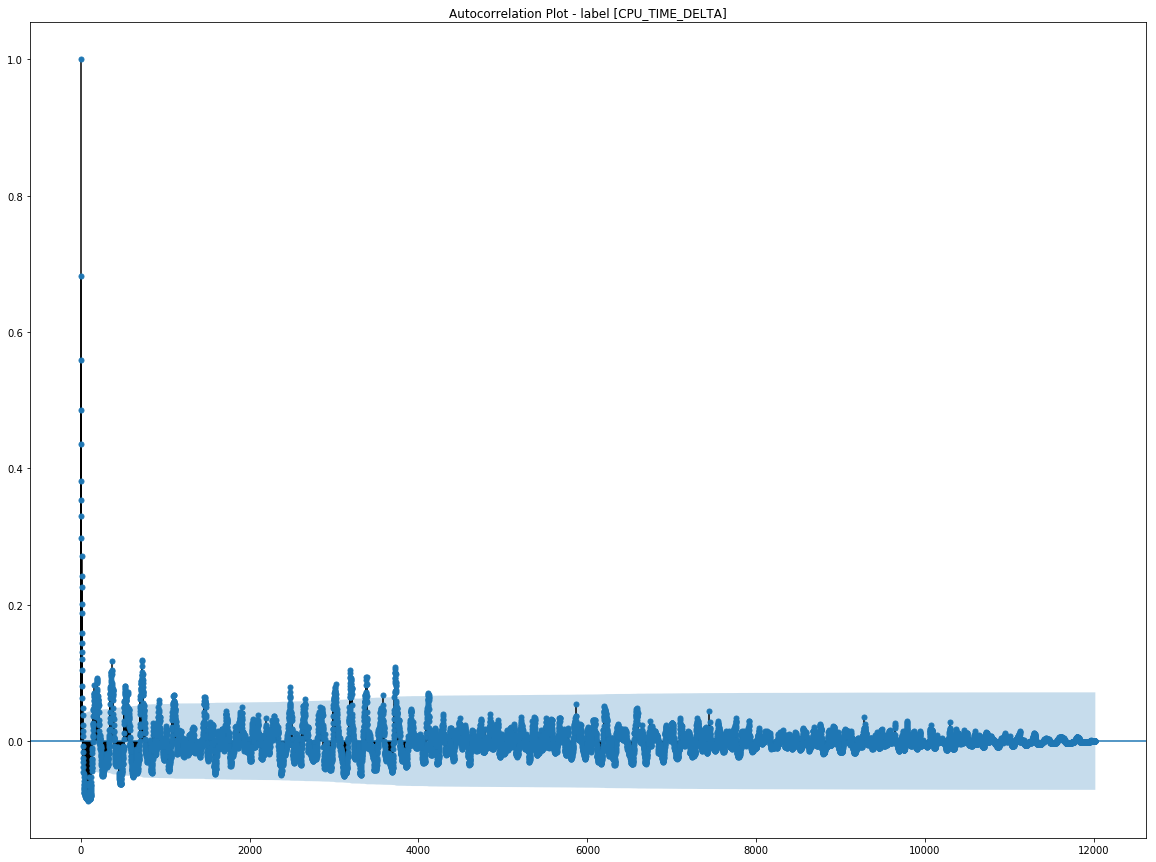

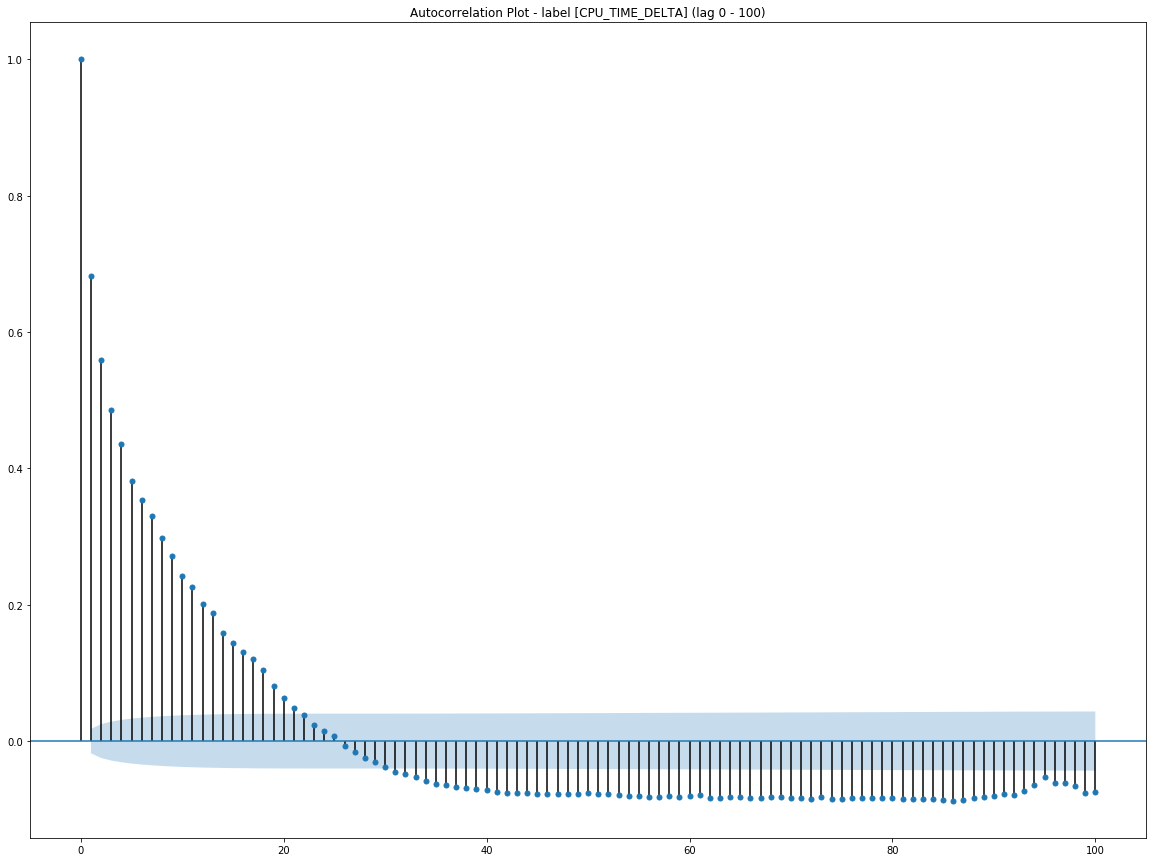

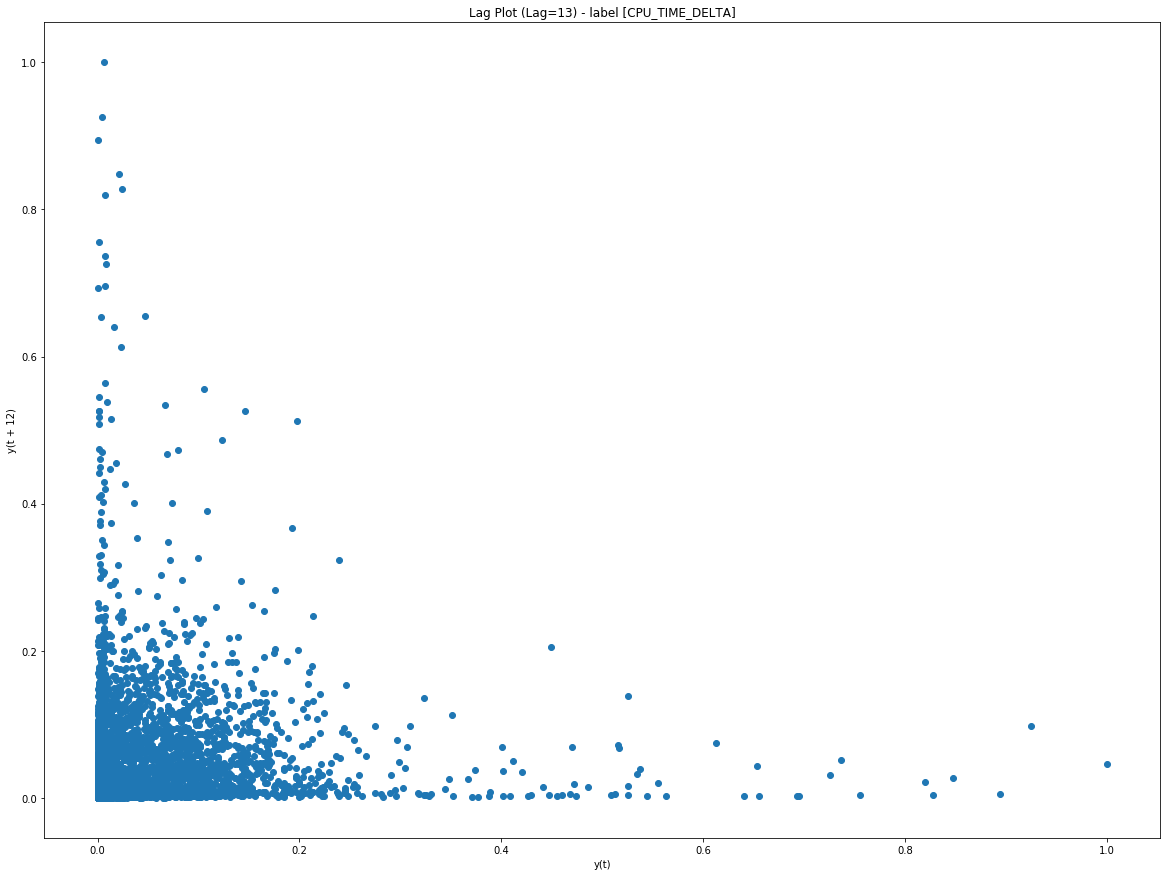

Label - [IOWAIT_DELTA]


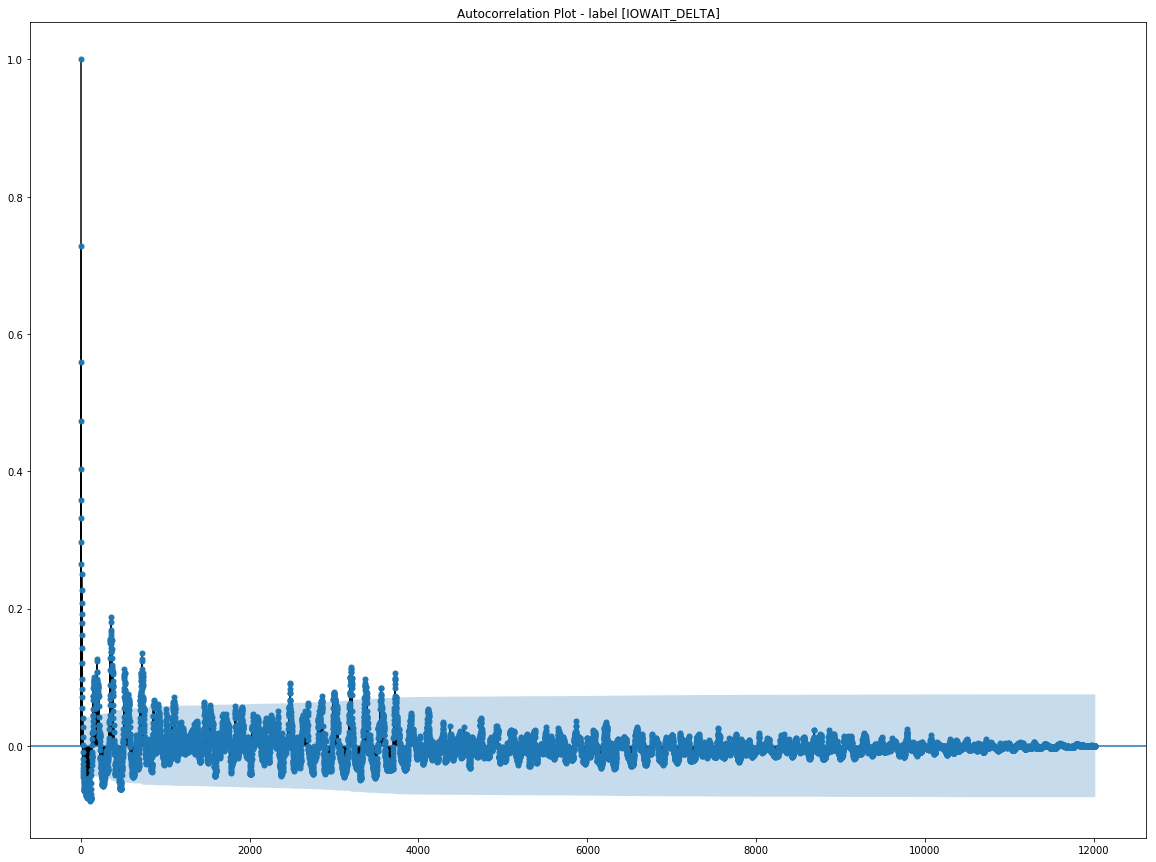

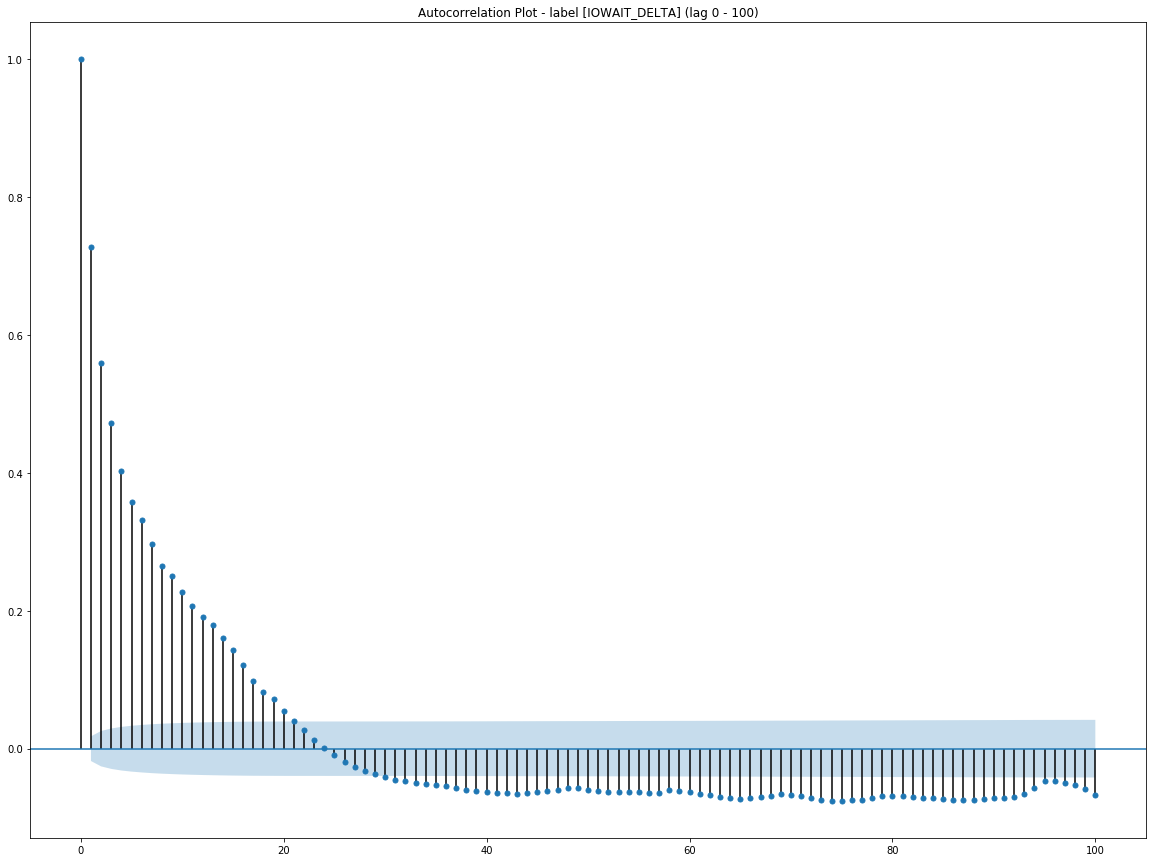

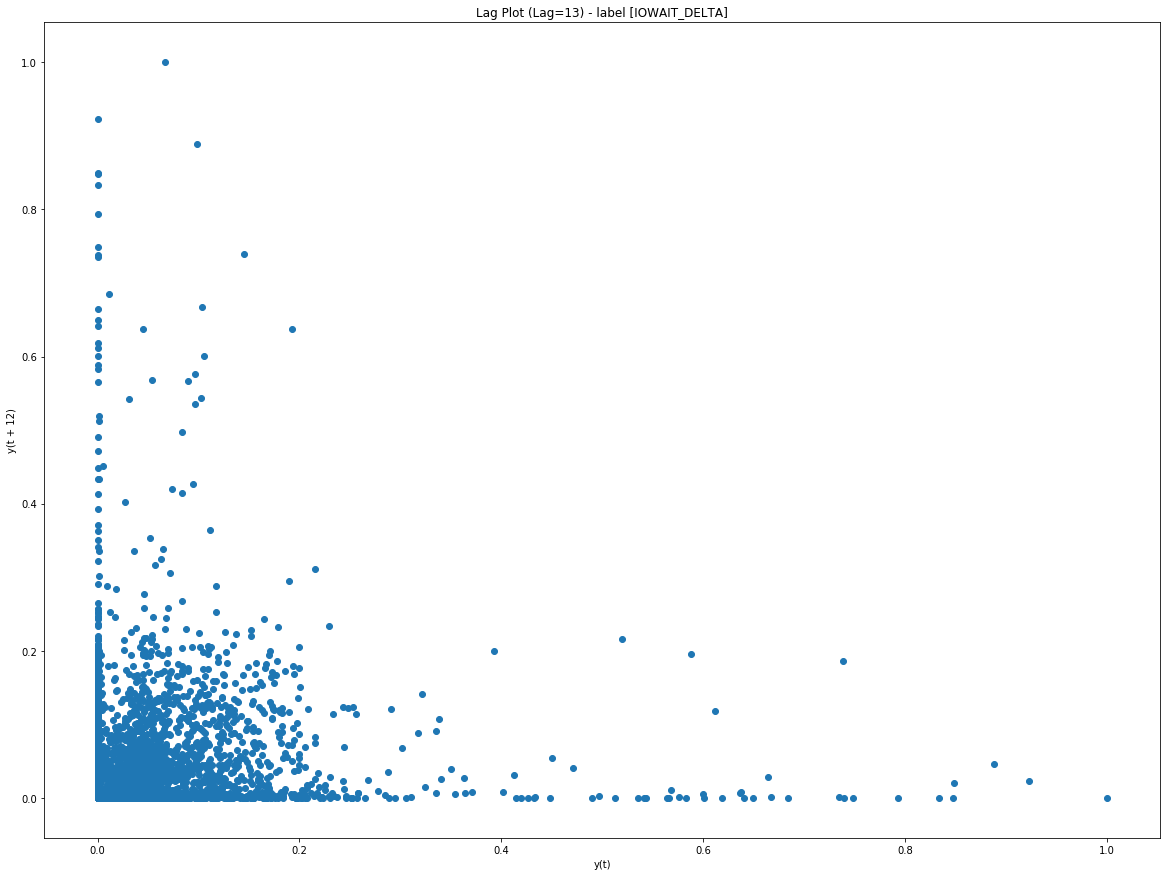

In [47]:
def qualify_lag(data, labels):
    for label in labels:
        print('Label - [' + label + ']')
        plot_acf(data[label])
        plt.rcParams['figure.figsize'] = [20, 15]
        plt.title('Autocorrelation Plot - label [' + label + ']')
        plt.show()
        plot_acf(data[label], lags=100)
        plt.rcParams['figure.figsize'] = [20, 15]
        plt.title('Autocorrelation Plot - label [' + label + '] (lag 0 - 100)')
        plt.show()
        lag_plot(data[label], lag=lag) # Lag 13 is hardcoded, and derived from the above auto correlation plot.
        plt.rcParams['figure.figsize'] = [20, 15]
        plt.title('Lag Plot (Lag=13) - label [' + label + ']')
        plt.show()

qualify_lag(data=df,
            labels=y_label)

### Discrete Training

This section converts the established features from the continuous domain into the discrete domain. Continous values will be converted into discrete, and used to train the model using such values (Utilizes bucket function).

https://machinelearningmastery.com/make-predictions-long-short-term-memory-models-keras/

In [48]:
class BinClass:
    """
    Takes data column, and scales them into discrete buckets. Parameter 'n' denotes number of buckets. This class needs
    to be defined before the LSTM class, since it is referenced during the prediction stage. Since Keras models output a
    continuous output (even when trained on discrete data), the 'BinClass' is required by the LSTM class.
    """
    
    @staticmethod
    def __bucket_val(val, avg):
        """
        Receives threshold value and buckets the val according to the passed threshold
        """
        return np.where(val > avg, 1, 0)

    @staticmethod
    def discretize_value(X, threshold):
        """
        param: X - Input data
        """
        try:
            myfunc_vec = np.vectorize(lambda x: BinClass.__bucket_val(x, threshold))
            return myfunc_vec(X)
        except:
            return BinClass.__bucket_val(X, threshold)

cpu_avg = y_df[y_label[0]].mean()
y_df_cpu = pd.DataFrame(BinClass.discretize_value(y_df[[y_label[0]]].values, cpu_avg), columns=[y_label[0]])
print('CPU y:')
print(np.unique(y_df_cpu.values))
print('Number of 0s: ' + str(np.count_nonzero(y_df_cpu == 0)))
print('Number of 1s: ' + str(np.count_nonzero(y_df_cpu == 1)))
#
io_avg = y_df[y_label[1]].mean()
y_df_io = pd.DataFrame(BinClass.discretize_value(y_df[[y_label[1]]].values, io_avg), columns=[y_label[1]])
print('I/O y:')
print(np.unique(y_df_io.values))
print('Number of 0s: ' + str(np.count_nonzero(y_df_io == 0)))
print('Number of 1s: ' + str(np.count_nonzero(y_df_io == 1)))

CPU y:
[0 1]
Number of 0s: 9853
Number of 1s: 2166
I/O y:
[0 1]
Number of 0s: 10048
Number of 1s: 1971


### Time Series Shifting

Shifting the datasets N lag minutes, in order to transform the problem into a supervised dataset. Each Lag Shift equates to 60 seconds (due to the way design of the data capturing tool). For each denoted lag amount, the same number of feature vectors will be stripped away at the beginning.

Features and Labels are separated into seperate dataframes at this point.

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [49]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    if n_in != 0:
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    n_out += 1
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def remove_n_time_steps(data, n=1):
    if n == 0:
        return data
    df = data
    headers = df.columns
    dropped_headers = []
    #     for header in headers:
    #         if "(t)" in header:
    #             dropped_headers.append(header)

    for i in range(1, n + 1):
        for header in headers:
            if "(t+" + str(i) + ")" in header:
                dropped_headers.append(str(header))

    return df.drop(dropped_headers, axis=1)


# Frame as supervised learning set
shifted_df = series_to_supervised(df, lag, lag)

# Separate labels from features
y_row = []
for i in range(lag + 1, (lag * 2) + 2):
    y_df_column_names = shifted_df.columns[len(df.columns) * i:len(df.columns) * i + len(y_label)]
    y_row.append(y_df_column_names)
    print(y_df_column_names)
    print(type(y_df_column_names))
y_df_column_names = []
for row in y_row:
    for val in row:
        y_df_column_names.append(val)

# y_df_column_names = shifted_df.columns[len(df.columns)*lag:len(df.columns)*lag + len(y_label)]
y_df = shifted_df[y_df_column_names]
X_df = shifted_df
# X_df = shifted_df.drop(columns=y_df_column_names)

# # Delete middle timesteps
X_df = remove_n_time_steps(data=X_df, n=lag)
# print('\n-------------\nFeatures After Time Shift')
# print(X_df.columns)
# print(X_df.shape)
# y_df = remove_n_time_steps(data=y_df, n=lag)
# print('\n-------------\nLabels After Time Shift')
# print(y_df.columns)
# print(y_df.shape)

print('\n-------------\nFeatures')
print(X_df.columns)
print(X_df.shape)
print('\n-------------\nLabels')
print(y_df.columns)
print(y_df.shape)

Index(['var1(t+1)', 'var2(t+1)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+2)', 'var2(t+2)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+3)', 'var2(t+3)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+4)', 'var2(t+4)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+5)', 'var2(t+5)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+6)', 'var2(t+6)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+7)', 'var2(t+7)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+8)', 'var2(t+8)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+9)', 'var2(t+9)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+10)', 'var2(t+10)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+11)', 'var2(t+11)'], dtype='object')
<class 'pandas.core.indexes.base.Ind

### Test Split Train / Validation / Test

Split main feature/label matrix/vector into 2 subsets. 
* First subset will be used for training the model
* The other subset is split into two further subsets:
    - Model Validation
    - Model Testing
    
The training test itself is further reshaped, so as to satisfy the format required by LSTMS

X_train shape [(5997, 6838)] Type - <class 'numpy.ndarray'>
y_train shape [(5997, 24)] Type - <class 'numpy.ndarray'>
X_validate shape [(2999, 6838)] Type - <class 'numpy.ndarray'>
y_validate shape [(2999, 24)] Type - <class 'numpy.ndarray'>
X_test shape [(2999, 6838)] Type - <class 'numpy.ndarray'>
y_test shape [(2999, 24)] Type - <class 'numpy.ndarray'>


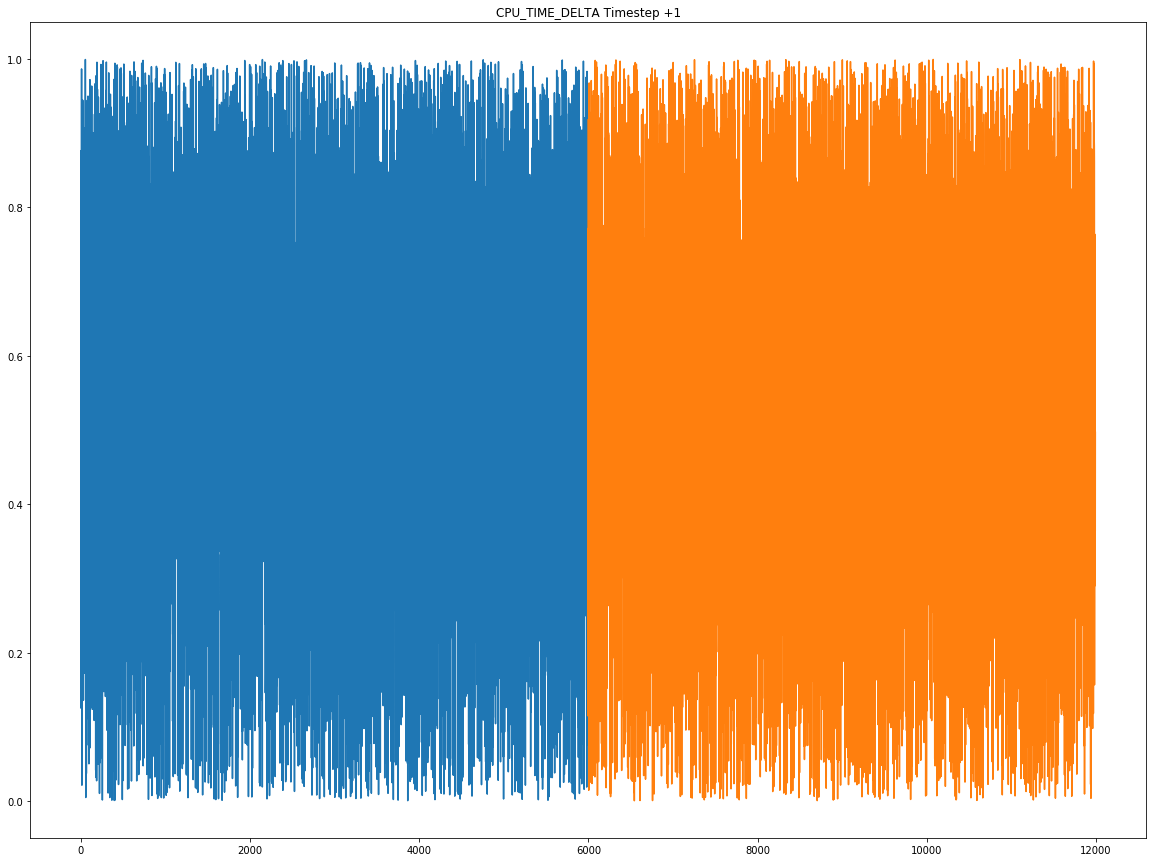

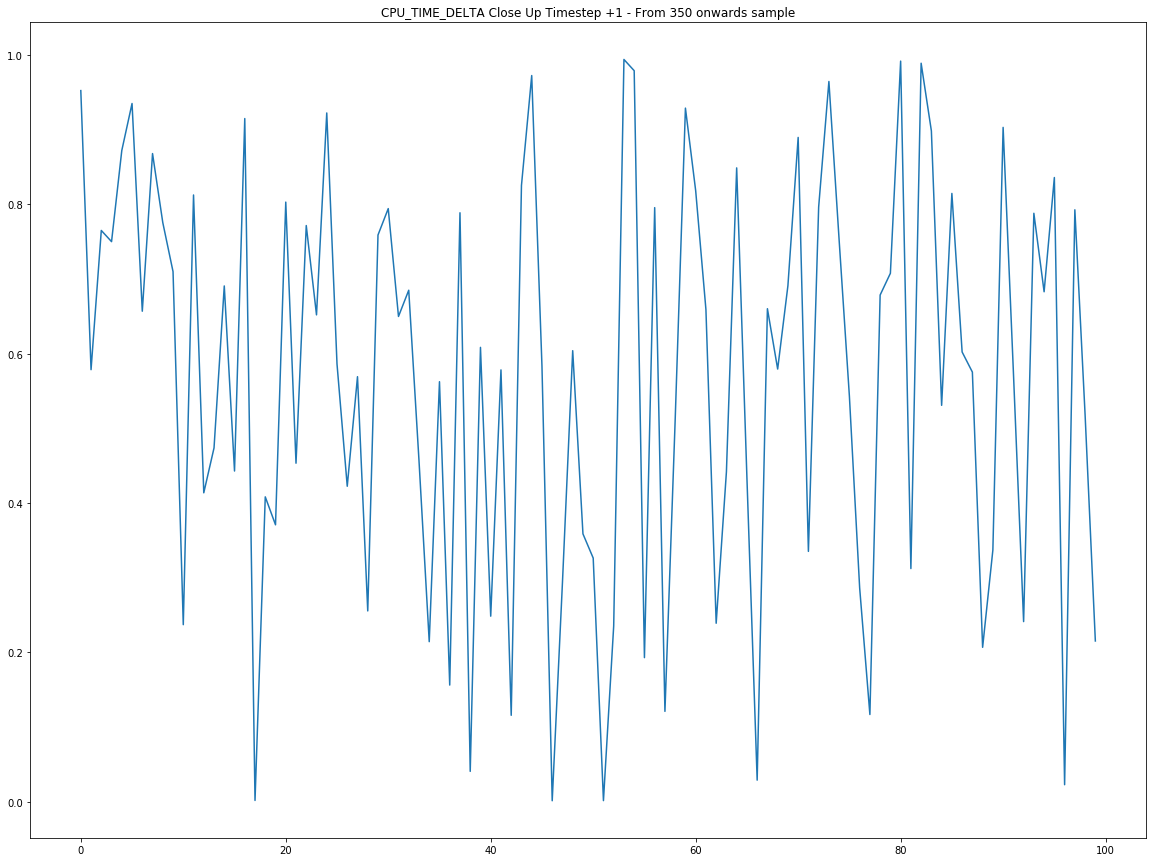

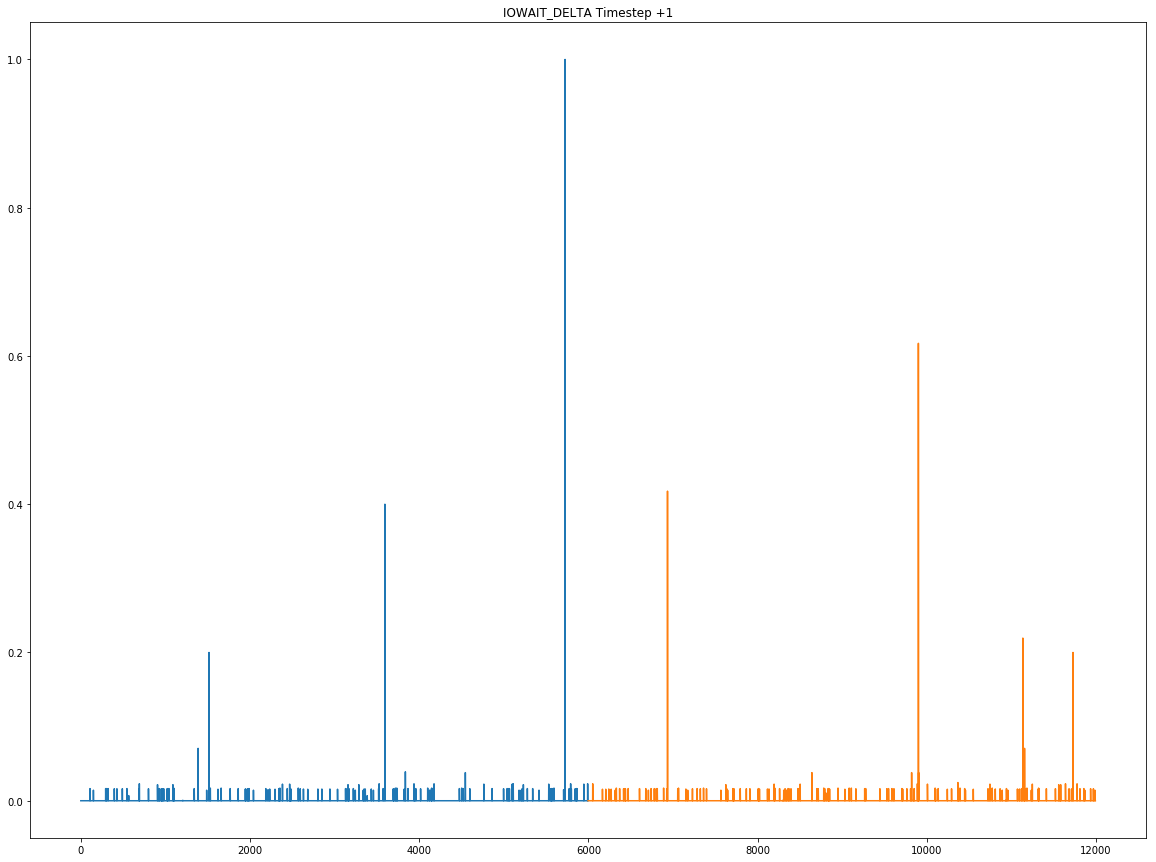

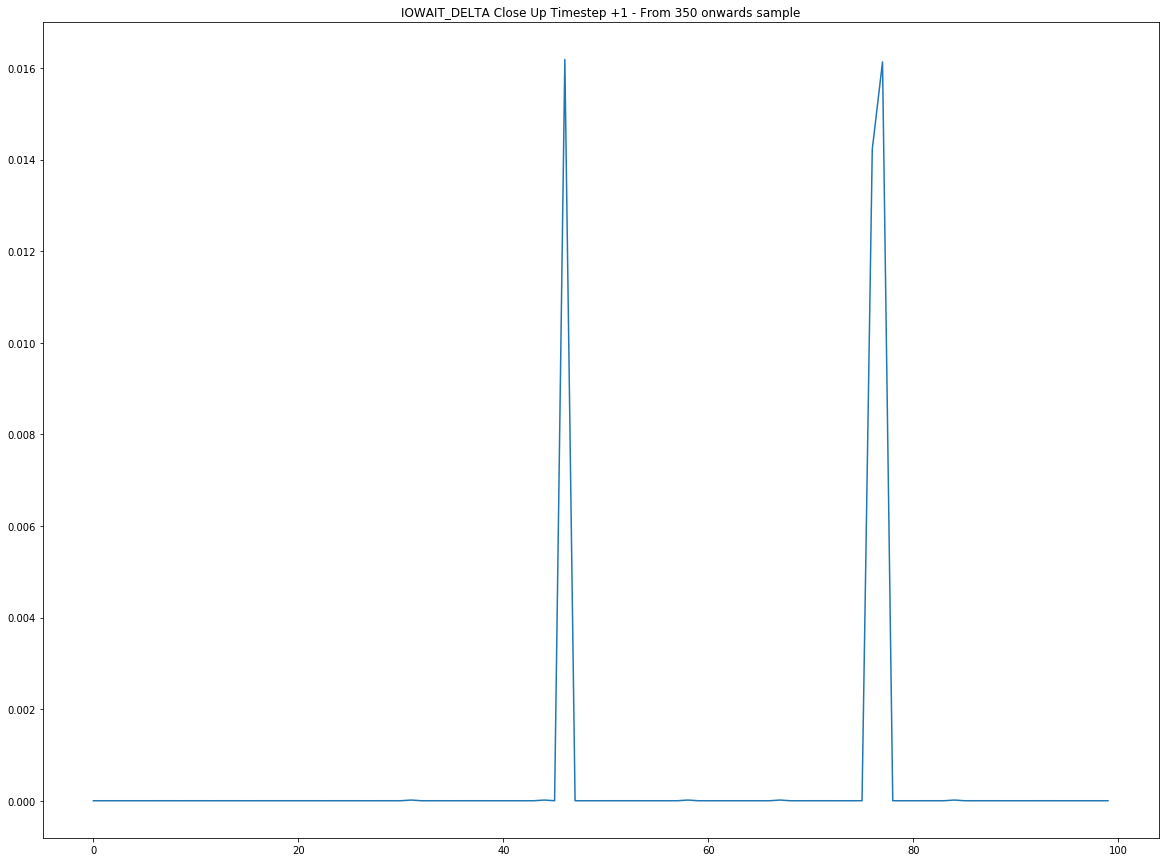

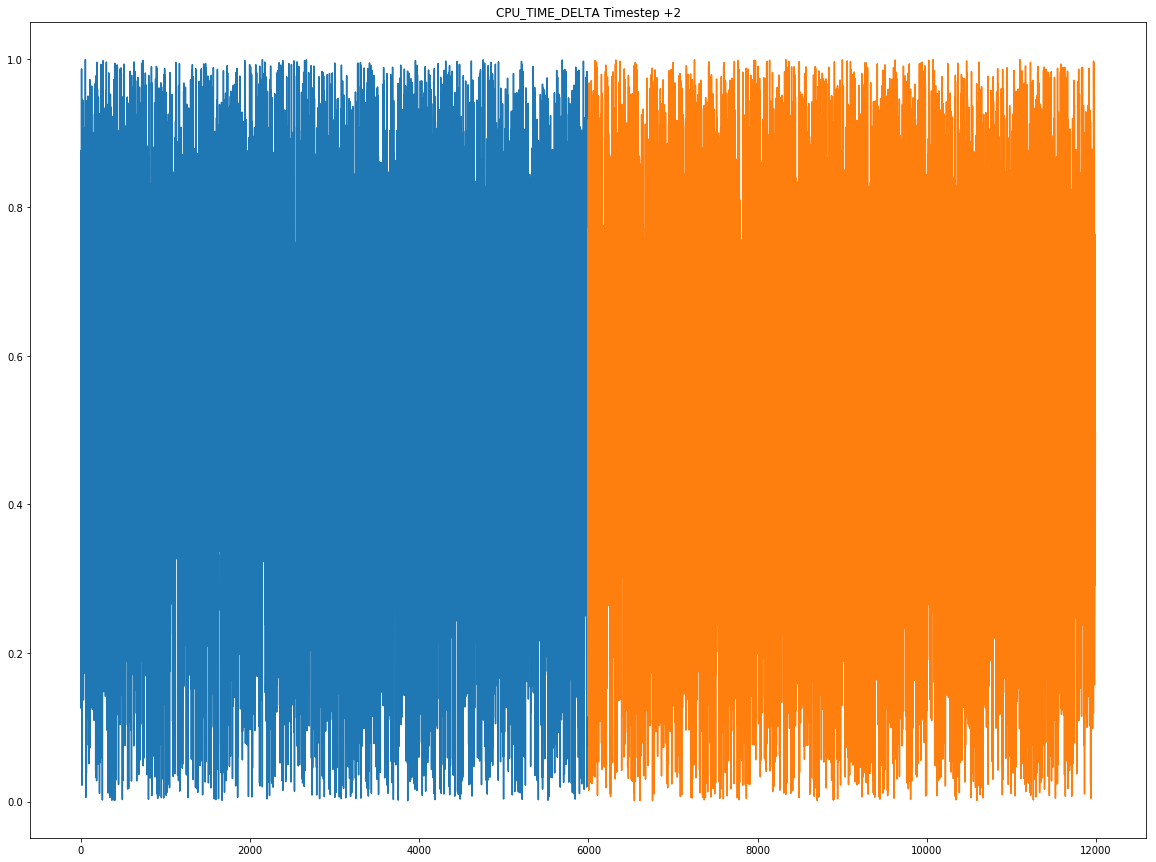

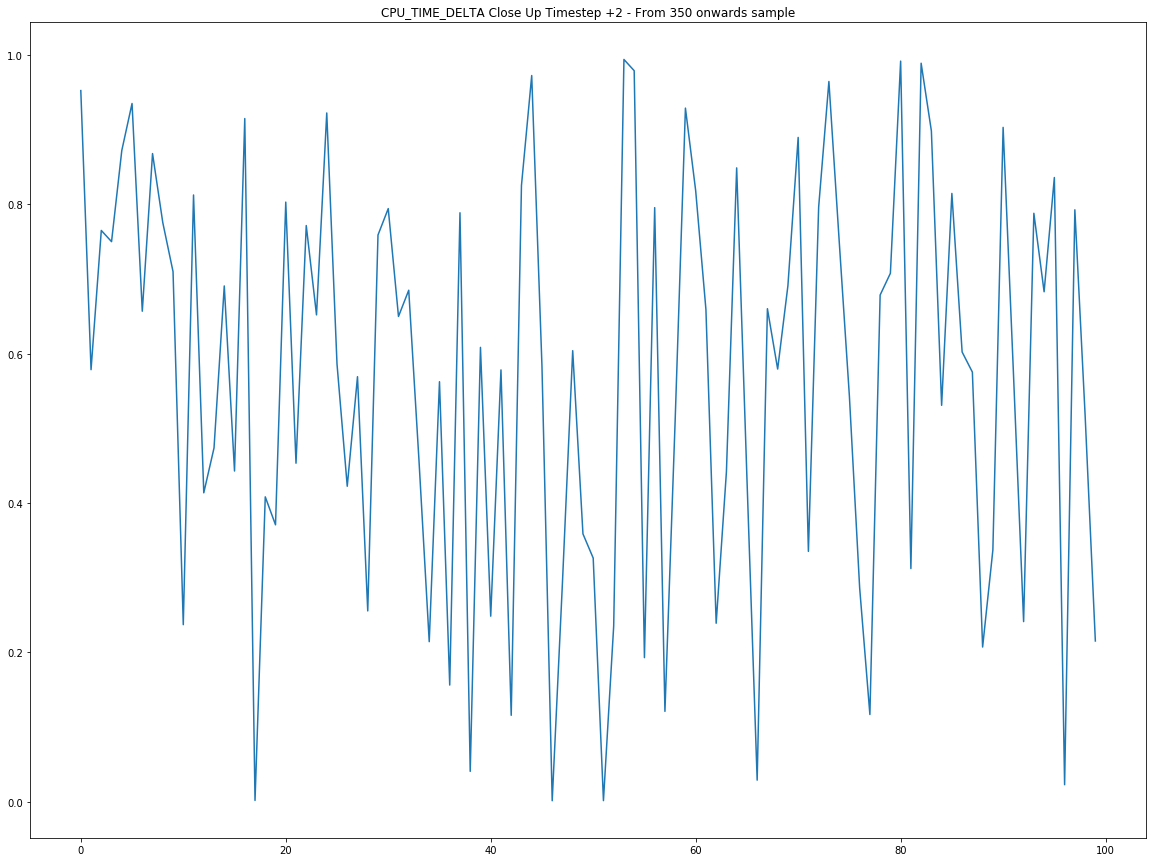

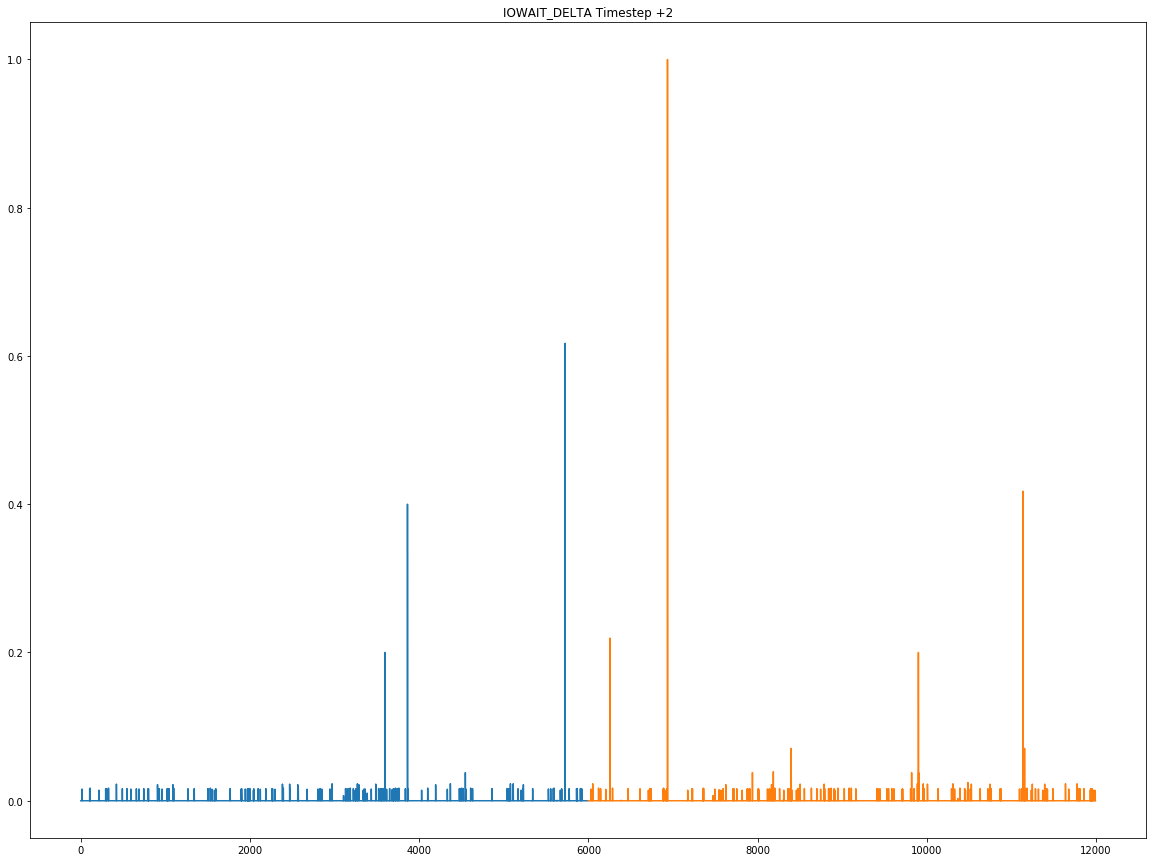

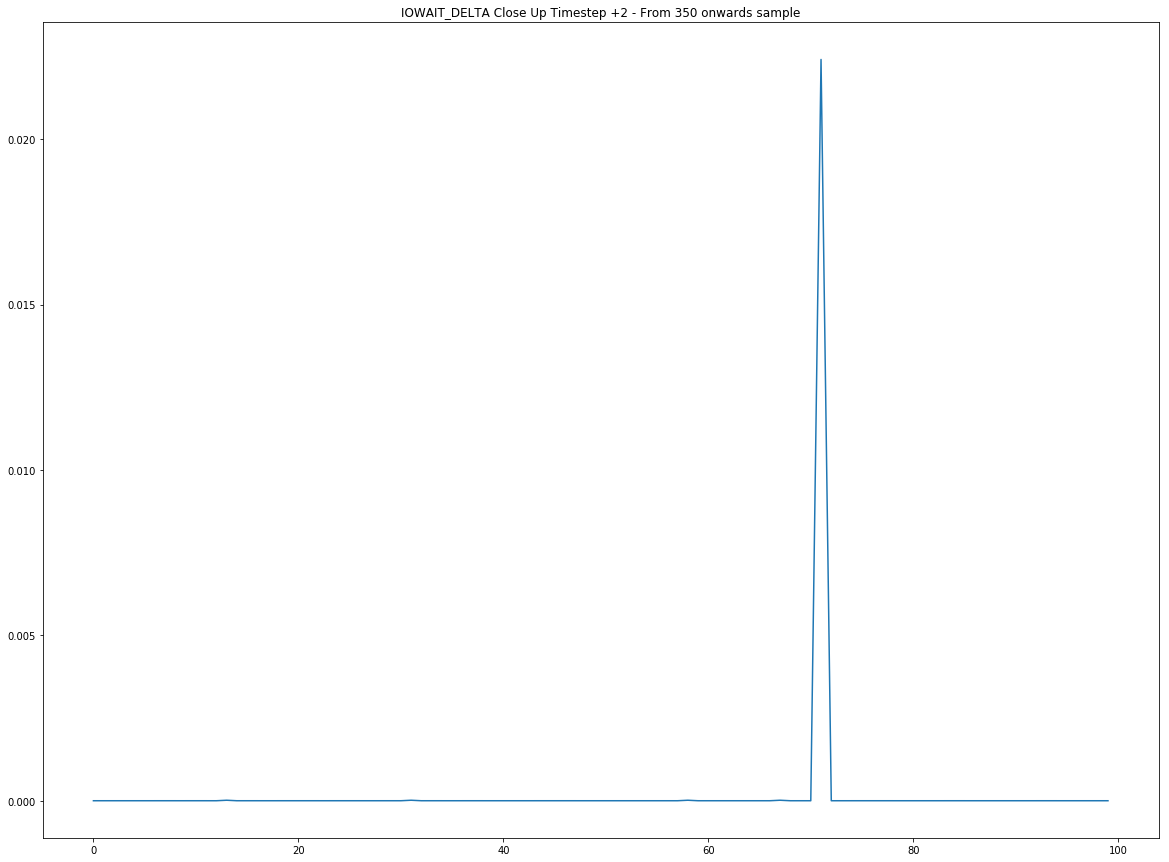

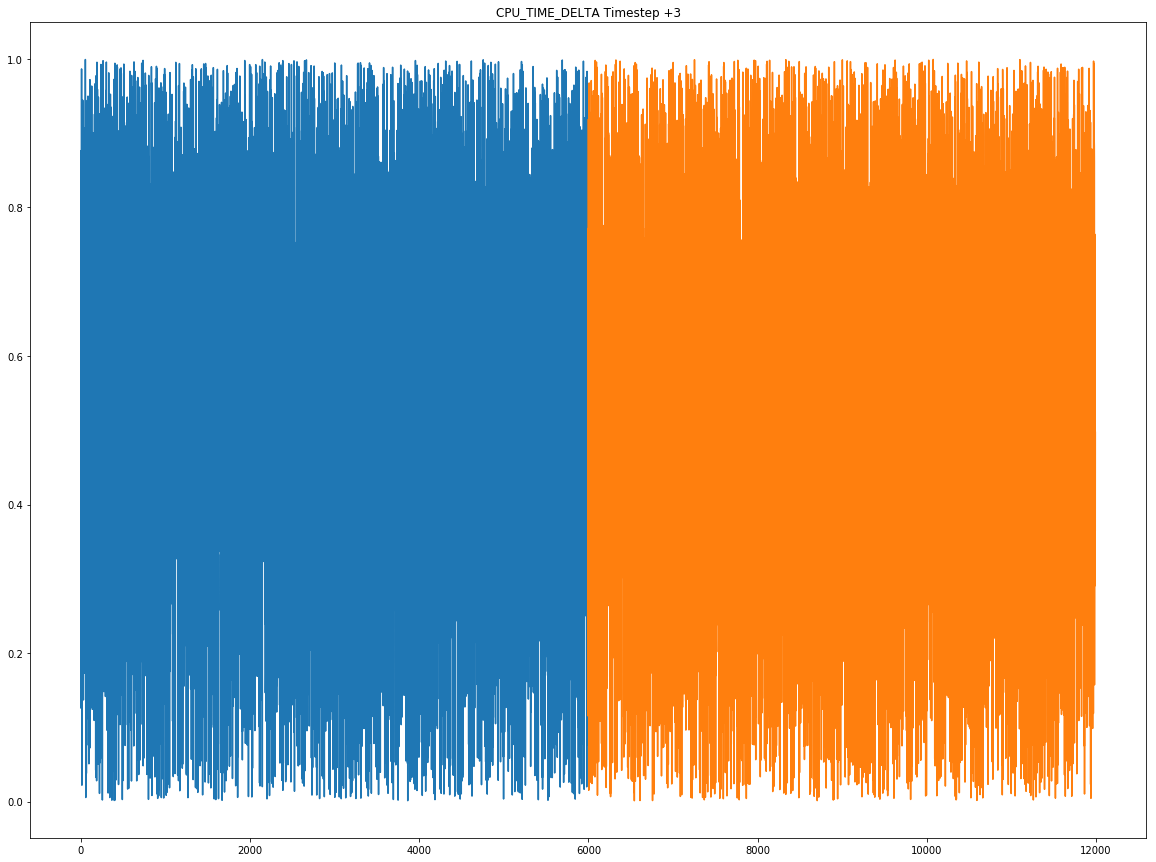

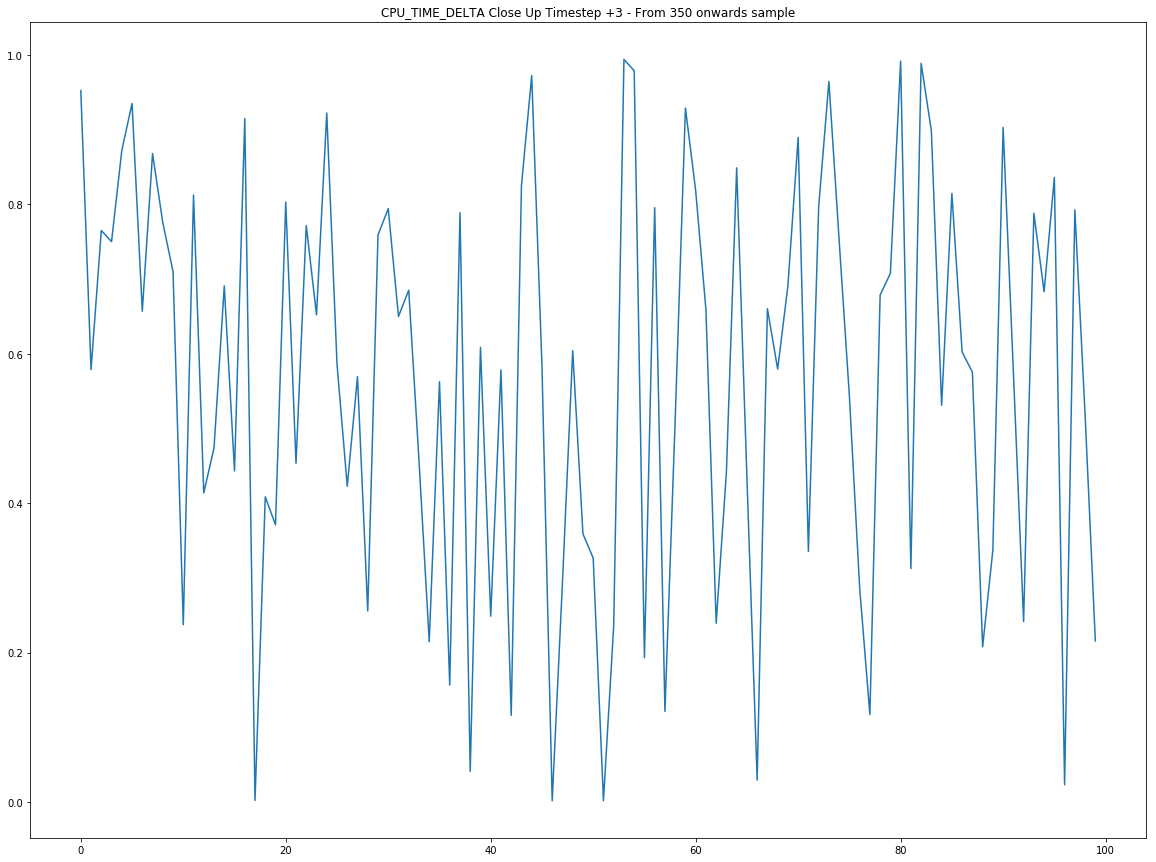

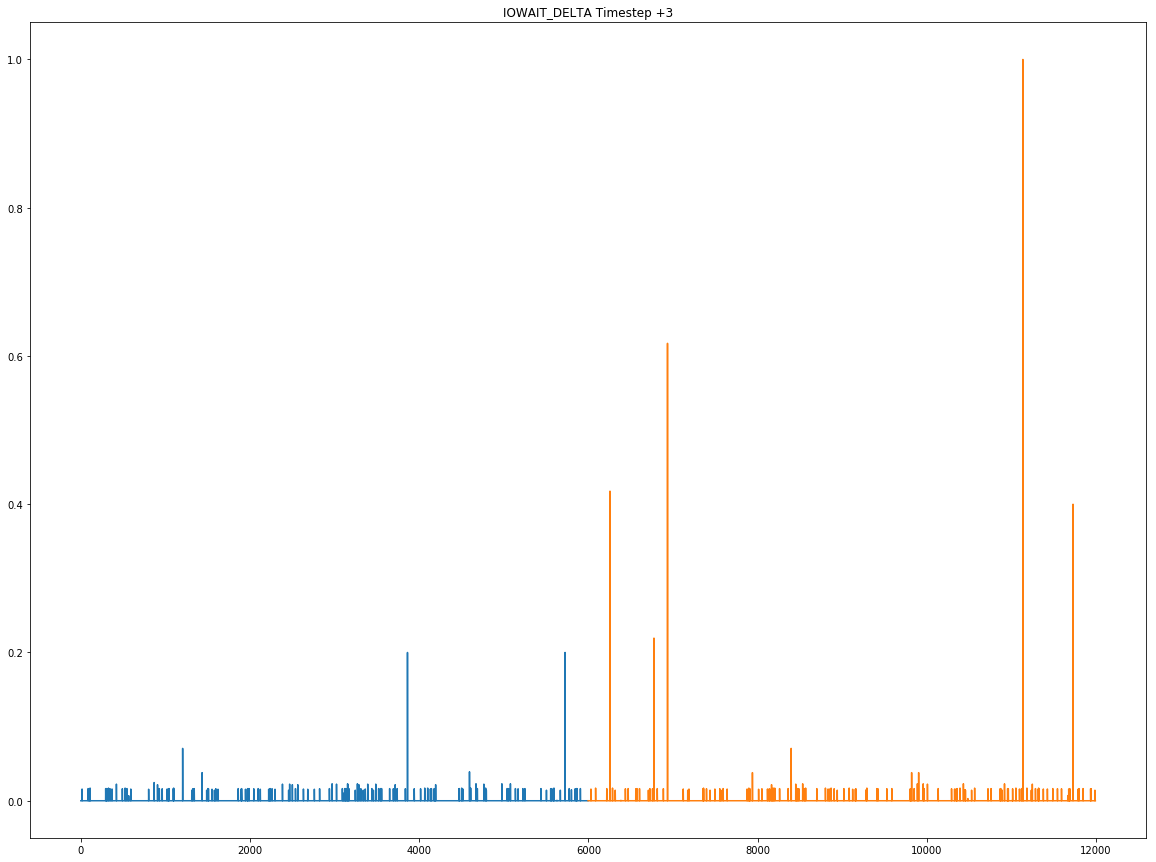

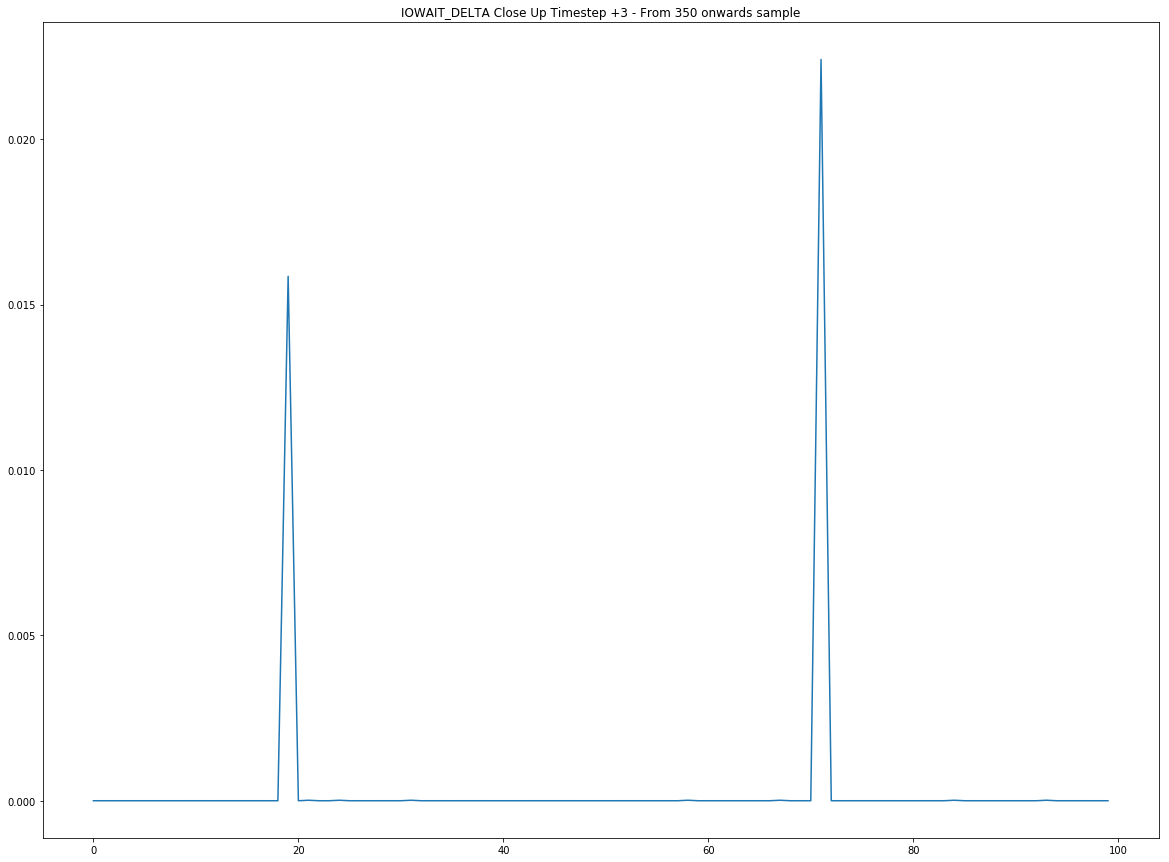

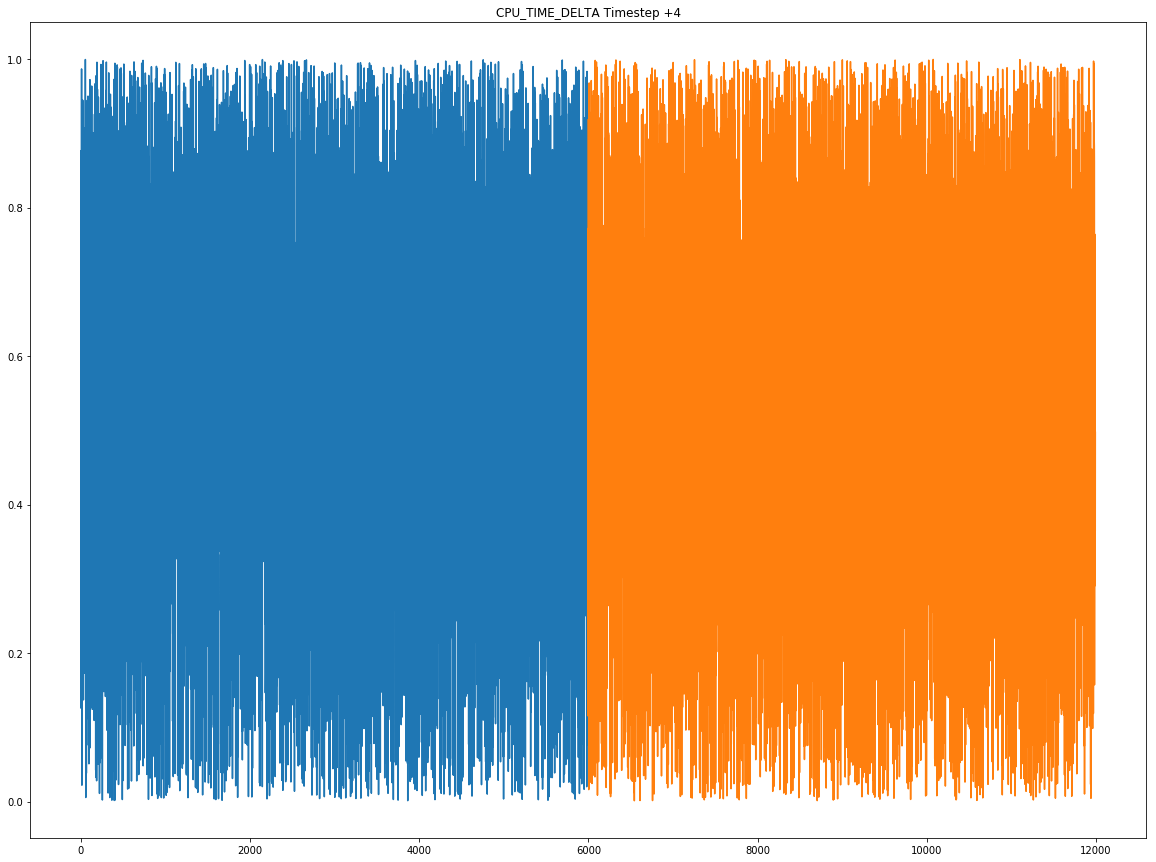

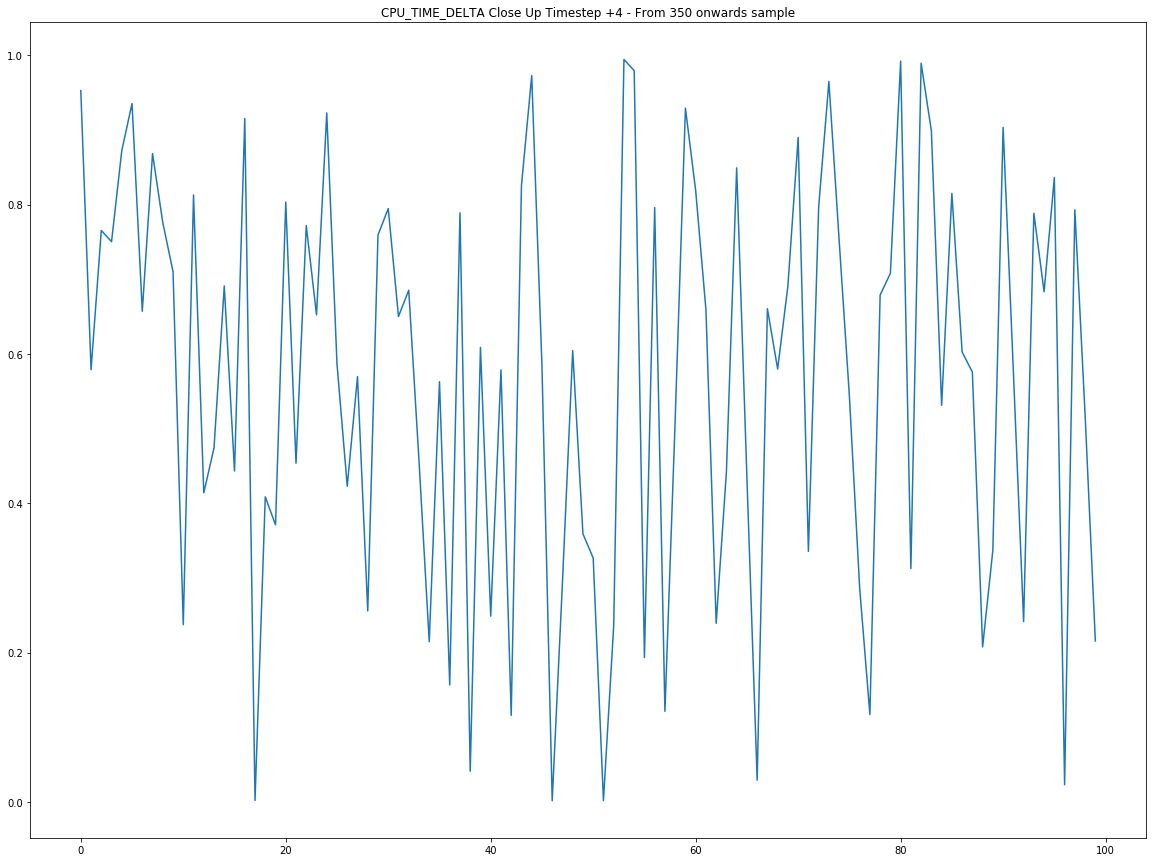

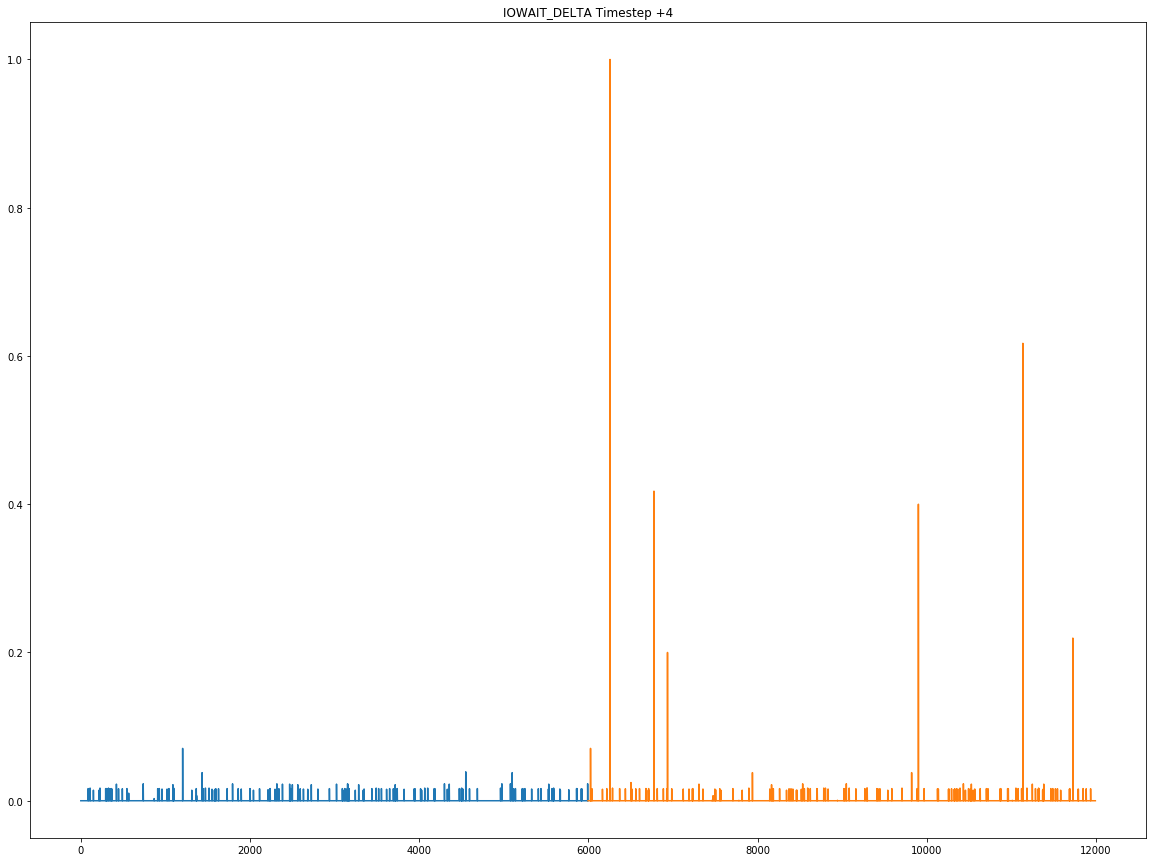

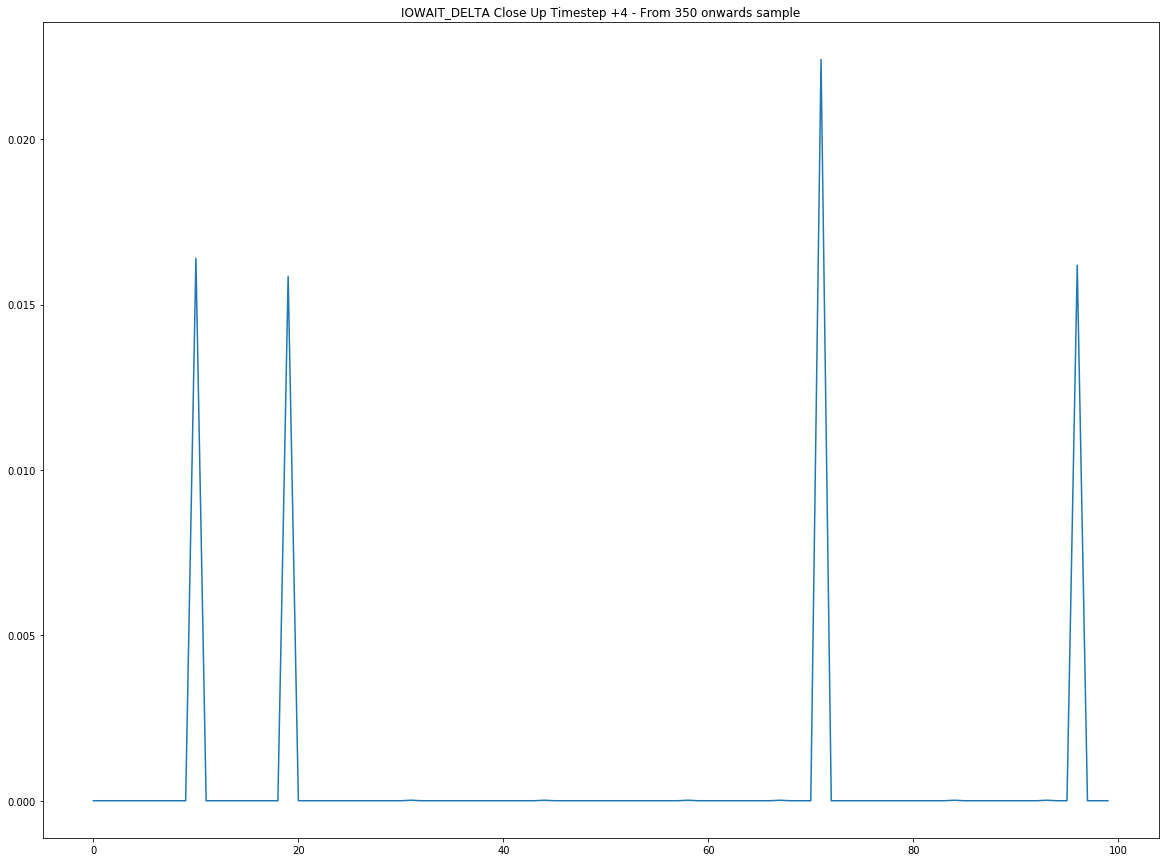

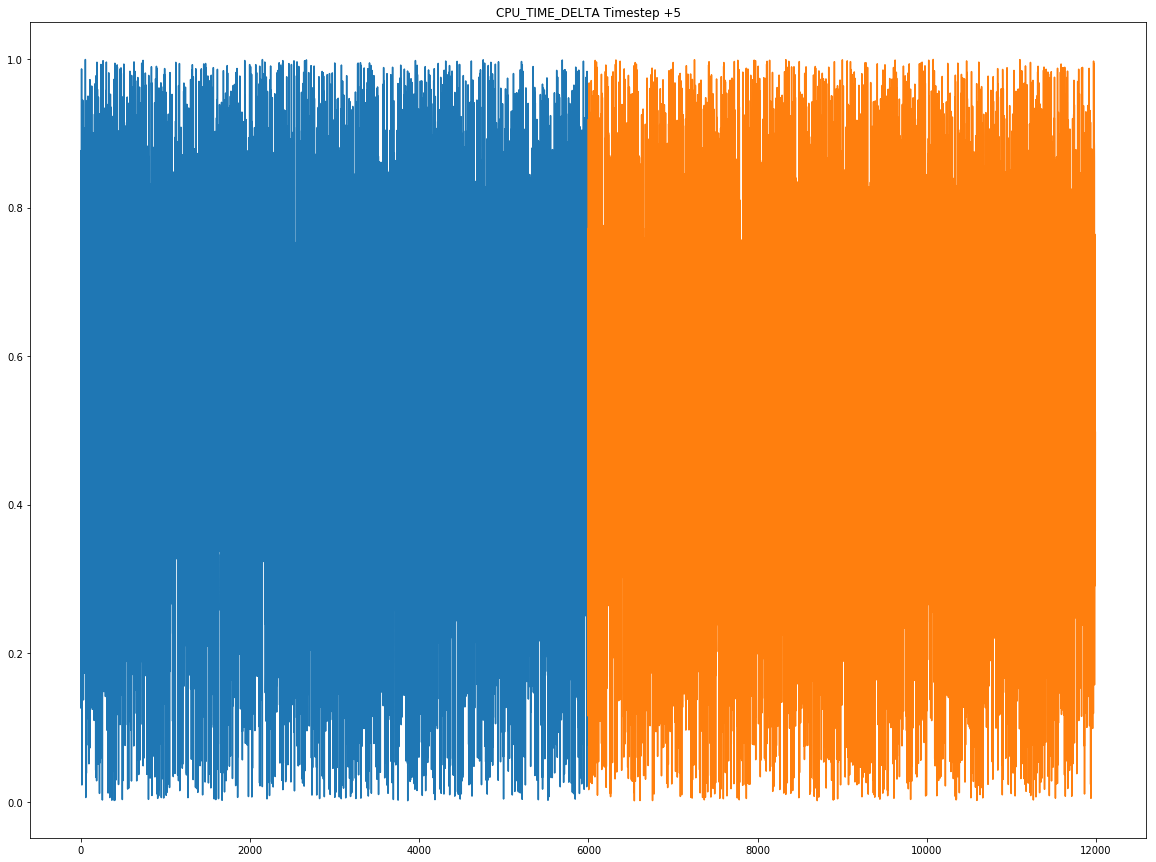

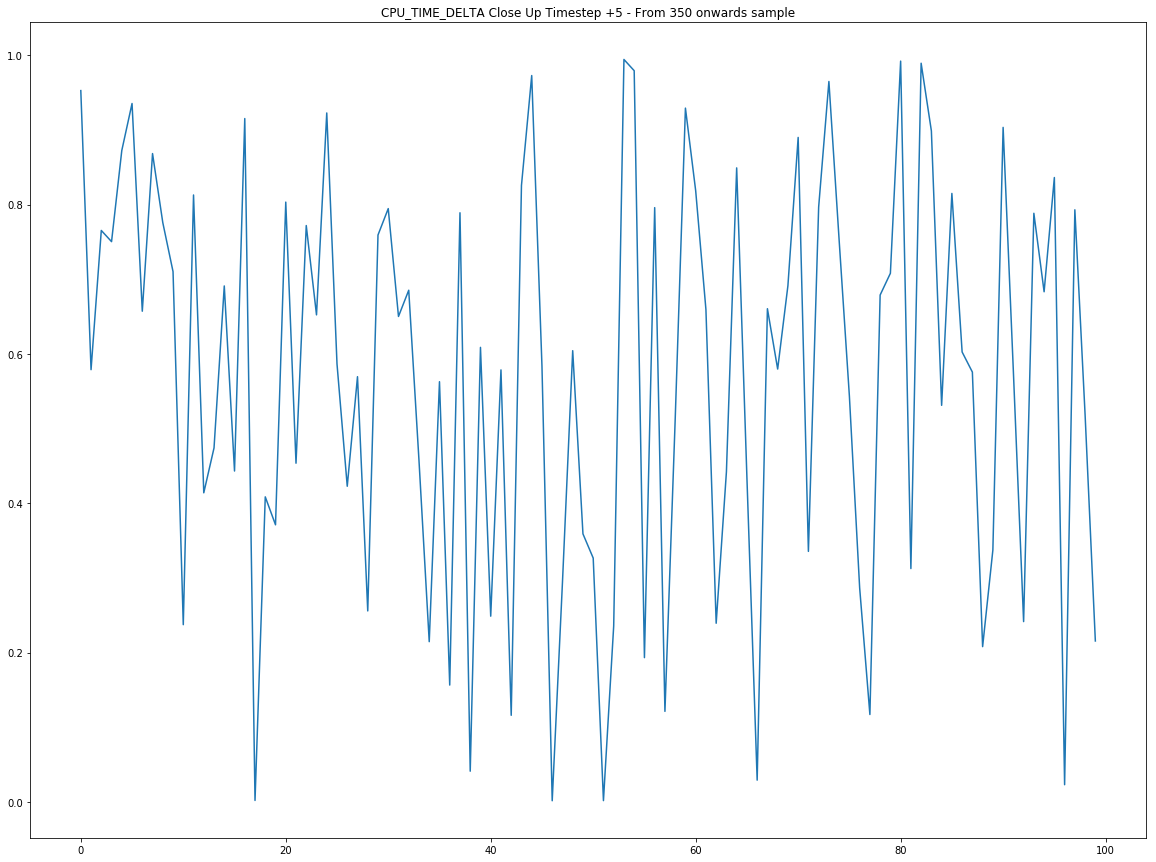

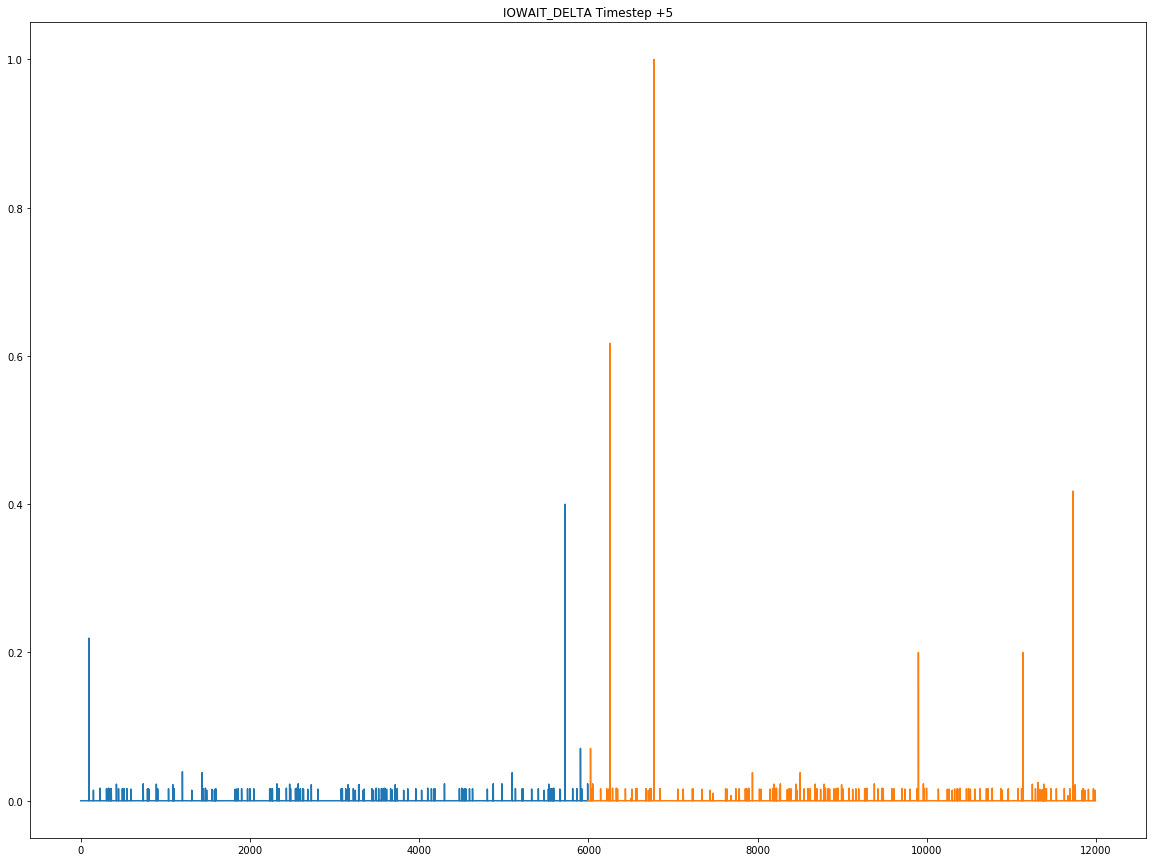

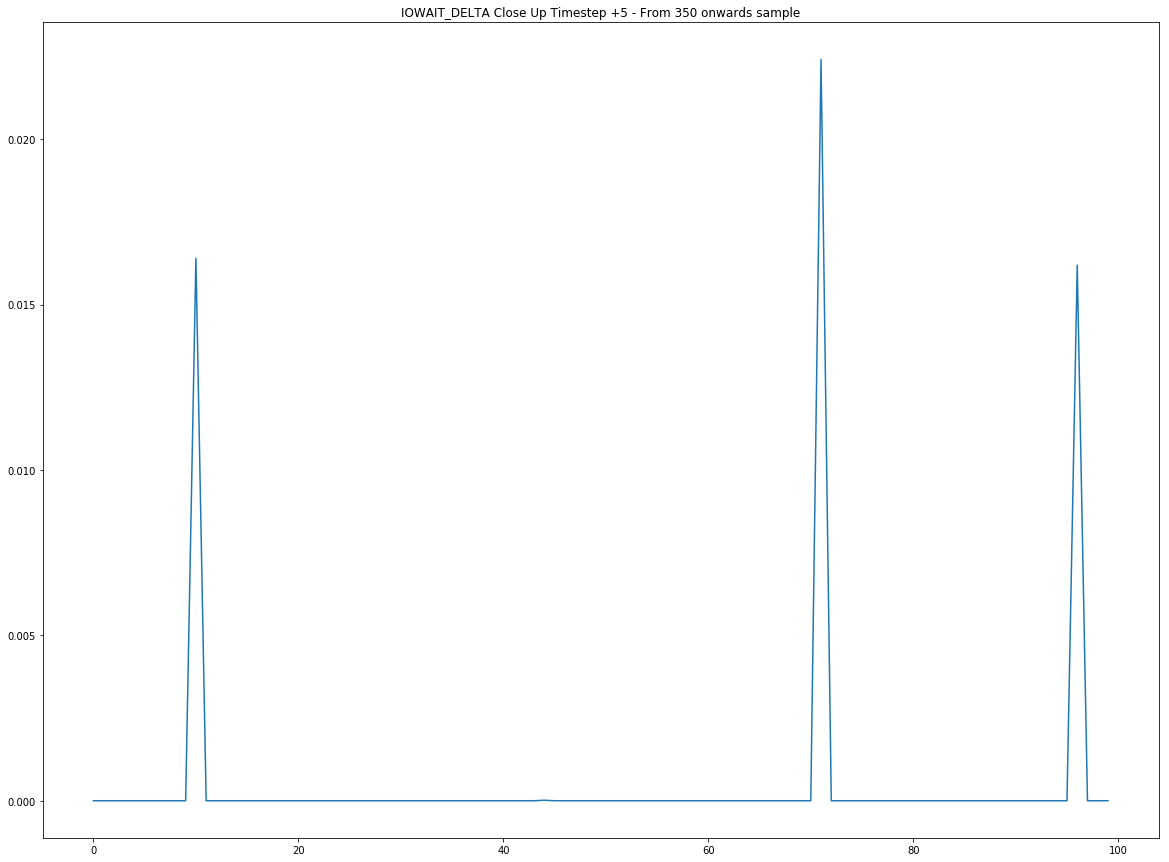

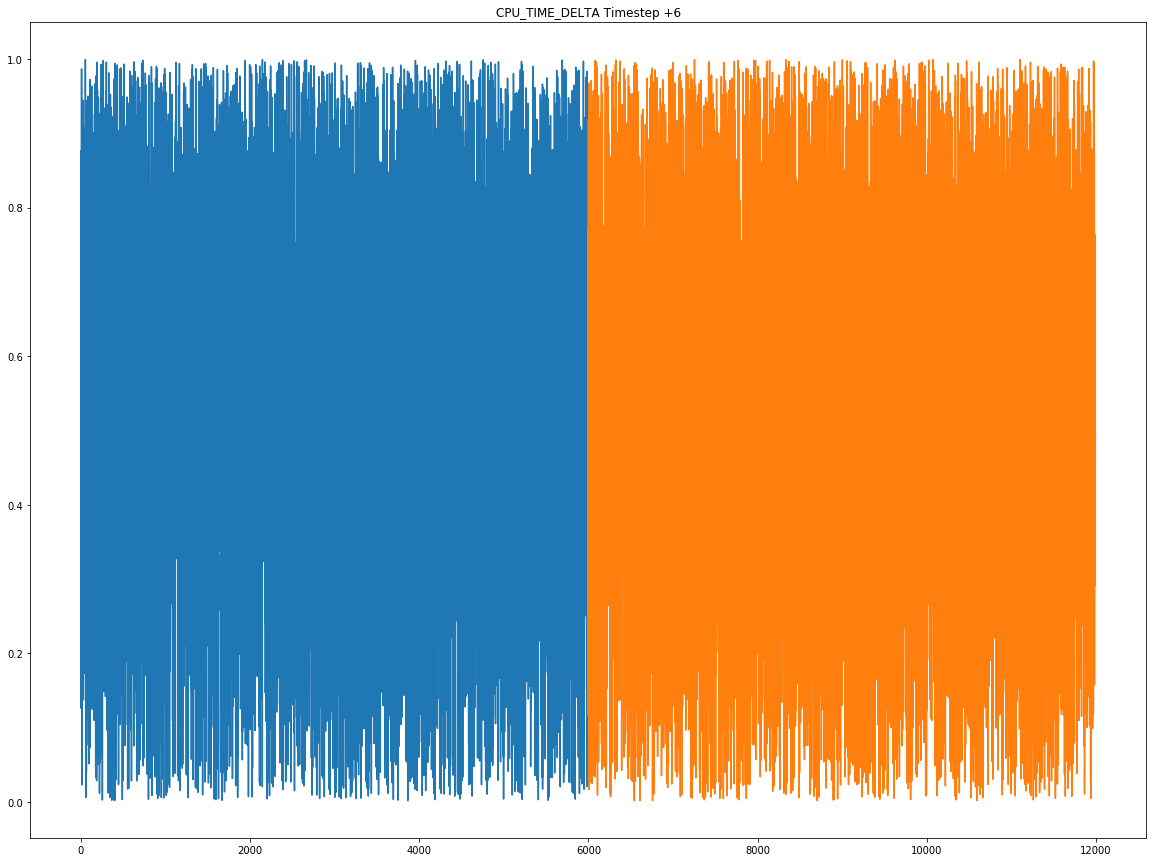

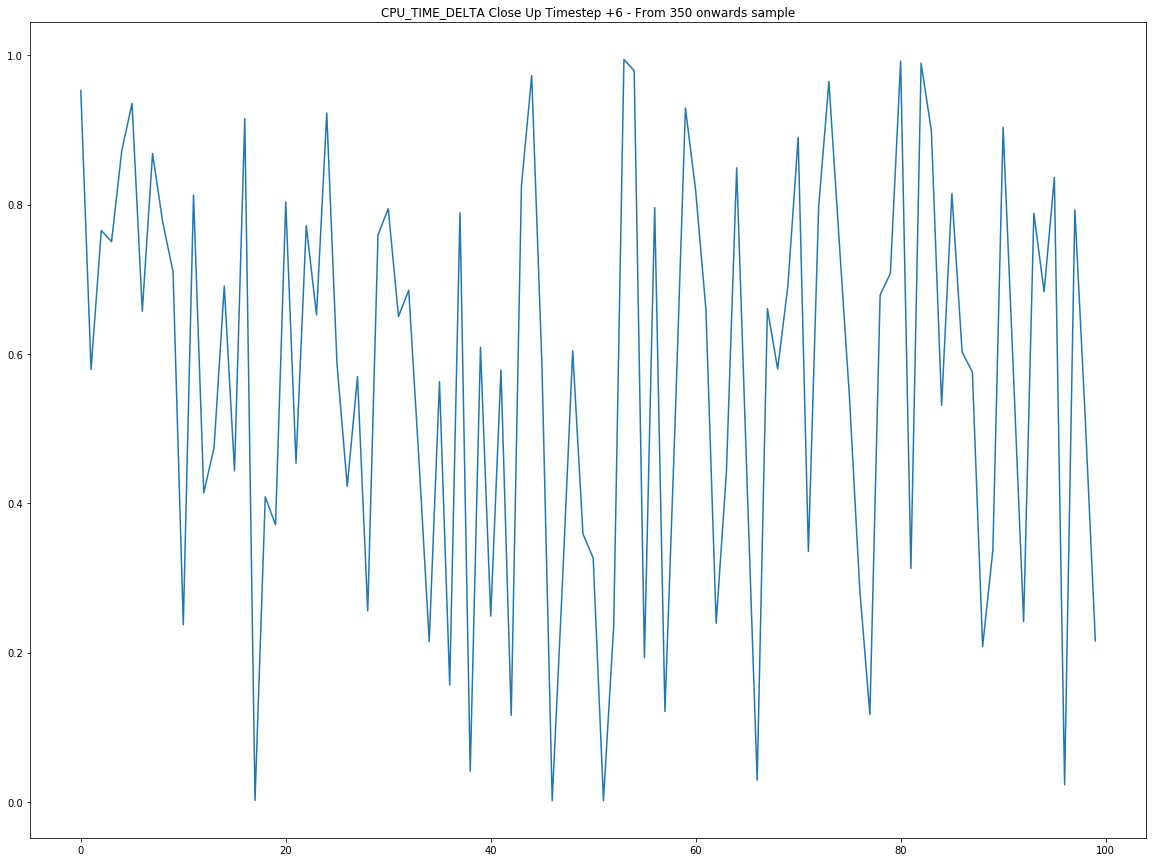

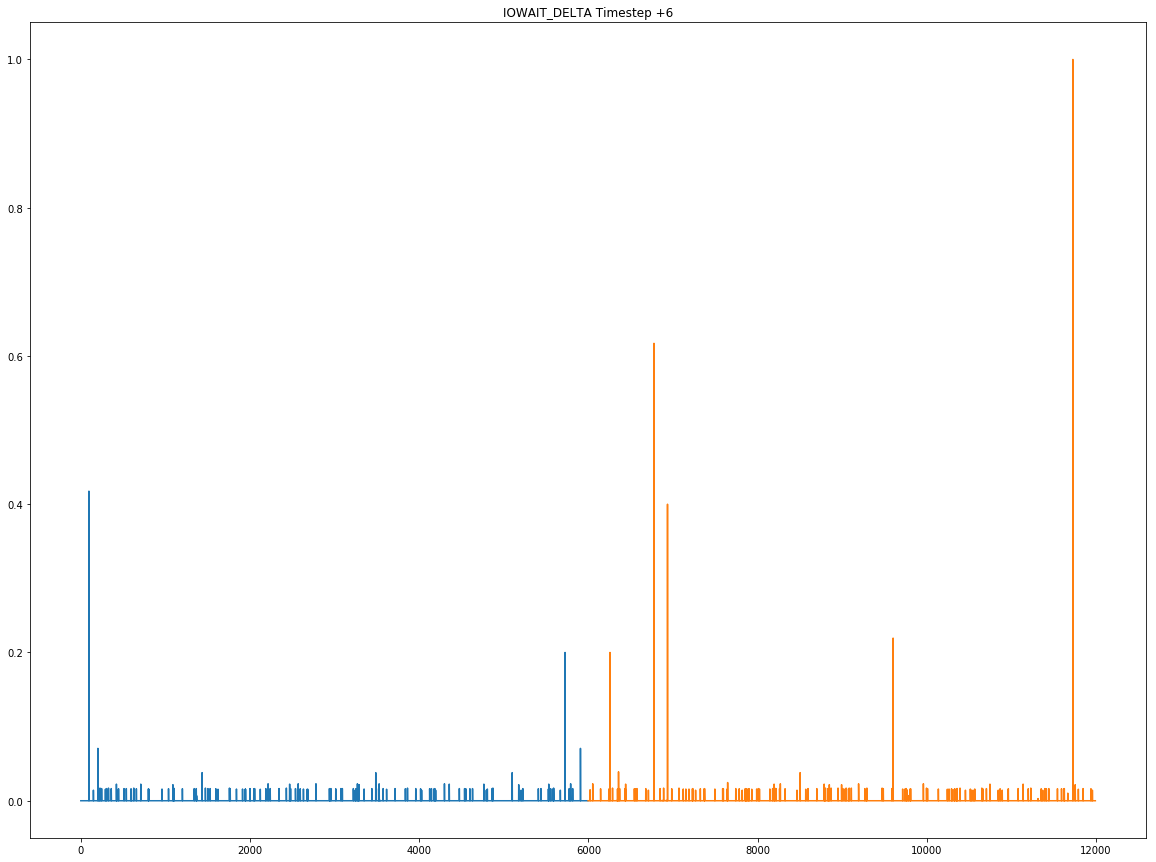

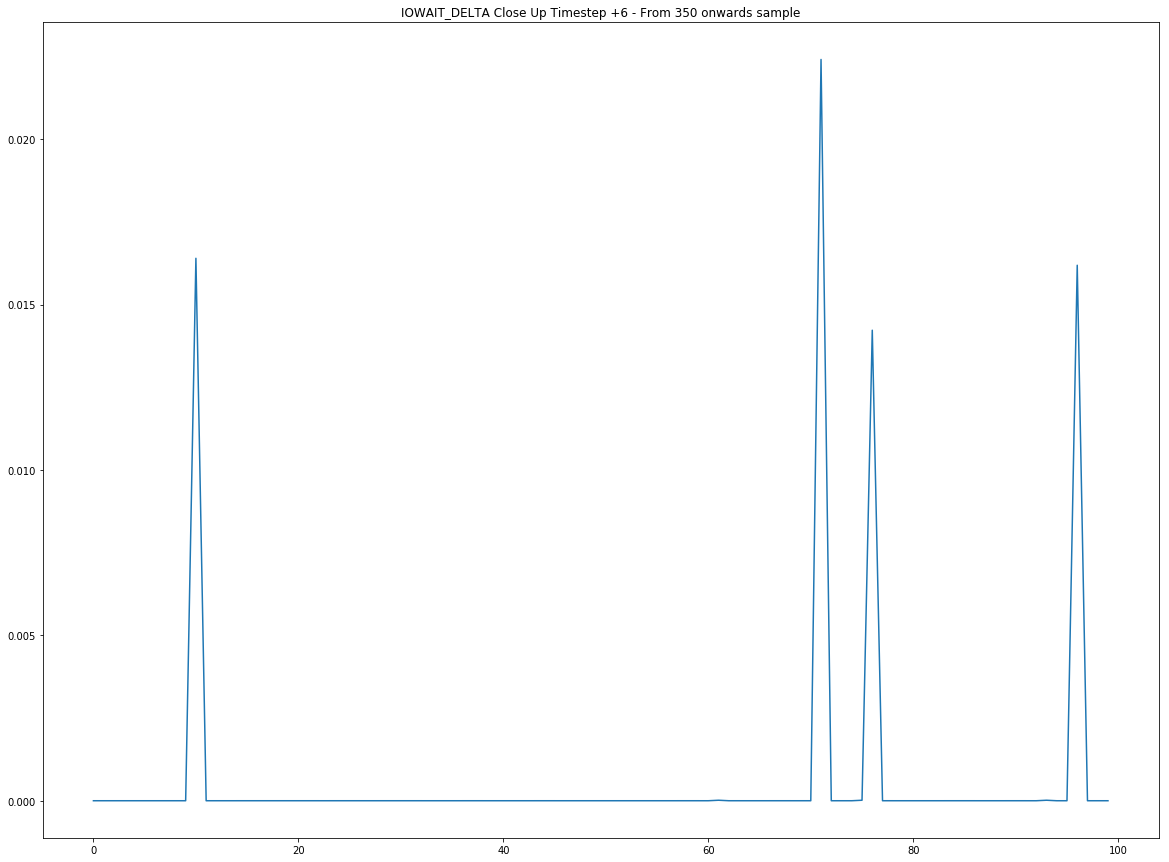

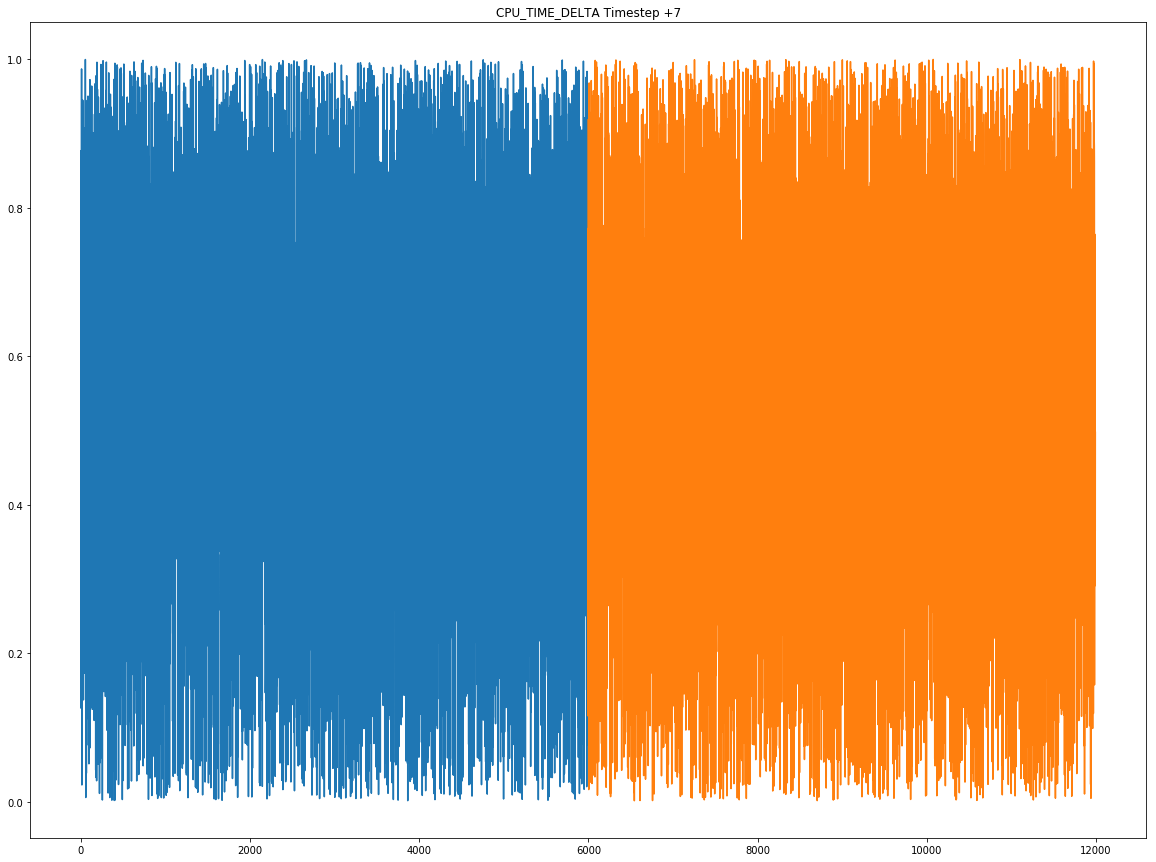

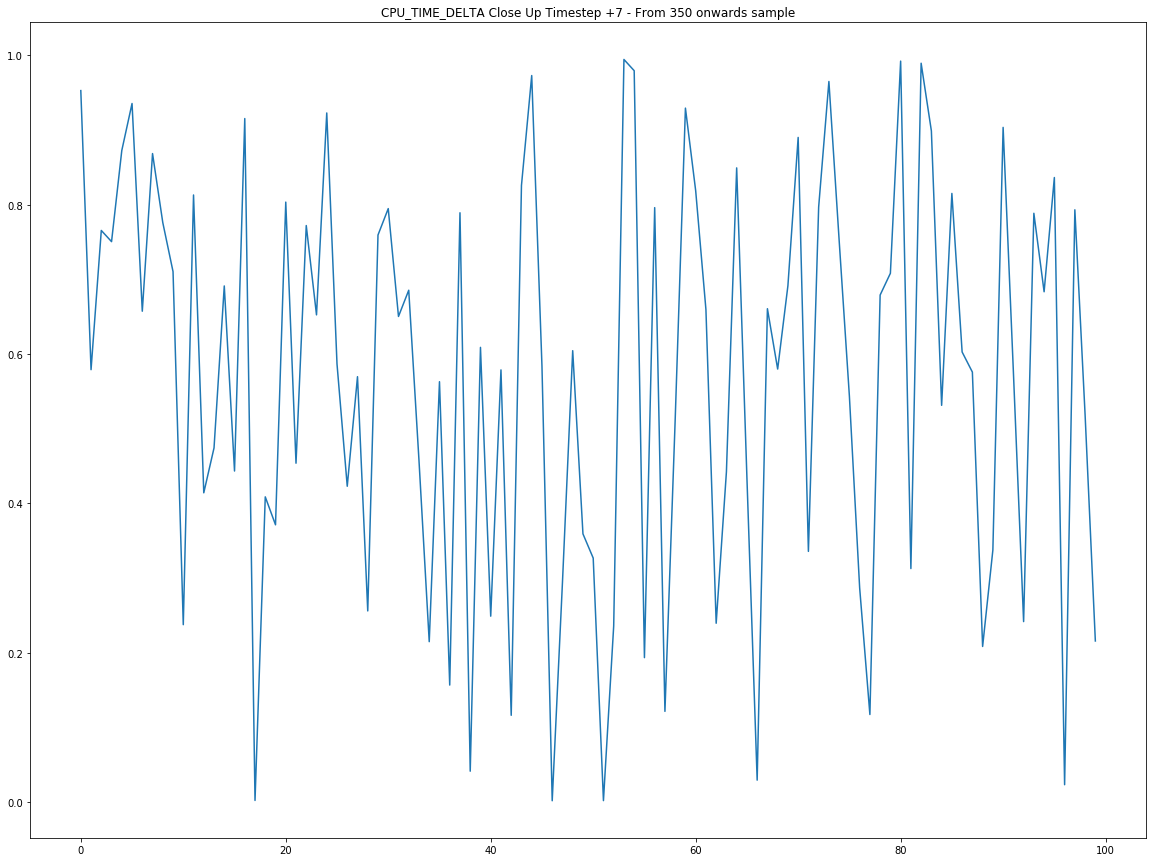

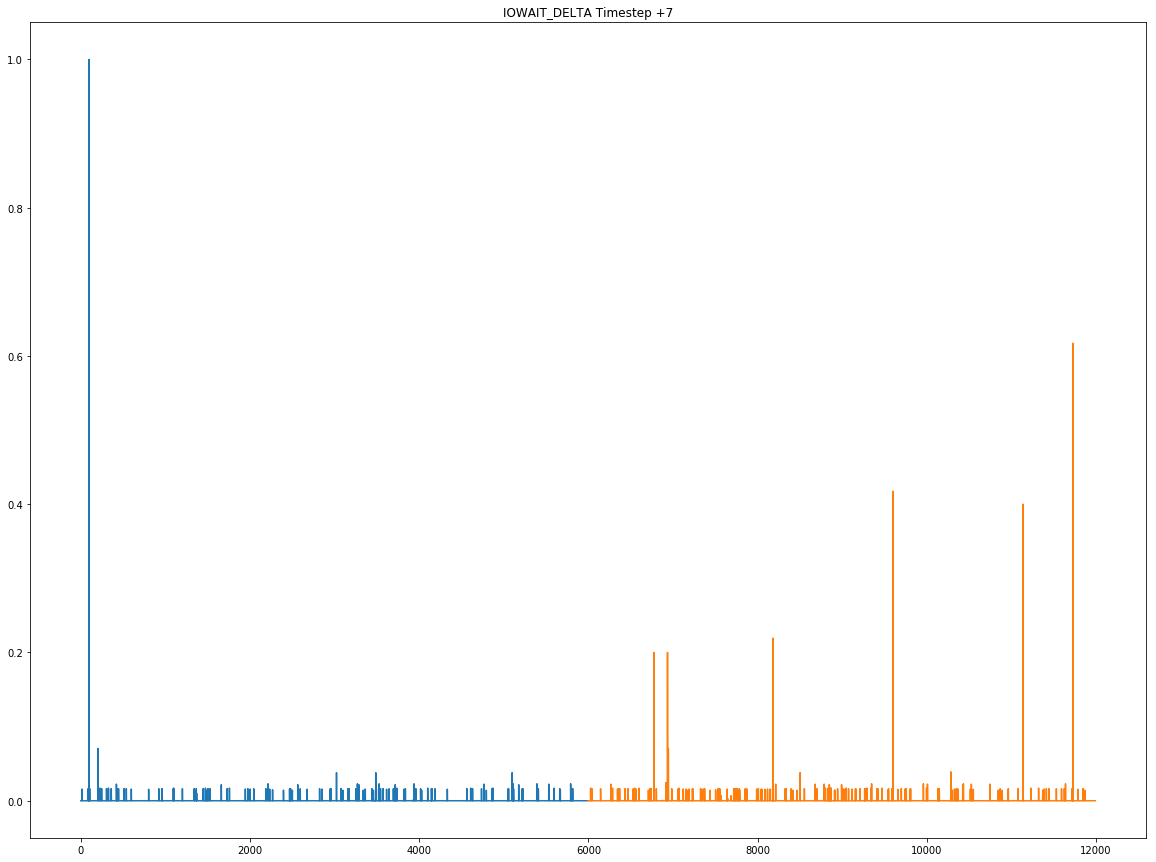

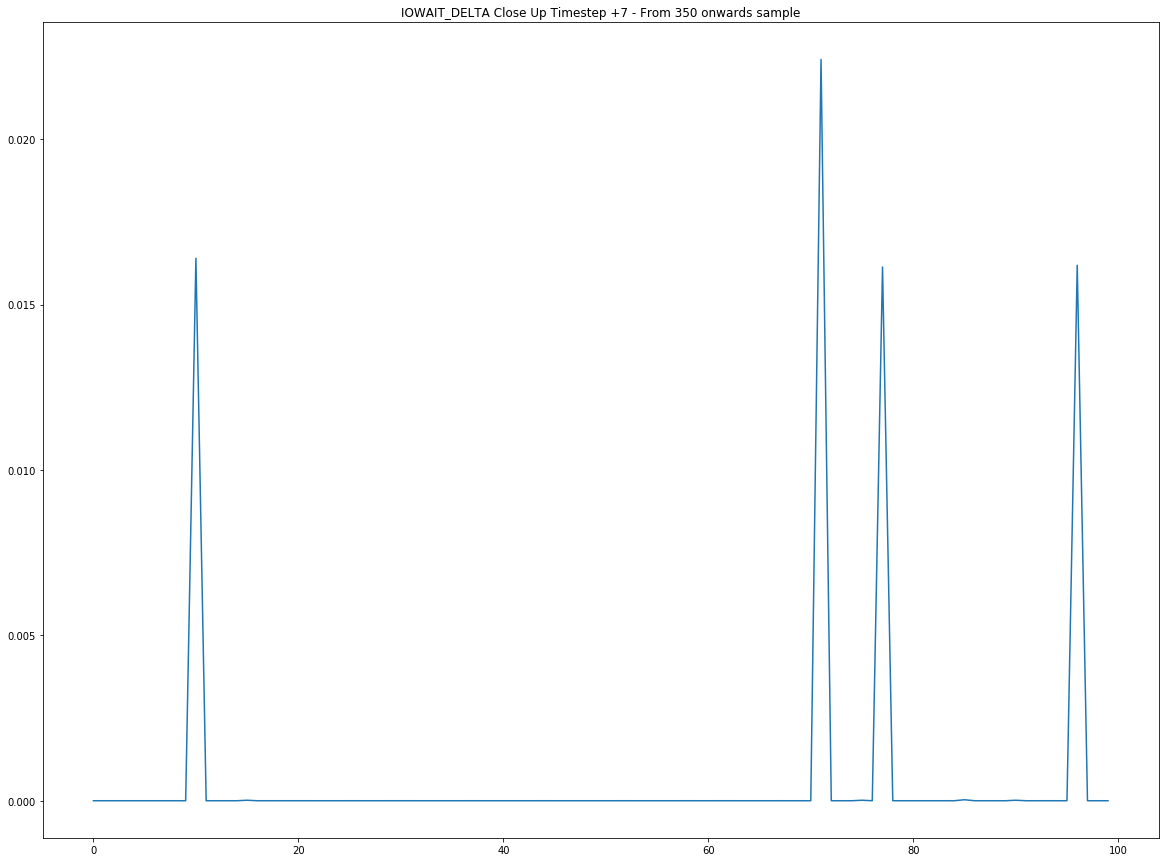

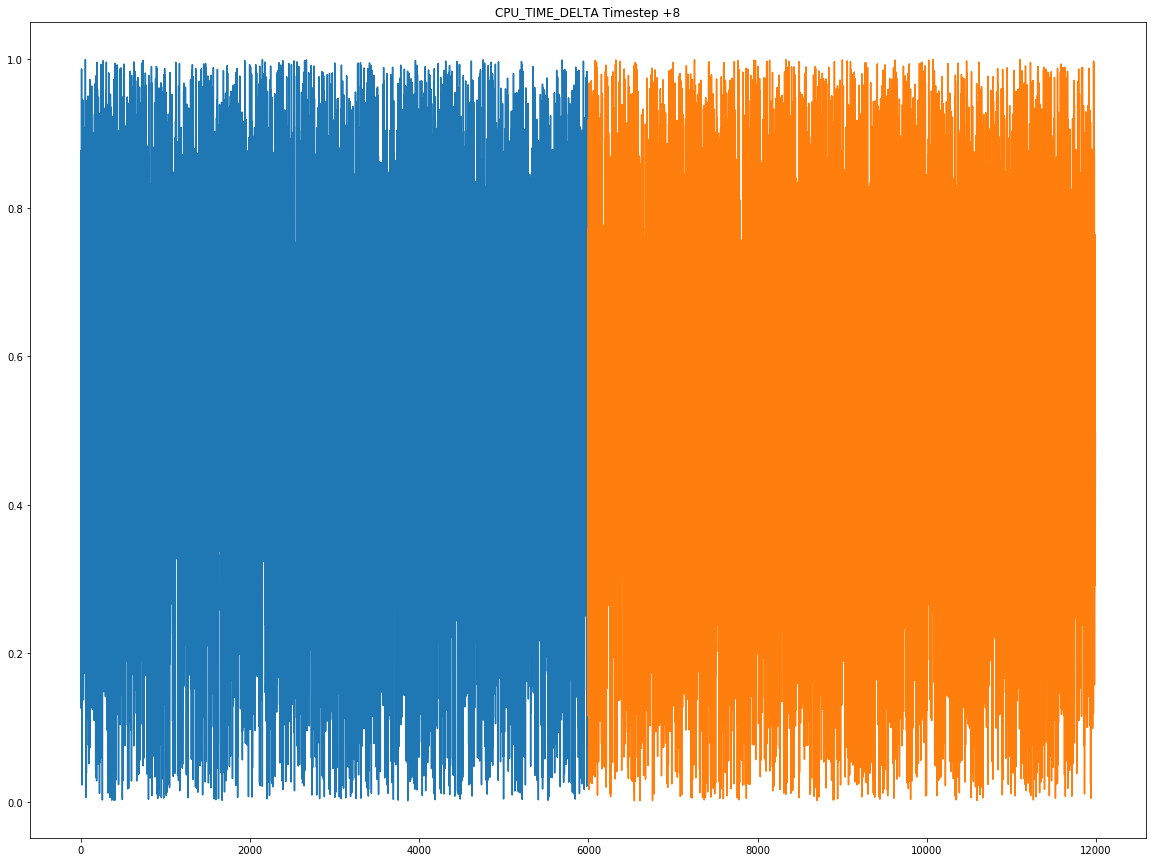

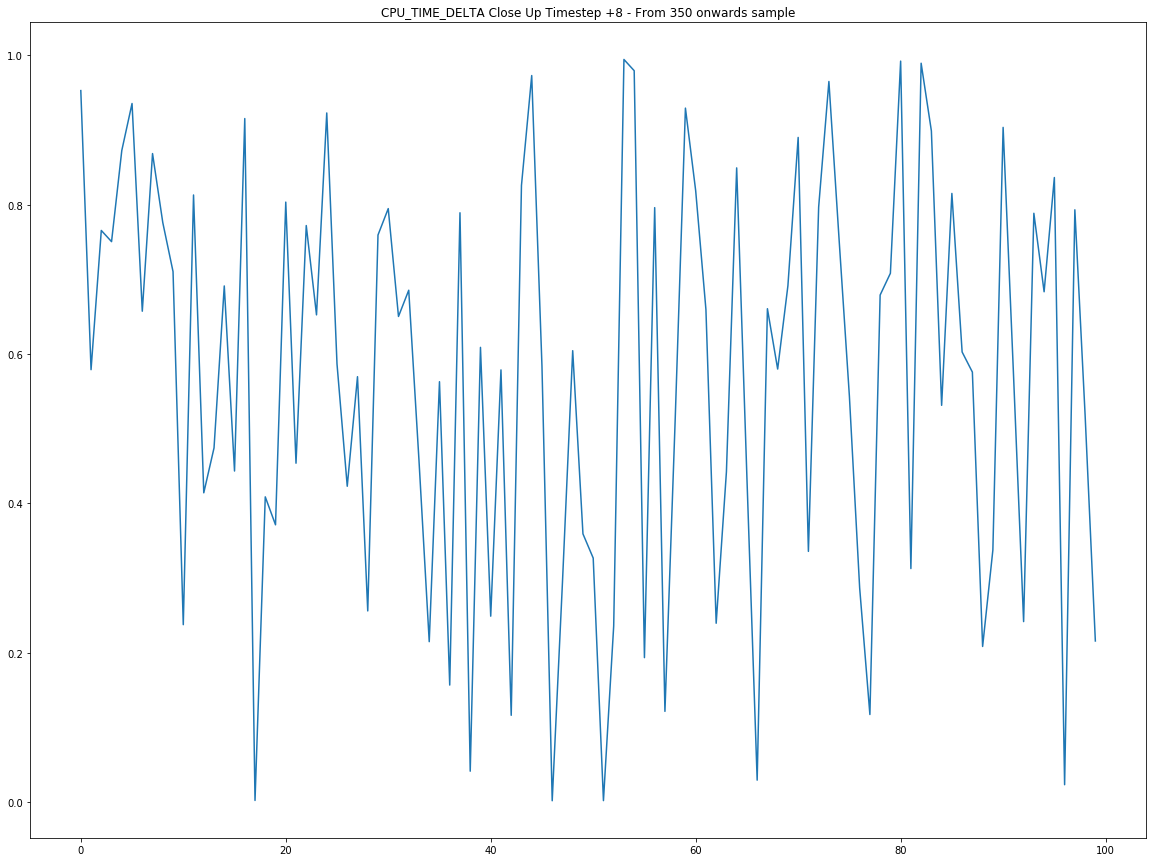

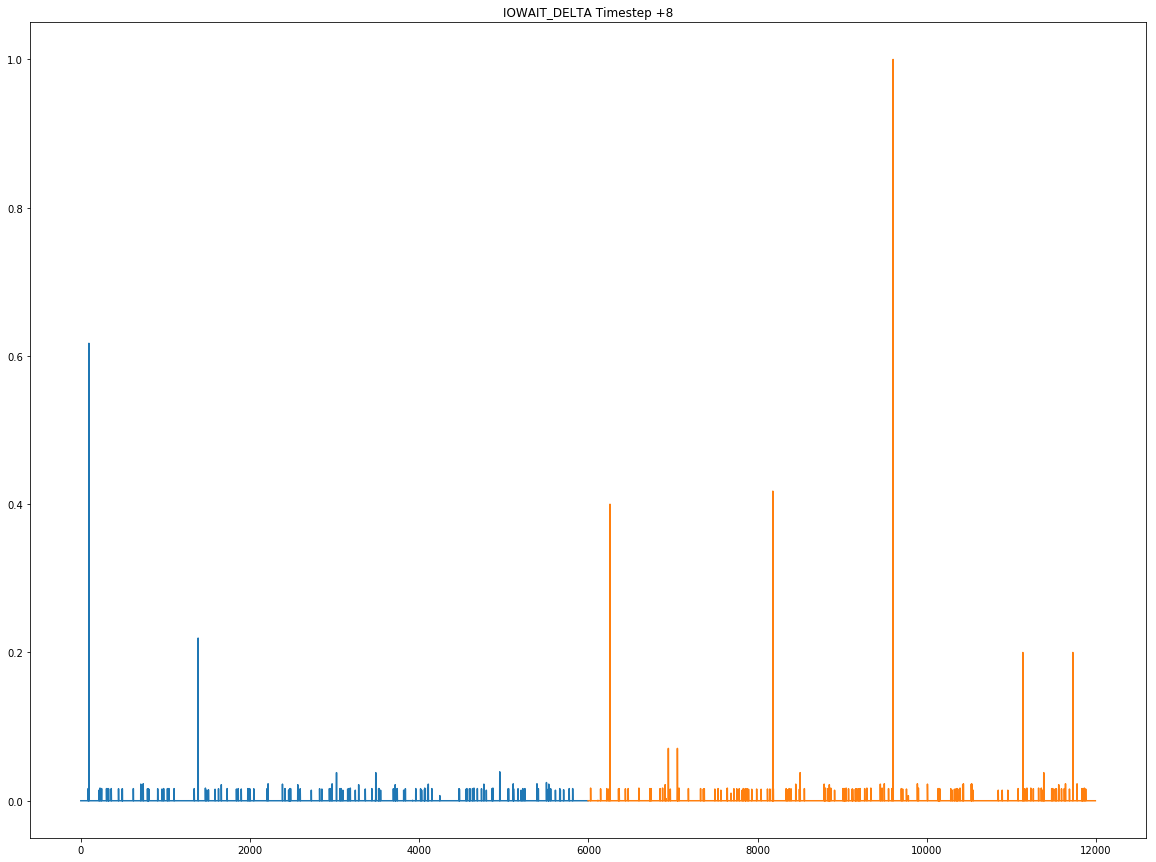

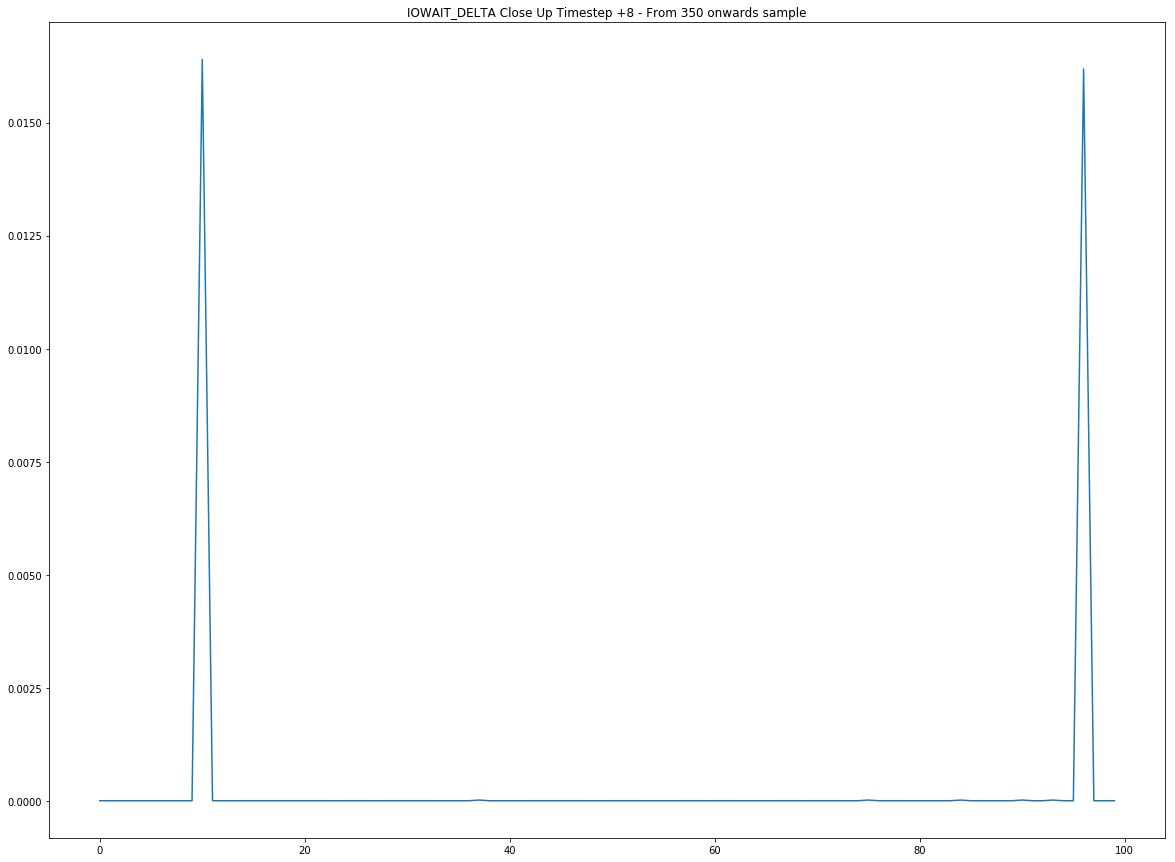

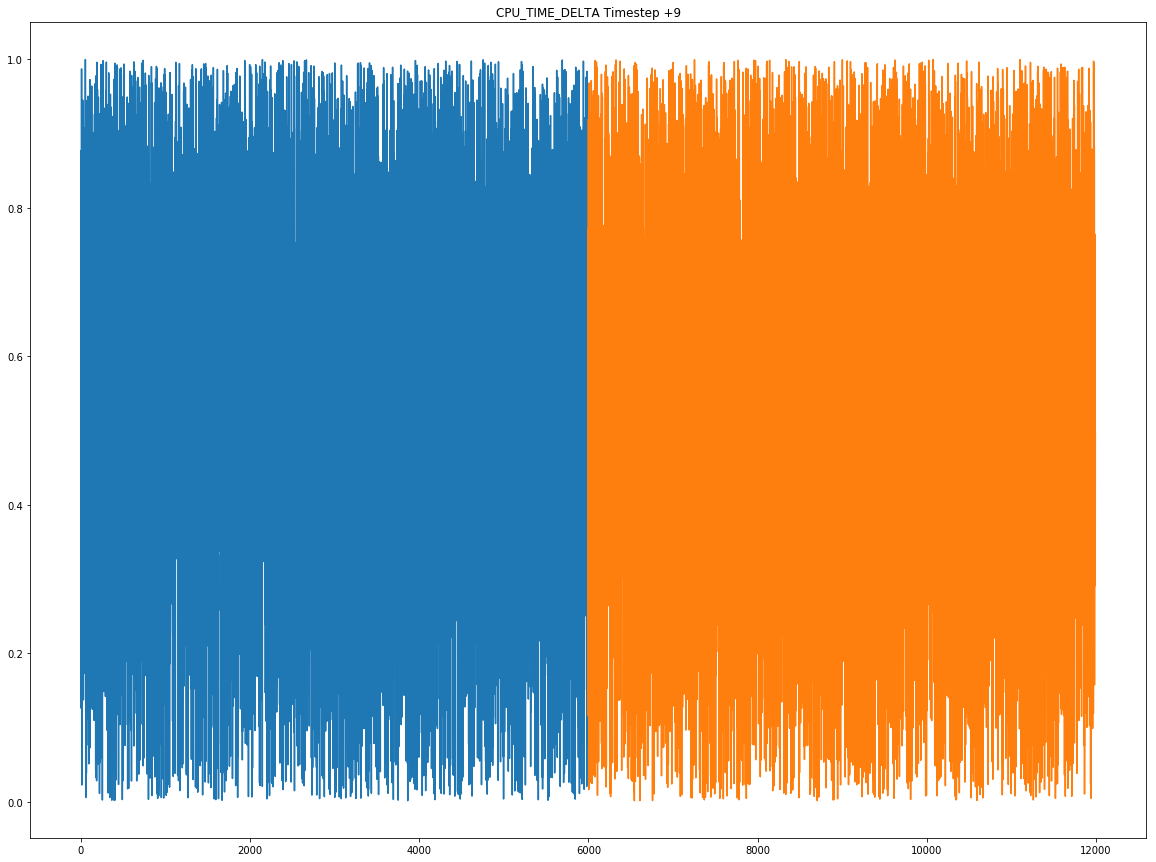

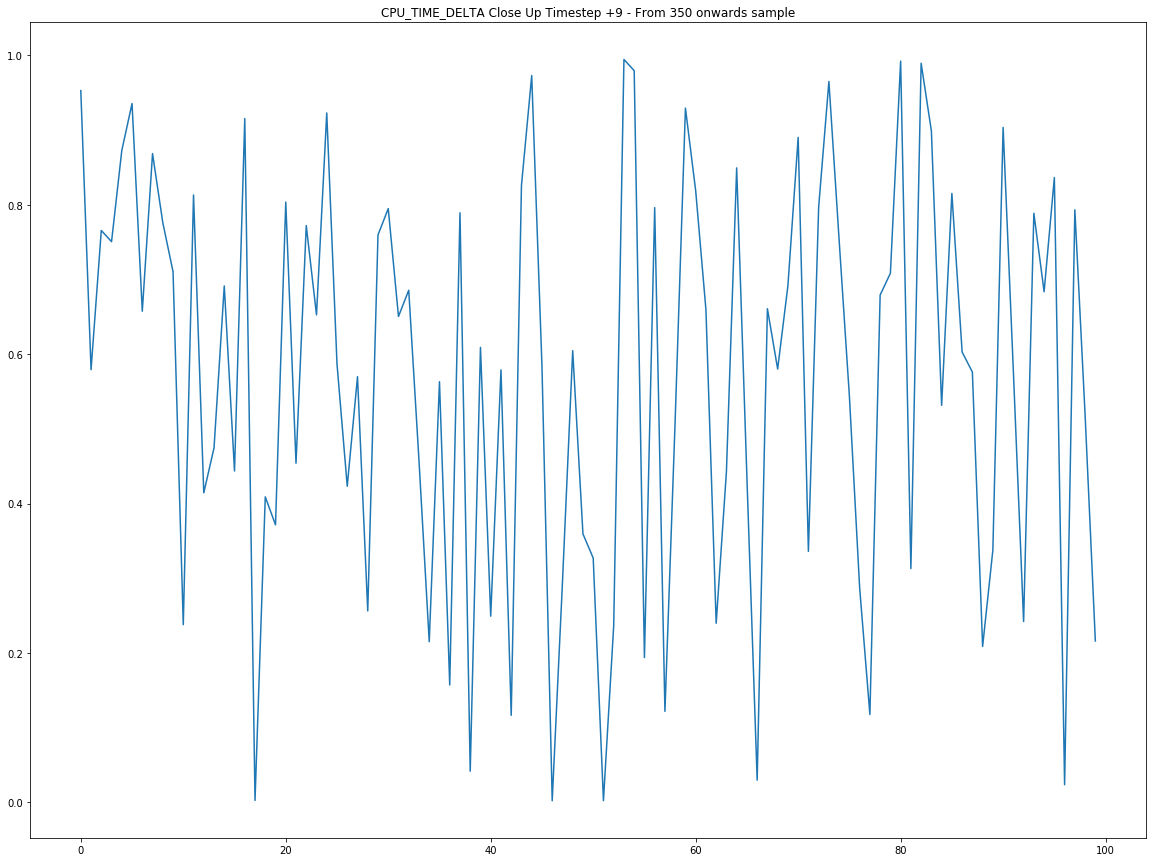

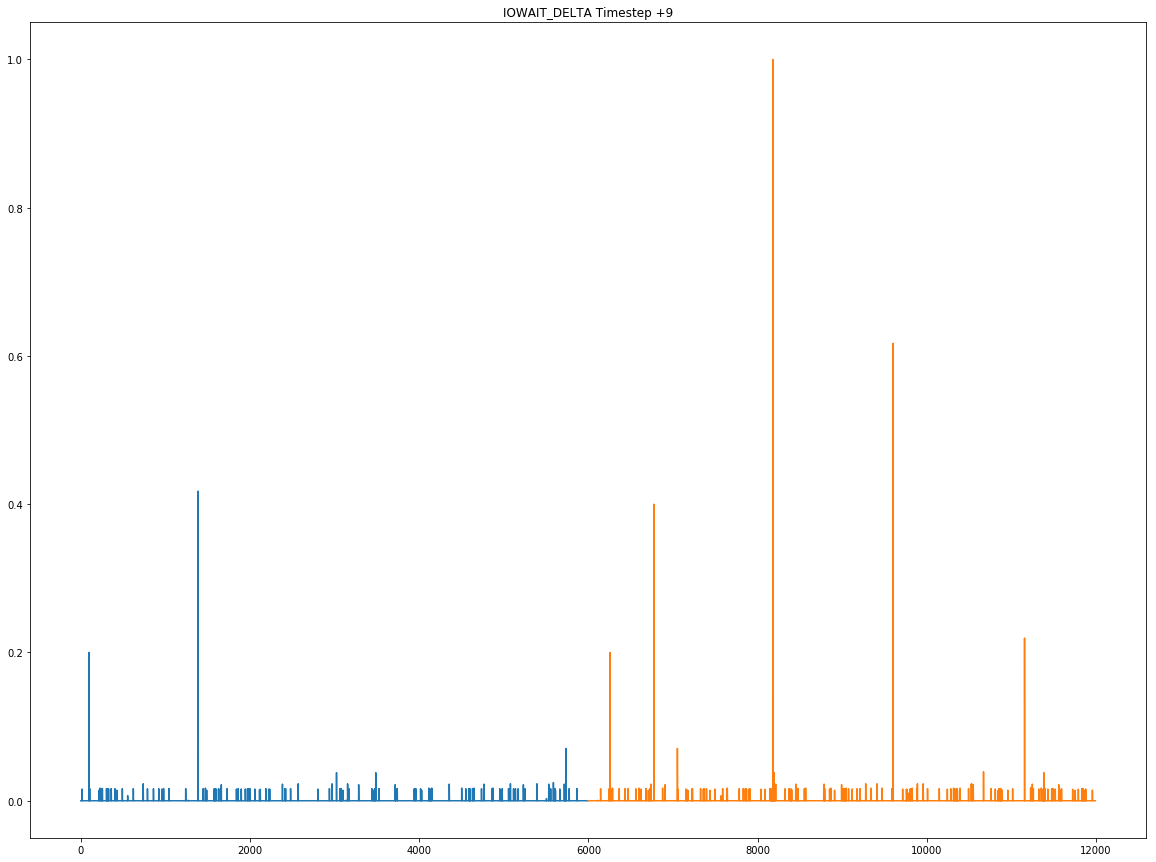

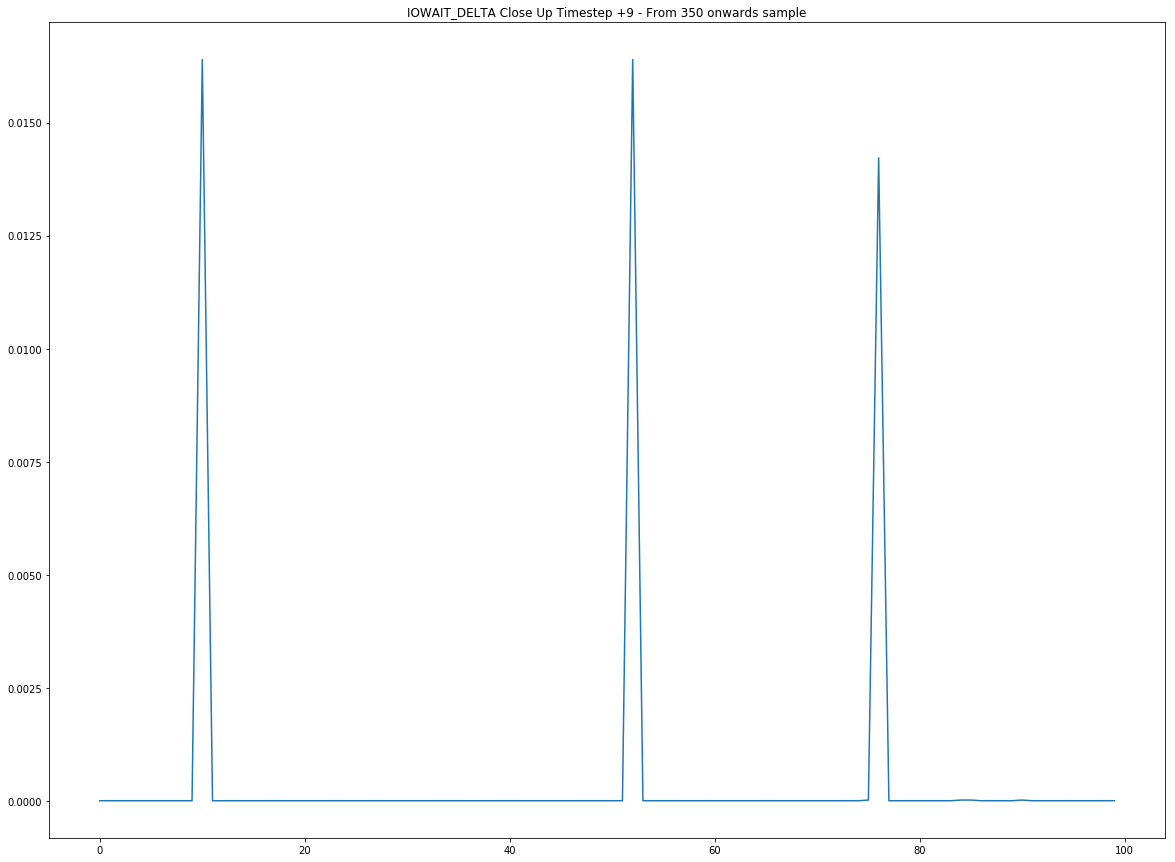

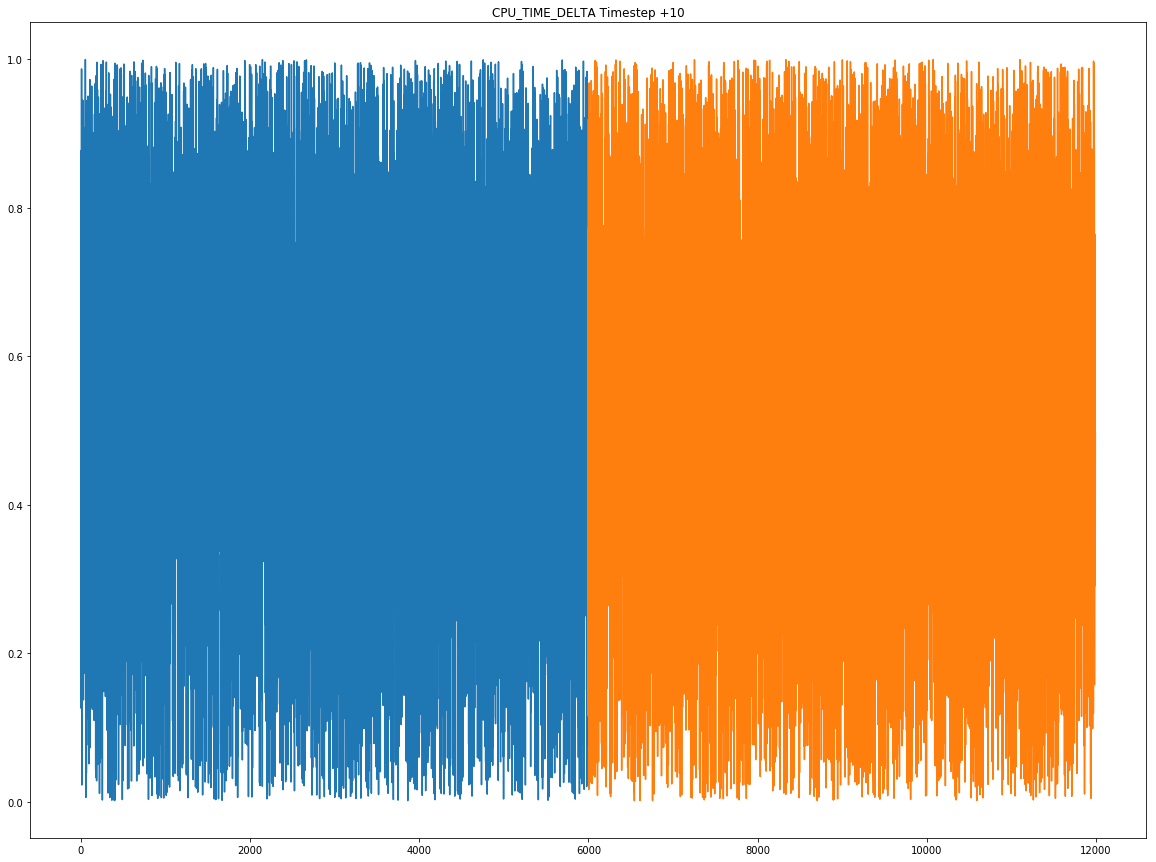

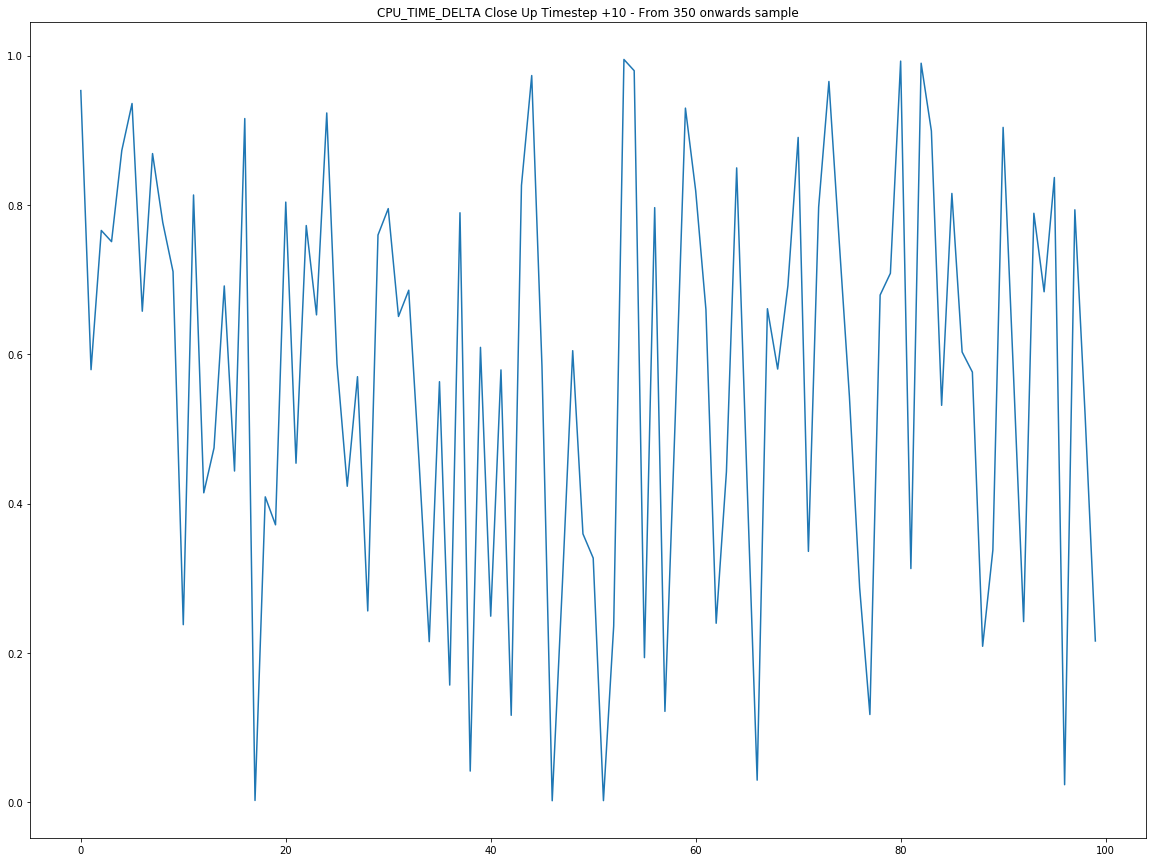

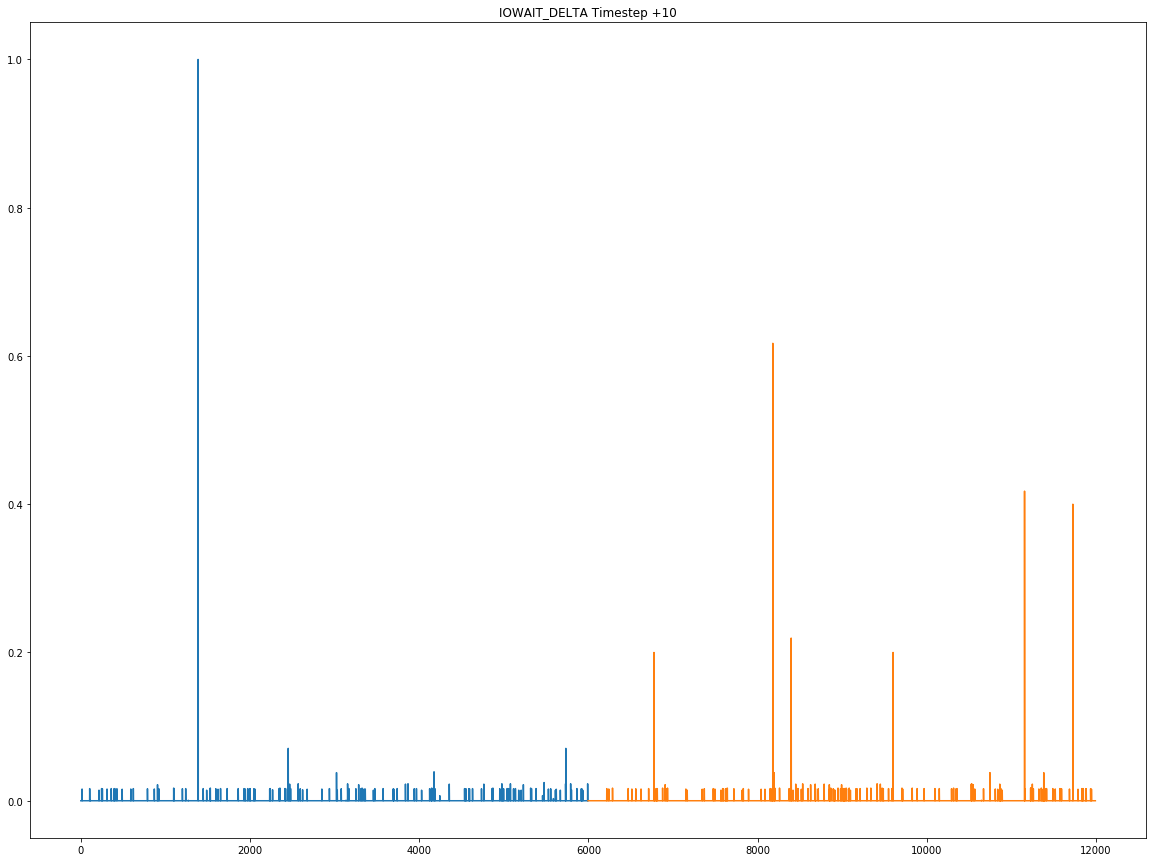

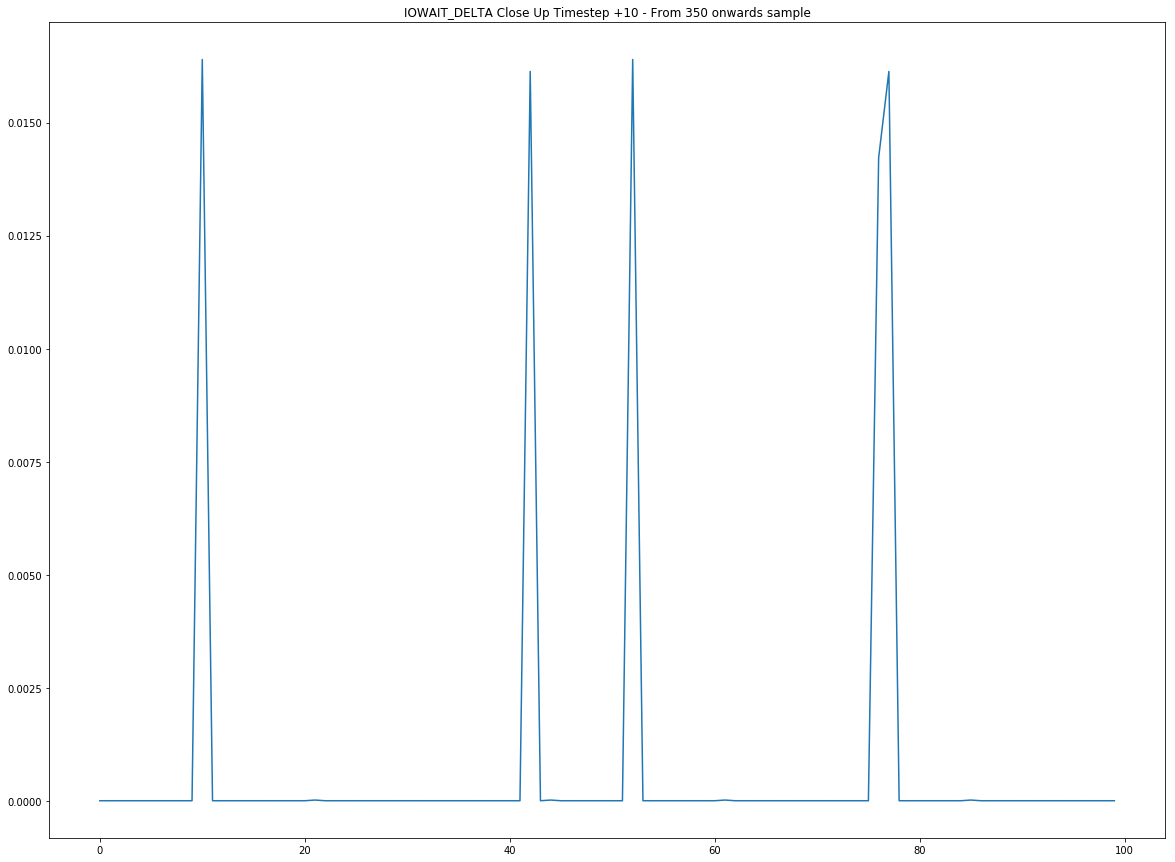

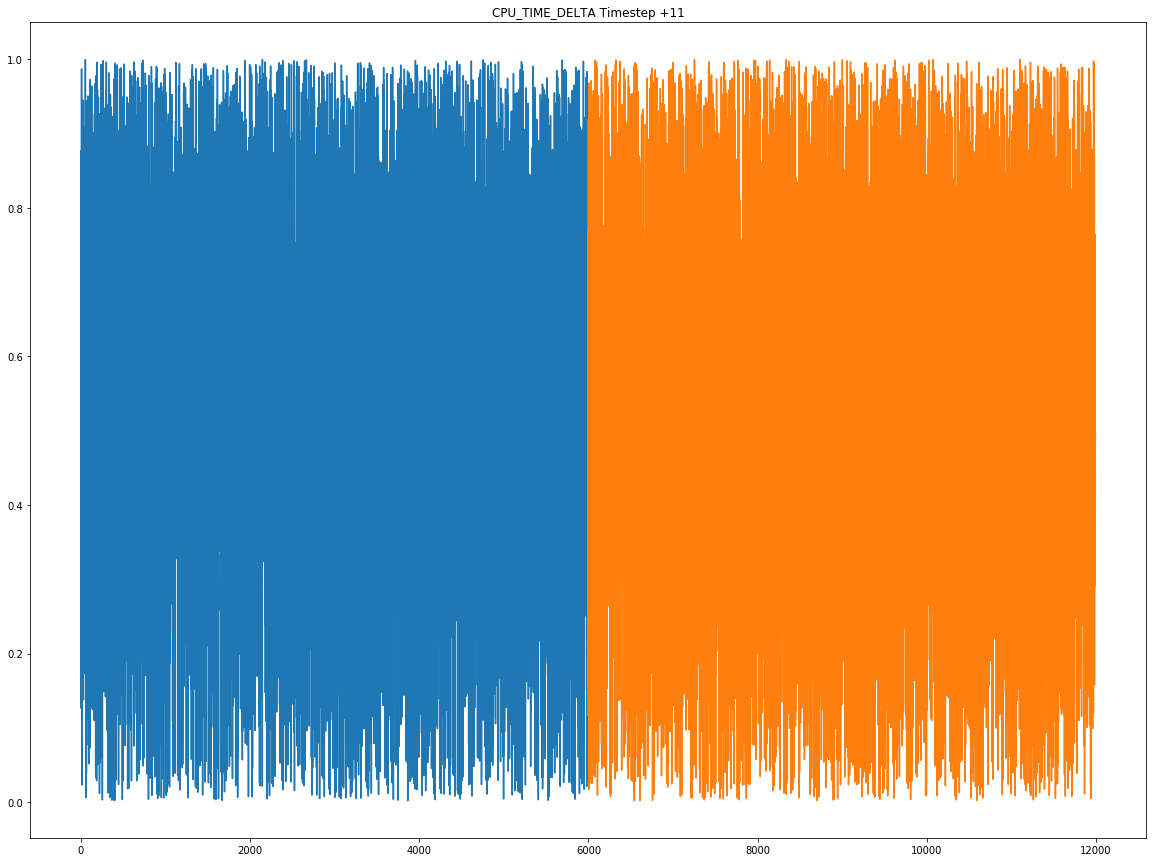

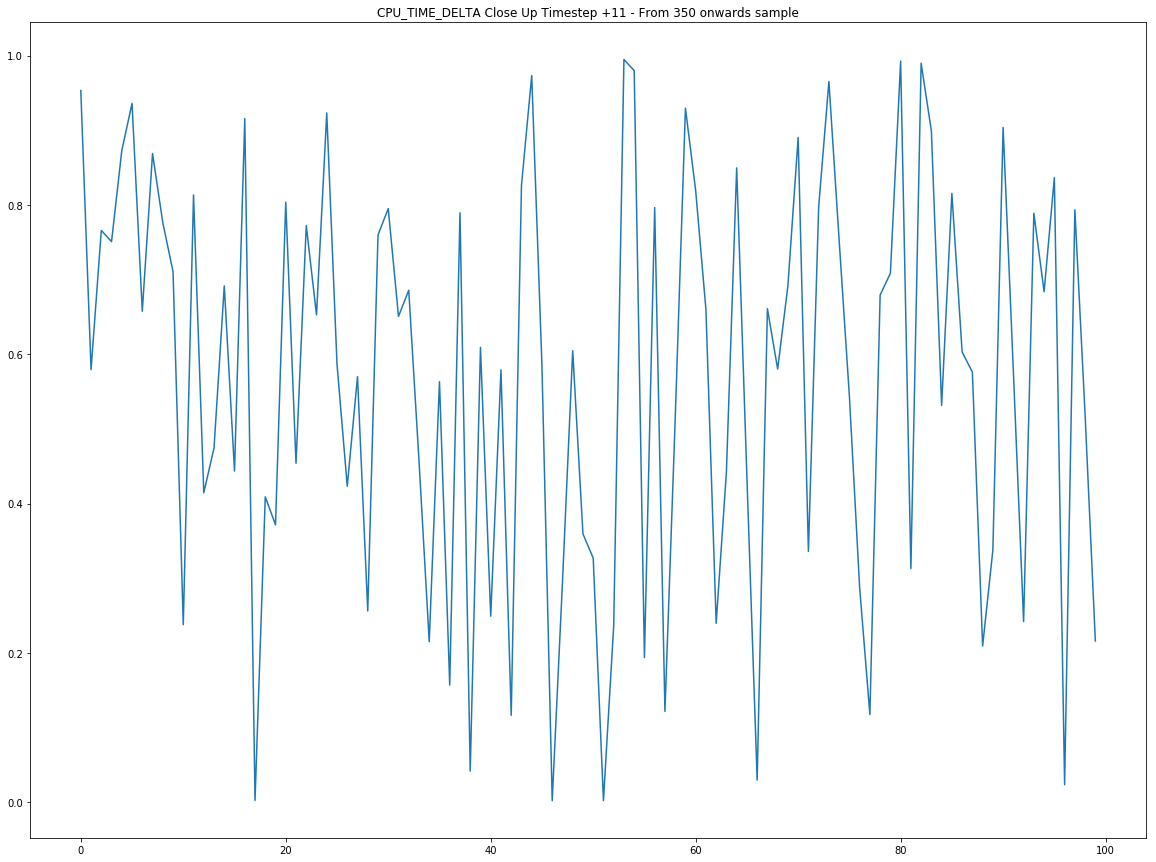

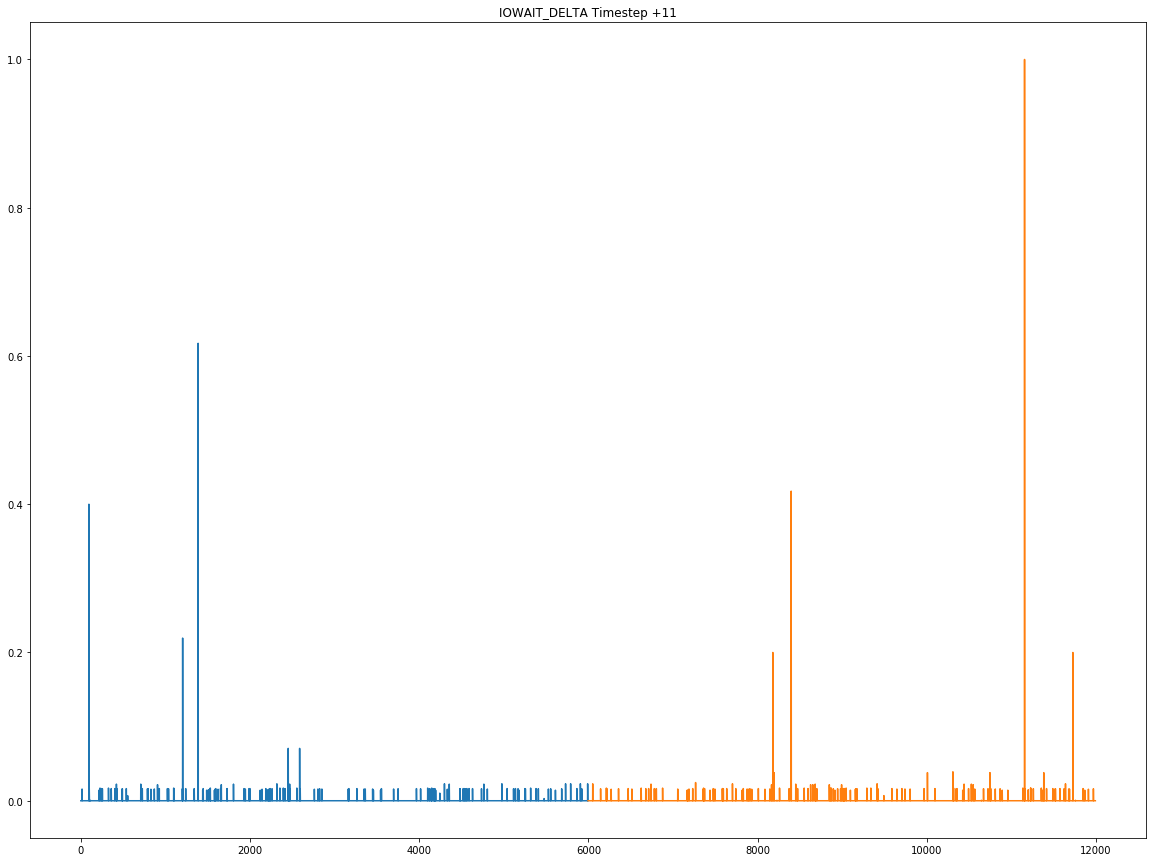

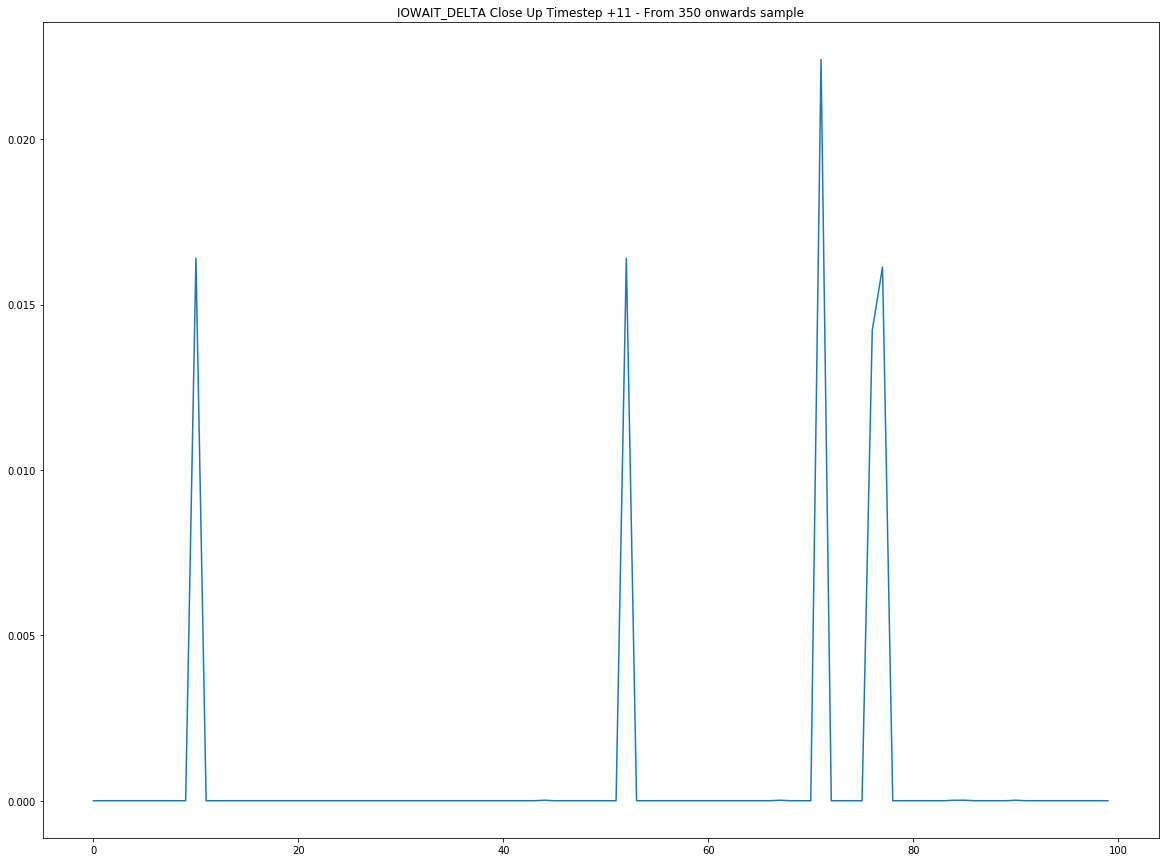

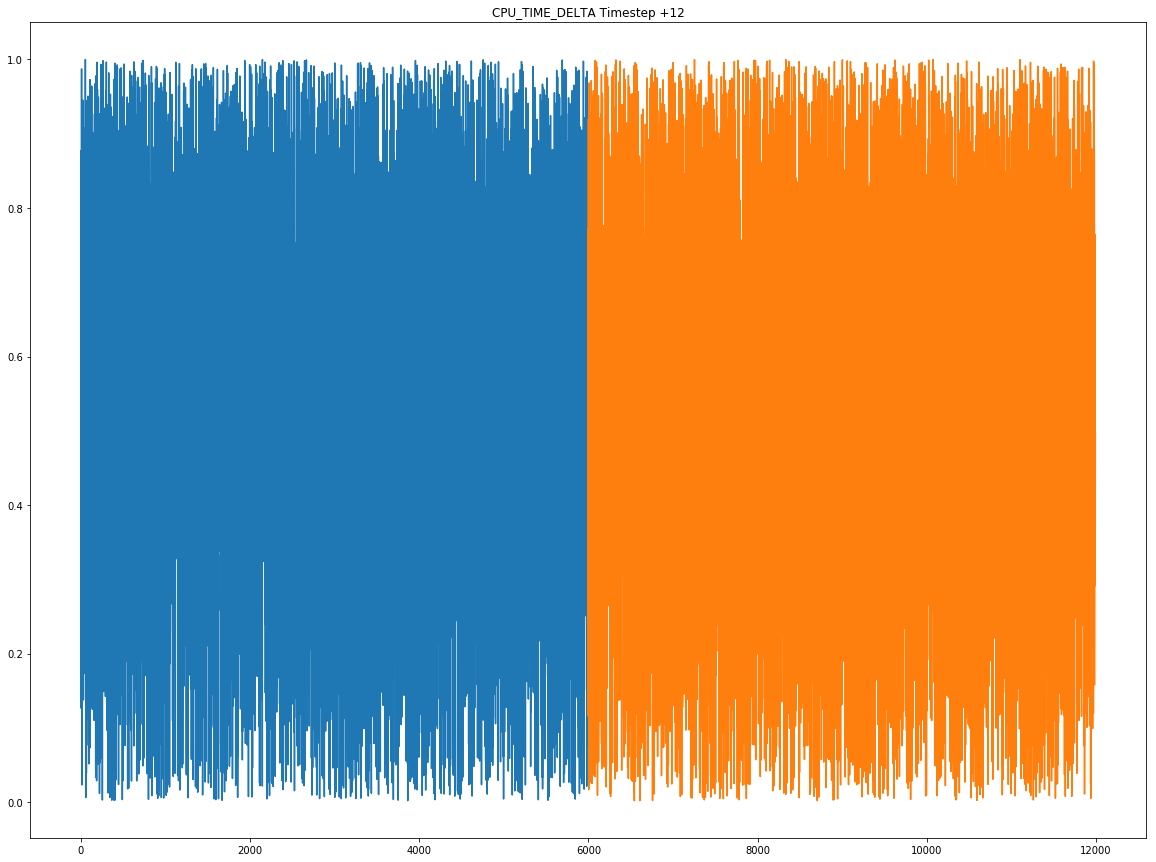

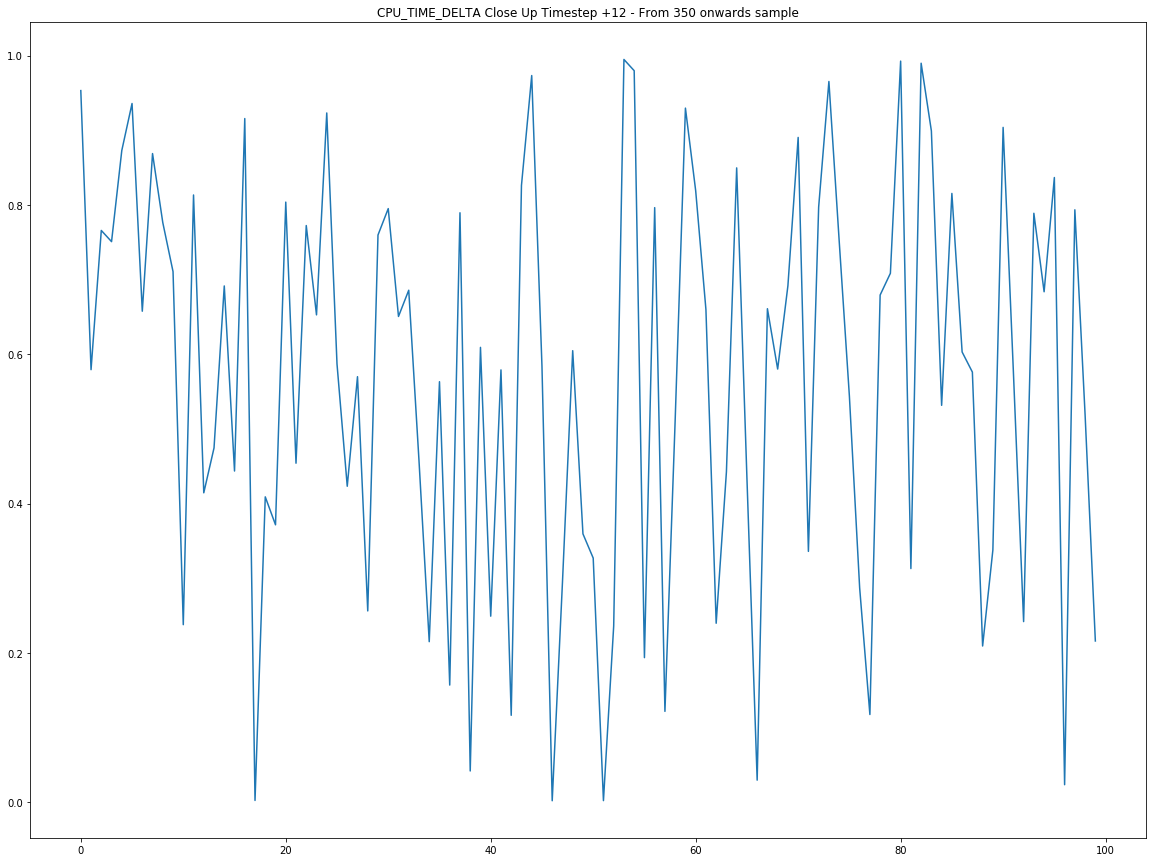

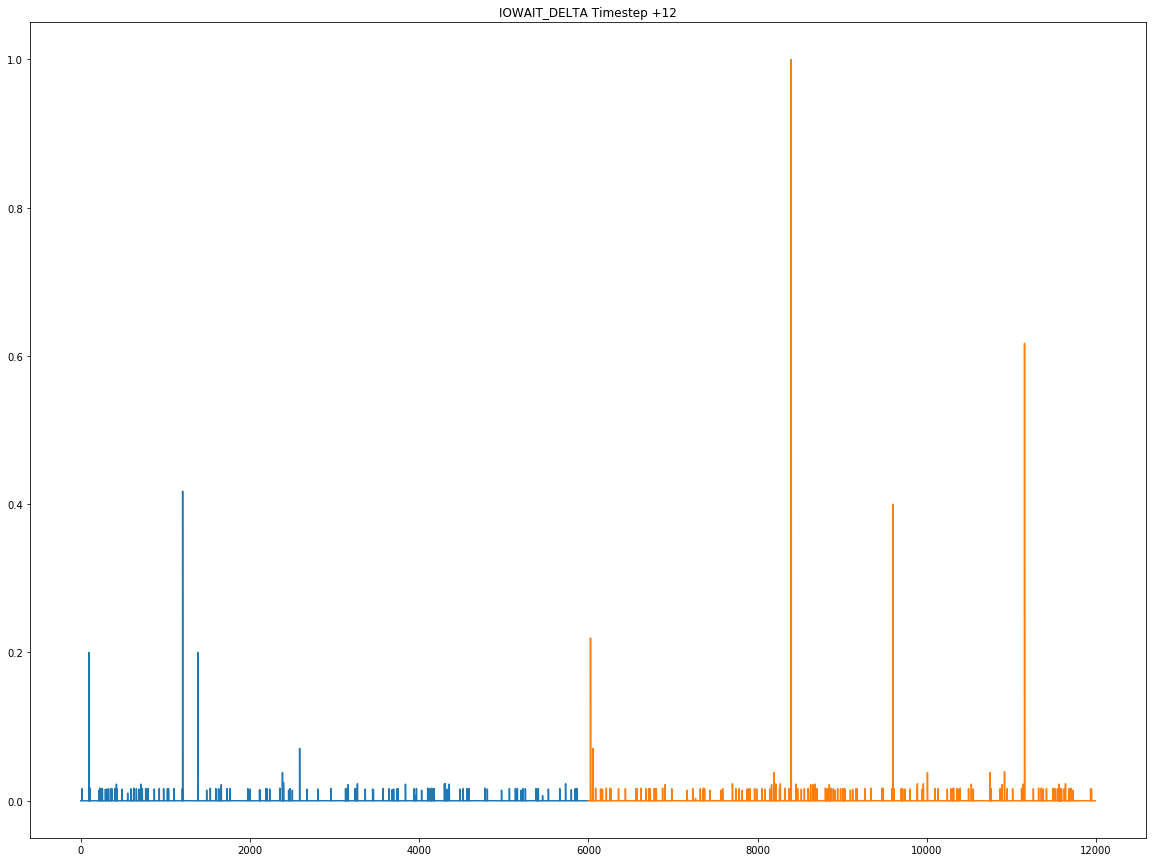

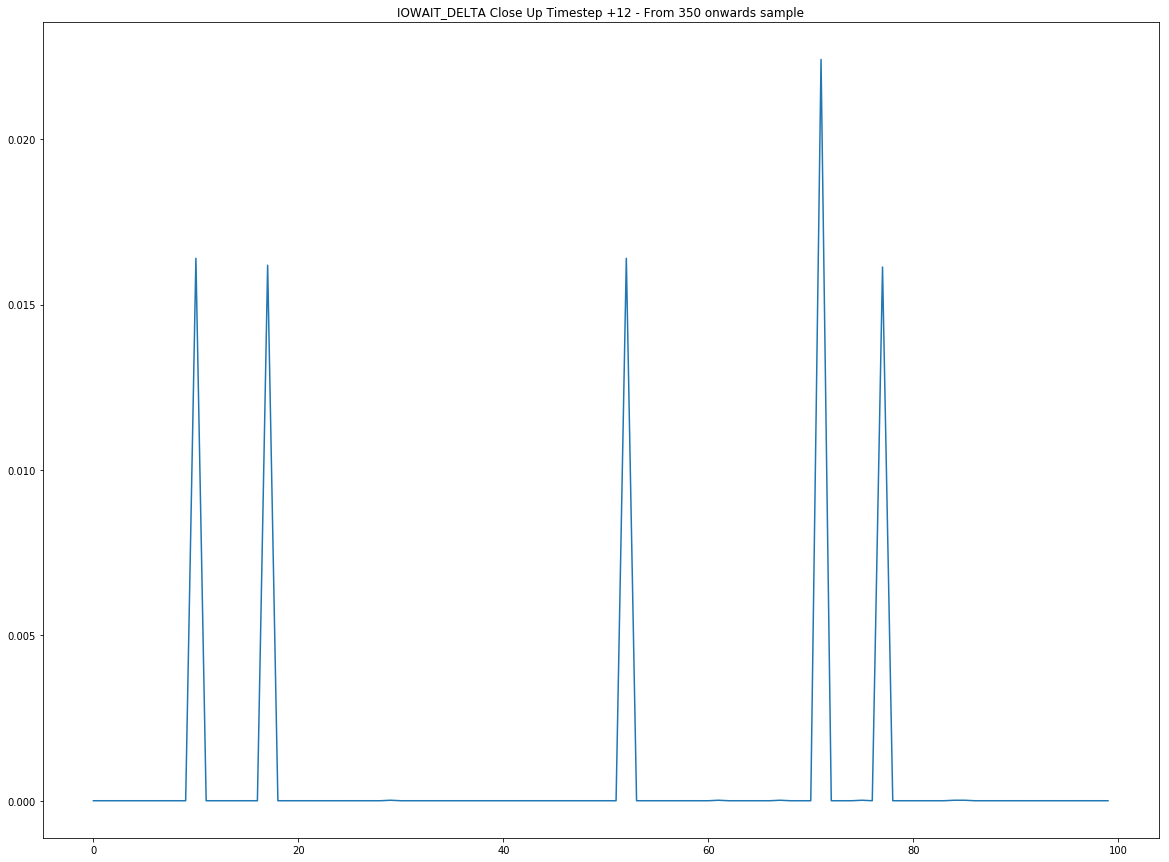

In [50]:
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))

X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, test_size=.5)
X_validate = X_validate.values
X_test = X_test.values
y_validate = y_validate.values
y_test = y_test.values
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
print("X_test shape [" + str(X_test.shape) + "] Type - " + str(type(X_test)))
print("y_test shape [" + str(y_test.shape) + "] Type - " + str(type(y_test)))

# Plotting label over time for train, test
# print(y_train)
# print(y_train[:,0])
for i in range(0, len(y_validate[0])):
    
    # Whole Sample
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.plot(y_train[:,i])
    validate_and_test = list(y_validate[:,i]) + list(y_test[:,i])
    plt.plot([None for j in y_train[:,i]] + [x for x in validate_and_test])
    plt.title(y_label[i%len(y_label)] + " Timestep +" + str(math.ceil((i+1)/len(y_label))))
    plt.show()
    
    # Sub-Sample (100 range)
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.plot([j for j in y_train[sub_sample_start:sub_sample_start+100,i]])
    plt.title(y_label[i%len(y_label)] + " Close Up Timestep +" + str(math.ceil((i+1)/len(y_label))) +" - From " + str(sub_sample_start) + " onwards sample")
    plt.show()

### Feature Selection

Implements a recursive solution, where in features are eliminated based on an ensemble evaluator.

In [51]:
class FeatureEliminator:
    """
    This class is dedicated to housing logic pertaining to feature selection - retaining only labels which are considered
    important.
    """
    def __init__(self, X_df, y_df):
        """
        Class constructor.
        :param X_df: (Pandas) Pandas feature matrix.
        :param y_df: (Pandas) Pandas label matrix.
        :return: None
        """
        self.__X_df = X_df
        self.__y_df = y_df
    
    def rfe_selector(self, test_split=.4, optimum_feature_count=0, parallel_degree=1, max_depth=None, max_features='sqrt', n_estimators=100):
        """
        Recursive Feature Elimination Function. Isolates and eliminated features one by one, up till the desired amount, starting
        by features which are considered less important.
        :param test_split:            (Float) Denotes training/testing data split.
        :param optimum_feature_count: (Integer) Denotes the best estimated number of features to retain before a performance drop
                                                is estimated.
        :param parallel_degree:       (Integer) Denotes model training parallel degree.
        :param max_depth:             (Integer) Denotes number of leaves to evaluate during decision tree pruning.
        :param max_features:          (Integer) Denotes number of features to consider during random subselection.
        :param n_estimators:          (Integer) Number of estimators (trees) to build for decision making.
        :return: (List) This list is composed of boolean values, which correspond to the input feature column headers. True List 
                        values denote columns which have been retained. False values denote eliminated feature headers.
        :return: (List) This list denotes feature rankings, which correspond to the input feature column headers. Values of '1',
                        denote that features have been retained.
        """
        X_df = self.__X_df.values
        y_df = self.__y_df[self.__y_df.columns[0]].values  # We can only use a single target column since RandomForests do not support multi target labels
        print(X_df.shape)
        print(y_df.shape)
        optimum_feature_count = int(optimum_feature_count)
        
        X_train, X_test, y_train, y_test = train_test_split(X_df, 
                                                            y_df, 
                                                            test_size=test_split)
        model = RandomForestRegressor(n_estimators=int(n_estimators), 
                                      n_jobs=parallel_degree,
                                      max_depth=max_depth,
                                      max_features='sqrt')

        # create the RFE model and select N attributes
        rfe_model = RFE(model, optimum_feature_count, step=1)
        rfe_model = rfe_model.fit(X_train, y_train)

        # summarize the selection of the attributes
        print(rfe_model.support_)
        print(rfe_model.ranking_)

        # evaluate the model on testing set
        pred_y = rfe_model.predict(X_test)
        predictions = [round(value) for value in pred_y]
        r2s = r2_score(y_test, predictions)
        
        return rfe_model.support_, rfe_model.ranking_
    
    def get_selected_features(self, column_mask):
        """
        Retrieves features which have not been eliminated from the RFE function.
        :param column_mask: (List) This list is composed of boolean values, which correspond to the input feature column headers. 
                                   True list values denote columns which have been retained. False values denote eliminated 
                                   feature headers. 
        :return: (Pandas) Pandas data matrix.
        """
        recommended_columns = []
        for i in range(len(self.__X_df.columns)):
            if (column_mask[i]):
                recommended_columns.append(self.__X_df.columns[i])
                
        return self.__X_df[recommended_columns]
    
# fe = FeatureEliminator(X_df=X_df,
#                        y_df=y_df)
# column_mask, column_rankings = fe.rfe_selector(test_split=test_split,
#                                                optimum_feature_count=int(X_df.shape[1]/8),
#                                                parallel_degree=2,
#                                                max_depth=1,
#                                                max_features='sqrt',
#                                                n_estimators=n_estimators)
# print(X_df.columns)
# X_df = fe.get_selected_features(column_mask=column_mask)
# print(X_df.columns)
recursively_eliminated_columns = ['var120(t-4)', 'var121(t-4)', 'var122(t-4)', 'var128(t-4)', 'var129(t-4)', 'var130(t-4)', 'var131(t-4)', 'var132(t-4)', 'var133(t-4)', 'var134(t-4)', 'var135(t-4)', 'var136(t-4)', 'var137(t-4)', 'var138(t-4)', 'var139(t-4)', 'var140(t-4)', 'var141(t-4)', 'var142(t-4)', 'var143(t-4)', 'var144(t-4)', 'var145(t-4)', 'var146(t-4)', 'var147(t-4)', 'var148(t-4)', 'var149(t-4)', 'var150(t-4)', 'var151(t-4)', 'var152(t-4)', 'var153(t-4)', 'var154(t-4)', 'var155(t-4)', 'var156(t-4)', 'var157(t-4)', 'var158(t-4)', 'var159(t-4)', 'var160(t-4)', 'var161(t-4)', 'var162(t-4)', 'var163(t-4)', 'var164(t-4)', 'var165(t-4)', 'var166(t-4)', 'var167(t-4)', 'var168(t-4)', 'var169(t-4)', 'var170(t-4)', 'var171(t-4)', 'var172(t-4)', 'var173(t-4)', 'var174(t-4)', 'var175(t-4)', 'var176(t-4)', 'var177(t-4)', 'var178(t-4)', 'var179(t-4)', 'var180(t-4)', 'var181(t-4)', 'var182(t-4)', 'var183(t-4)', 'var184(t-4)', 'var185(t-4)', 'var186(t-4)', 'var187(t-4)', 'var188(t-4)', 'var189(t-4)', 'var190(t-4)', 'var192(t-4)', 'var193(t-4)', 'var194(t-4)', 'var195(t-4)', 'var196(t-4)', 'var197(t-4)', 'var198(t-4)', 'var199(t-4)', 'var200(t-4)', 'var201(t-4)', 'var202(t-4)', 'var203(t-4)', 'var204(t-4)', 'var205(t-4)', 'var206(t-4)', 'var207(t-4)', 'var208(t-4)', 'var209(t-4)', 'var210(t-4)', 'var211(t-4)', 'var212(t-4)', 'var213(t-4)', 'var214(t-4)', 'var215(t-4)', 'var216(t-4)', 'var217(t-4)', 'var218(t-4)', 'var219(t-4)', 'var220(t-4)', 'var221(t-4)', 'var222(t-4)', 'var223(t-4)', 'var227(t-4)', 'var228(t-4)', 'var229(t-4)', 'var233(t-4)', 'var234(t-4)', 'var236(t-4)', 'var237(t-4)', 'var238(t-4)', 'var239(t-4)', 'var240(t-4)', 'var241(t-4)', 'var243(t-4)', 'var244(t-4)', 'var245(t-4)', 'var246(t-4)', 'var247(t-4)', 'var248(t-4)', 'var251(t-4)', 'var252(t-4)', 'var253(t-4)', 'var255(t-4)', 'var257(t-4)', 'var261(t-4)', 'var262(t-4)', 'var265(t-4)', 'var267(t-4)', 'var268(t-4)', 'var269(t-4)', 'var270(t-4)', 'var271(t-4)', 'var273(t-4)', 'var274(t-4)', 'var277(t-4)', 'var279(t-4)', 'var280(t-4)', 'var285(t-4)', 'var286(t-4)', 'var290(t-4)', 'var293(t-4)', 'var294(t-4)', 'var295(t-4)', 'var297(t-4)', 'var298(t-4)', 'var299(t-4)', 'var300(t-4)', 'var310(t-4)', 'var311(t-4)', 'var312(t-4)', 'var313(t-4)', 'var315(t-4)', 'var317(t-4)', 'var318(t-4)', 'var319(t-4)', 'var320(t-4)', 'var321(t-4)', 'var323(t-4)', 'var324(t-4)', 'var325(t-4)', 'var326(t-4)', 'var327(t-4)', 'var328(t-4)', 'var329(t-4)', 'var330(t-4)', 'var331(t-4)', 'var332(t-4)', 'var333(t-4)', 'var336(t-4)', 'var337(t-4)', 'var338(t-4)', 'var339(t-4)', 'var340(t-4)', 'var341(t-4)', 'var343(t-4)', 'var348(t-4)', 'var351(t-4)', 'var352(t-4)', 'var353(t-4)', 'var354(t-4)', 'var362(t-4)', 'var363(t-4)', 'var364(t-4)', 'var365(t-4)', 'var366(t-4)', 'var367(t-4)', 'var368(t-4)', 'var370(t-4)', 'var374(t-4)', 'var375(t-4)', 'var377(t-4)', 'var378(t-4)', 'var379(t-4)', 'var380(t-4)', 'var381(t-4)', 'var382(t-4)', 'var385(t-4)', 'var386(t-4)', 'var388(t-4)', 'var389(t-4)', 'var390(t-4)', 'var391(t-4)', 'var393(t-4)', 'var394(t-4)', 'var395(t-4)', 'var396(t-4)', 'var397(t-4)', 'var398(t-4)', 'var399(t-4)', 'var400(t-4)', 'var401(t-4)', 'var403(t-4)', 'var404(t-4)', 'var405(t-4)', 'var406(t-4)', 'var407(t-4)', 'var409(t-4)', 'var410(t-4)', 'var411(t-4)', 'var412(t-4)', 'var413(t-4)', 'var415(t-4)', 'var416(t-4)', 'var417(t-4)', 'var418(t-4)', 'var427(t-4)', 'var428(t-4)', 'var429(t-4)', 'var430(t-4)', 'var431(t-4)', 'var432(t-4)', 'var433(t-4)', 'var434(t-4)', 'var435(t-4)', 'var436(t-4)', 'var437(t-4)', 'var438(t-4)', 'var439(t-4)', 'var440(t-4)', 'var441(t-4)', 'var442(t-4)', 'var443(t-4)', 'var444(t-4)', 'var445(t-4)', 'var446(t-4)', 'var447(t-4)', 'var448(t-4)', 'var449(t-4)', 'var450(t-4)', 'var451(t-4)', 'var452(t-4)', 'var453(t-4)', 'var454(t-4)', 'var455(t-4)', 'var456(t-4)', 'var457(t-4)', 'var458(t-4)', 'var459(t-4)', 'var460(t-4)', 'var461(t-4)', 'var462(t-4)', 'var463(t-4)', 'var464(t-4)', 'var465(t-4)', 'var466(t-4)', 'var467(t-4)', 'var468(t-4)', 'var469(t-4)', 'var470(t-4)', 'var471(t-4)', 'var472(t-4)', 'var473(t-4)', 'var474(t-4)', 'var475(t-4)', 'var476(t-4)', 'var477(t-4)', 'var479(t-4)', 'var480(t-4)', 'var481(t-4)', 'var482(t-4)', 'var483(t-4)', 'var484(t-4)', 'var485(t-4)', 'var486(t-4)', 'var487(t-4)', 'var488(t-4)', 'var490(t-4)', 'var491(t-4)', 'var492(t-4)', 'var493(t-4)', 'var494(t-4)', 'var495(t-4)', 'var496(t-4)', 'var497(t-4)', 'var498(t-4)', 'var499(t-4)', 'var500(t-4)', 'var501(t-4)', 'var502(t-4)', 'var503(t-4)', 'var504(t-4)', 'var505(t-4)', 'var506(t-4)', 'var507(t-4)', 'var508(t-4)', 'var509(t-4)', 'var510(t-4)', 'var511(t-4)', 'var512(t-4)', 'var513(t-4)', 'var514(t-4)', 'var515(t-4)', 'var516(t-4)', 'var517(t-4)', 'var518(t-4)', 'var519(t-4)', 'var520(t-4)', 'var521(t-4)', 'var522(t-4)', 'var523(t-4)', 'var524(t-4)', 'var525(t-4)', 'var526(t-4)', 'var1(t-3)', 'var2(t-3)', 'var4(t-3)', 'var5(t-3)', 'var8(t-3)', 'var9(t-3)', 'var10(t-3)', 'var12(t-3)', 'var13(t-3)', 'var15(t-3)', 'var19(t-3)', 'var20(t-3)', 'var21(t-3)', 'var22(t-3)', 'var28(t-3)', 'var29(t-3)', 'var38(t-3)', 'var40(t-3)', 'var41(t-3)', 'var42(t-3)', 'var43(t-3)', 'var44(t-3)', 'var45(t-3)', 'var46(t-3)', 'var47(t-3)', 'var49(t-3)', 'var50(t-3)', 'var51(t-3)', 'var53(t-3)', 'var54(t-3)', 'var56(t-3)', 'var59(t-3)', 'var60(t-3)', 'var61(t-3)', 'var62(t-3)', 'var63(t-3)', 'var64(t-3)', 'var74(t-3)', 'var75(t-3)', 'var78(t-3)', 'var79(t-3)', 'var81(t-3)', 'var83(t-3)', 'var85(t-3)', 'var86(t-3)', 'var88(t-3)', 'var89(t-3)', 'var91(t-3)', 'var92(t-3)', 'var93(t-3)', 'var94(t-3)', 'var95(t-3)', 'var96(t-3)', 'var97(t-3)', 'var99(t-3)', 'var102(t-3)', 'var103(t-3)', 'var104(t-3)', 'var106(t-3)', 'var111(t-3)', 'var114(t-3)', 'var124(t-3)', 'var125(t-3)', 'var130(t-3)', 'var131(t-3)', 'var132(t-3)', 'var133(t-3)', 'var134(t-3)', 'var148(t-3)', 'var152(t-3)', 'var154(t-3)', 'var156(t-3)', 'var163(t-3)', 'var164(t-3)', 'var166(t-3)', 'var171(t-3)', 'var172(t-3)', 'var174(t-3)', 'var175(t-3)', 'var176(t-3)', 'var178(t-3)', 'var180(t-3)', 'var181(t-3)', 'var183(t-3)', 'var184(t-3)', 'var185(t-3)', 'var186(t-3)', 'var187(t-3)', 'var188(t-3)', 'var189(t-3)', 'var191(t-3)', 'var192(t-3)', 'var193(t-3)', 'var196(t-3)', 'var197(t-3)', 'var201(t-3)', 'var203(t-3)', 'var204(t-3)', 'var205(t-3)', 'var206(t-3)', 'var207(t-3)', 'var208(t-3)', 'var209(t-3)', 'var210(t-3)', 'var211(t-3)', 'var215(t-3)', 'var216(t-3)', 'var217(t-3)', 'var218(t-3)', 'var219(t-3)', 'var220(t-3)', 'var221(t-3)', 'var222(t-3)', 'var223(t-3)', 'var224(t-3)', 'var225(t-3)', 'var226(t-3)', 'var227(t-3)', 'var228(t-3)', 'var229(t-3)', 'var230(t-3)', 'var231(t-3)', 'var232(t-3)', 'var233(t-3)', 'var234(t-3)', 'var235(t-3)', 'var236(t-3)', 'var237(t-3)', 'var238(t-3)', 'var239(t-3)', 'var240(t-3)', 'var241(t-3)', 'var242(t-3)', 'var243(t-3)', 'var244(t-3)', 'var245(t-3)', 'var246(t-3)', 'var247(t-3)', 'var248(t-3)', 'var249(t-3)', 'var250(t-3)', 'var251(t-3)', 'var252(t-3)', 'var253(t-3)', 'var254(t-3)', 'var255(t-3)', 'var256(t-3)', 'var257(t-3)', 'var258(t-3)', 'var259(t-3)', 'var260(t-3)', 'var261(t-3)', 'var262(t-3)', 'var263(t-3)', 'var264(t-3)', 'var265(t-3)', 'var266(t-3)', 'var267(t-3)', 'var268(t-3)', 'var269(t-3)', 'var270(t-3)', 'var271(t-3)', 'var272(t-3)', 'var273(t-3)', 'var274(t-3)', 'var275(t-3)', 'var276(t-3)', 'var277(t-3)', 'var278(t-3)', 'var279(t-3)', 'var280(t-3)', 'var281(t-3)', 'var283(t-3)', 'var284(t-3)', 'var285(t-3)', 'var286(t-3)', 'var287(t-3)', 'var288(t-3)', 'var289(t-3)', 'var290(t-3)', 'var291(t-3)', 'var293(t-3)', 'var294(t-3)', 'var295(t-3)', 'var296(t-3)', 'var297(t-3)', 'var298(t-3)', 'var299(t-3)', 'var300(t-3)', 'var301(t-3)', 'var302(t-3)', 'var303(t-3)', 'var304(t-3)', 'var305(t-3)', 'var306(t-3)', 'var307(t-3)', 'var308(t-3)', 'var309(t-3)', 'var310(t-3)', 'var311(t-3)', 'var312(t-3)', 'var313(t-3)', 'var320(t-3)', 'var321(t-3)', 'var322(t-3)', 'var323(t-3)', 'var324(t-3)', 'var325(t-3)', 'var326(t-3)', 'var327(t-3)', 'var328(t-3)', 'var331(t-3)', 'var332(t-3)', 'var333(t-3)', 'var334(t-3)', 'var335(t-3)', 'var340(t-3)', 'var341(t-3)', 'var342(t-3)', 'var343(t-3)', 'var351(t-3)', 'var352(t-3)', 'var353(t-3)', 'var354(t-3)', 'var355(t-3)', 'var356(t-3)', 'var358(t-3)', 'var359(t-3)', 'var360(t-3)', 'var361(t-3)', 'var364(t-3)', 'var367(t-3)', 'var370(t-3)', 'var371(t-3)', 'var373(t-3)', 'var374(t-3)', 'var376(t-3)', 'var378(t-3)', 'var379(t-3)', 'var384(t-3)', 'var387(t-3)', 'var388(t-3)', 'var389(t-3)', 'var391(t-3)', 'var392(t-3)', 'var393(t-3)', 'var394(t-3)', 'var395(t-3)', 'var399(t-3)', 'var400(t-3)', 'var401(t-3)', 'var404(t-3)', 'var405(t-3)', 'var406(t-3)', 'var407(t-3)', 'var411(t-3)', 'var412(t-3)', 'var413(t-3)', 'var414(t-3)', 'var419(t-3)', 'var420(t-3)', 'var421(t-3)', 'var423(t-3)', 'var426(t-3)', 'var428(t-3)', 'var429(t-3)', 'var432(t-3)', 'var433(t-3)', 'var434(t-3)', 'var435(t-3)', 'var436(t-3)', 'var439(t-3)', 'var440(t-3)', 'var441(t-3)', 'var442(t-3)', 'var443(t-3)', 'var452(t-3)', 'var454(t-3)', 'var455(t-3)', 'var457(t-3)', 'var460(t-3)', 'var463(t-3)', 'var464(t-3)', 'var468(t-3)', 'var471(t-3)', 'var472(t-3)', 'var473(t-3)', 'var474(t-3)', 'var475(t-3)', 'var476(t-3)', 'var477(t-3)', 'var480(t-3)', 'var481(t-3)', 'var482(t-3)', 'var483(t-3)', 'var486(t-3)', 'var487(t-3)', 'var490(t-3)', 'var491(t-3)', 'var493(t-3)', 'var495(t-3)', 'var497(t-3)', 'var499(t-3)', 'var500(t-3)', 'var501(t-3)', 'var503(t-3)', 'var504(t-3)', 'var506(t-3)', 'var507(t-3)', 'var508(t-3)', 'var509(t-3)', 'var510(t-3)', 'var511(t-3)', 'var512(t-3)', 'var513(t-3)', 'var515(t-3)', 'var516(t-3)', 'var517(t-3)', 'var518(t-3)', 'var519(t-3)', 'var520(t-3)', 'var521(t-3)', 'var523(t-3)', 'var524(t-3)', 'var525(t-3)', 'var526(t-3)', 'var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)', 'var7(t-2)', 'var8(t-2)', 'var9(t-2)', 'var10(t-2)', 'var11(t-2)', 'var12(t-2)', 'var13(t-2)', 'var14(t-2)', 'var15(t-2)', 'var16(t-2)', 'var17(t-2)', 'var18(t-2)', 'var19(t-2)', 'var20(t-2)', 'var21(t-2)', 'var22(t-2)', 'var23(t-2)', 'var24(t-2)', 'var25(t-2)', 'var26(t-2)', 'var27(t-2)', 'var28(t-2)', 'var30(t-2)', 'var31(t-2)', 'var32(t-2)', 'var33(t-2)', 'var34(t-2)', 'var35(t-2)', 'var36(t-2)', 'var37(t-2)', 'var38(t-2)', 'var39(t-2)', 'var40(t-2)', 'var41(t-2)', 'var42(t-2)', 'var43(t-2)', 'var45(t-2)', 'var46(t-2)', 'var48(t-2)', 'var49(t-2)', 'var50(t-2)', 'var51(t-2)', 'var53(t-2)', 'var54(t-2)', 'var55(t-2)', 'var56(t-2)', 'var60(t-2)', 'var63(t-2)', 'var64(t-2)', 'var65(t-2)', 'var69(t-2)', 'var83(t-2)', 'var84(t-2)', 'var85(t-2)', 'var89(t-2)', 'var90(t-2)', 'var91(t-2)', 'var92(t-2)', 'var93(t-2)', 'var104(t-2)', 'var122(t-2)', 'var126(t-2)', 'var127(t-2)', 'var129(t-2)', 'var140(t-2)', 'var141(t-2)', 'var142(t-2)', 'var143(t-2)', 'var144(t-2)', 'var148(t-2)', 'var150(t-2)', 'var153(t-2)', 'var154(t-2)', 'var168(t-2)', 'var170(t-2)', 'var171(t-2)', 'var172(t-2)', 'var173(t-2)', 'var179(t-2)', 'var181(t-2)', 'var186(t-2)', 'var189(t-2)', 'var198(t-2)', 'var199(t-2)', 'var203(t-2)', 'var218(t-2)', 'var219(t-2)', 'var221(t-2)', 'var225(t-2)', 'var226(t-2)', 'var227(t-2)', 'var230(t-2)', 'var231(t-2)', 'var232(t-2)', 'var233(t-2)', 'var234(t-2)', 'var235(t-2)', 'var236(t-2)', 'var239(t-2)', 'var240(t-2)', 'var241(t-2)', 'var243(t-2)', 'var244(t-2)', 'var245(t-2)', 'var249(t-2)', 'var250(t-2)', 'var251(t-2)', 'var252(t-2)', 'var253(t-2)', 'var254(t-2)', 'var255(t-2)', 'var256(t-2)', 'var257(t-2)', 'var258(t-2)', 'var259(t-2)', 'var260(t-2)', 'var262(t-2)', 'var263(t-2)', 'var264(t-2)', 'var265(t-2)', 'var266(t-2)', 'var267(t-2)', 'var268(t-2)', 'var269(t-2)', 'var270(t-2)', 'var271(t-2)', 'var272(t-2)', 'var273(t-2)', 'var274(t-2)', 'var275(t-2)', 'var276(t-2)', 'var277(t-2)', 'var279(t-2)', 'var280(t-2)', 'var281(t-2)', 'var282(t-2)', 'var283(t-2)', 'var284(t-2)', 'var285(t-2)', 'var286(t-2)', 'var287(t-2)', 'var288(t-2)', 'var289(t-2)', 'var290(t-2)', 'var291(t-2)', 'var293(t-2)', 'var294(t-2)', 'var295(t-2)', 'var297(t-2)', 'var298(t-2)', 'var299(t-2)', 'var300(t-2)', 'var301(t-2)', 'var302(t-2)', 'var303(t-2)', 'var304(t-2)', 'var305(t-2)', 'var306(t-2)', 'var307(t-2)', 'var308(t-2)', 'var310(t-2)', 'var311(t-2)', 'var312(t-2)', 'var313(t-2)', 'var314(t-2)', 'var315(t-2)', 'var316(t-2)', 'var317(t-2)', 'var318(t-2)', 'var319(t-2)', 'var320(t-2)', 'var322(t-2)', 'var323(t-2)', 'var324(t-2)', 'var325(t-2)', 'var326(t-2)', 'var327(t-2)', 'var328(t-2)', 'var329(t-2)', 'var330(t-2)', 'var332(t-2)', 'var336(t-2)', 'var343(t-2)', 'var347(t-2)', 'var362(t-2)', 'var363(t-2)', 'var368(t-2)', 'var376(t-2)', 'var377(t-2)', 'var380(t-2)', 'var381(t-2)', 'var383(t-2)', 'var384(t-2)', 'var386(t-2)', 'var393(t-2)', 'var395(t-2)', 'var397(t-2)', 'var398(t-2)', 'var399(t-2)', 'var405(t-2)', 'var406(t-2)', 'var408(t-2)', 'var409(t-2)', 'var411(t-2)', 'var412(t-2)', 'var413(t-2)', 'var414(t-2)', 'var418(t-2)', 'var420(t-2)', 'var426(t-2)', 'var428(t-2)', 'var432(t-2)', 'var433(t-2)', 'var434(t-2)', 'var435(t-2)', 'var436(t-2)', 'var437(t-2)', 'var438(t-2)', 'var441(t-2)', 'var442(t-2)', 'var452(t-2)', 'var453(t-2)', 'var481(t-2)', 'var486(t-2)', 'var488(t-2)', 'var489(t-2)', 'var497(t-2)', 'var500(t-2)', 'var501(t-2)', 'var502(t-2)', 'var503(t-2)', 'var504(t-2)', 'var506(t-2)', 'var507(t-2)', 'var508(t-2)', 'var509(t-2)', 'var510(t-2)', 'var511(t-2)', 'var512(t-2)', 'var513(t-2)', 'var514(t-2)', 'var515(t-2)', 'var516(t-2)', 'var517(t-2)', 'var518(t-2)', 'var519(t-2)', 'var520(t-2)', 'var521(t-2)', 'var522(t-2)', 'var523(t-2)', 'var524(t-2)', 'var525(t-2)', 'var526(t-2)', 'var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)', 'var11(t-1)', 'var12(t-1)', 'var13(t-1)', 'var14(t-1)', 'var15(t-1)', 'var16(t-1)', 'var17(t-1)', 'var18(t-1)', 'var19(t-1)', 'var20(t-1)', 'var21(t-1)', 'var22(t-1)', 'var23(t-1)', 'var24(t-1)', 'var25(t-1)', 'var26(t-1)', 'var27(t-1)', 'var28(t-1)', 'var29(t-1)', 'var30(t-1)', 'var31(t-1)', 'var32(t-1)', 'var33(t-1)', 'var34(t-1)', 'var35(t-1)', 'var36(t-1)', 'var37(t-1)', 'var38(t-1)', 'var39(t-1)', 'var40(t-1)', 'var41(t-1)', 'var42(t-1)', 'var43(t-1)', 'var44(t-1)', 'var45(t-1)', 'var46(t-1)', 'var47(t-1)', 'var48(t-1)', 'var49(t-1)', 'var50(t-1)', 'var51(t-1)', 'var52(t-1)', 'var53(t-1)', 'var54(t-1)', 'var55(t-1)', 'var56(t-1)', 'var57(t-1)', 'var58(t-1)', 'var59(t-1)', 'var60(t-1)', 'var61(t-1)', 'var62(t-1)', 'var63(t-1)', 'var64(t-1)', 'var65(t-1)', 'var66(t-1)', 'var67(t-1)', 'var68(t-1)', 'var69(t-1)', 'var70(t-1)', 'var71(t-1)', 'var72(t-1)', 'var73(t-1)', 'var74(t-1)', 'var75(t-1)', 'var76(t-1)', 'var77(t-1)', 'var78(t-1)', 'var79(t-1)', 'var80(t-1)', 'var81(t-1)', 'var82(t-1)', 'var83(t-1)', 'var84(t-1)', 'var85(t-1)', 'var86(t-1)', 'var87(t-1)', 'var88(t-1)', 'var89(t-1)', 'var90(t-1)', 'var91(t-1)', 'var92(t-1)', 'var93(t-1)', 'var94(t-1)', 'var95(t-1)', 'var96(t-1)', 'var97(t-1)', 'var98(t-1)', 'var99(t-1)', 'var100(t-1)', 'var101(t-1)', 'var102(t-1)', 'var103(t-1)', 'var104(t-1)', 'var105(t-1)', 'var106(t-1)', 'var107(t-1)', 'var108(t-1)', 'var109(t-1)', 'var110(t-1)', 'var111(t-1)', 'var112(t-1)', 'var113(t-1)', 'var114(t-1)', 'var115(t-1)', 'var116(t-1)', 'var117(t-1)', 'var118(t-1)', 'var119(t-1)', 'var120(t-1)', 'var121(t-1)', 'var122(t-1)', 'var123(t-1)', 'var124(t-1)', 'var125(t-1)', 'var126(t-1)', 'var127(t-1)', 'var128(t-1)', 'var129(t-1)', 'var130(t-1)', 'var131(t-1)', 'var132(t-1)', 'var133(t-1)', 'var134(t-1)', 'var135(t-1)', 'var136(t-1)', 'var137(t-1)', 'var138(t-1)', 'var139(t-1)', 'var140(t-1)', 'var141(t-1)', 'var142(t-1)', 'var143(t-1)', 'var144(t-1)', 'var145(t-1)', 'var146(t-1)', 'var147(t-1)', 'var148(t-1)', 'var149(t-1)', 'var150(t-1)', 'var151(t-1)', 'var152(t-1)', 'var153(t-1)', 'var154(t-1)', 'var155(t-1)', 'var156(t-1)', 'var157(t-1)', 'var158(t-1)', 'var159(t-1)', 'var160(t-1)', 'var161(t-1)', 'var162(t-1)', 'var163(t-1)', 'var164(t-1)', 'var165(t-1)', 'var166(t-1)', 'var167(t-1)', 'var168(t-1)', 'var169(t-1)', 'var170(t-1)', 'var171(t-1)', 'var172(t-1)', 'var173(t-1)', 'var174(t-1)', 'var175(t-1)', 'var176(t-1)', 'var177(t-1)', 'var178(t-1)', 'var179(t-1)', 'var180(t-1)', 'var181(t-1)', 'var182(t-1)', 'var183(t-1)', 'var184(t-1)', 'var185(t-1)', 'var186(t-1)', 'var187(t-1)', 'var188(t-1)', 'var189(t-1)', 'var190(t-1)', 'var191(t-1)', 'var192(t-1)', 'var193(t-1)', 'var194(t-1)', 'var195(t-1)', 'var196(t-1)', 'var197(t-1)', 'var198(t-1)', 'var199(t-1)', 'var200(t-1)', 'var201(t-1)', 'var202(t-1)', 'var203(t-1)', 'var204(t-1)', 'var205(t-1)', 'var206(t-1)', 'var207(t-1)', 'var208(t-1)', 'var209(t-1)', 'var210(t-1)', 'var211(t-1)', 'var212(t-1)', 'var213(t-1)', 'var214(t-1)', 'var215(t-1)', 'var216(t-1)', 'var217(t-1)', 'var218(t-1)', 'var219(t-1)', 'var220(t-1)', 'var221(t-1)', 'var222(t-1)', 'var223(t-1)', 'var224(t-1)', 'var225(t-1)', 'var226(t-1)', 'var227(t-1)', 'var228(t-1)', 'var229(t-1)', 'var230(t-1)', 'var231(t-1)', 'var232(t-1)', 'var233(t-1)', 'var234(t-1)', 'var235(t-1)', 'var236(t-1)', 'var237(t-1)', 'var238(t-1)', 'var239(t-1)', 'var240(t-1)', 'var241(t-1)', 'var242(t-1)', 'var243(t-1)', 'var244(t-1)', 'var245(t-1)', 'var246(t-1)', 'var247(t-1)', 'var248(t-1)', 'var249(t-1)', 'var250(t-1)', 'var251(t-1)', 'var252(t-1)', 'var253(t-1)', 'var254(t-1)', 'var255(t-1)', 'var256(t-1)', 'var257(t-1)', 'var258(t-1)', 'var259(t-1)', 'var260(t-1)', 'var261(t-1)', 'var262(t-1)', 'var263(t-1)', 'var264(t-1)', 'var265(t-1)', 'var266(t-1)', 'var267(t-1)', 'var268(t-1)', 'var269(t-1)', 'var270(t-1)', 'var271(t-1)', 'var272(t-1)', 'var273(t-1)', 'var274(t-1)', 'var275(t-1)', 'var276(t-1)', 'var277(t-1)', 'var278(t-1)', 'var279(t-1)', 'var280(t-1)', 'var281(t-1)', 'var282(t-1)', 'var283(t-1)', 'var284(t-1)', 'var285(t-1)', 'var286(t-1)', 'var287(t-1)', 'var288(t-1)', 'var289(t-1)', 'var290(t-1)', 'var291(t-1)', 'var292(t-1)', 'var293(t-1)', 'var294(t-1)', 'var295(t-1)', 'var296(t-1)', 'var297(t-1)', 'var298(t-1)', 'var299(t-1)', 'var300(t-1)', 'var301(t-1)', 'var302(t-1)', 'var303(t-1)', 'var304(t-1)', 'var305(t-1)', 'var306(t-1)', 'var307(t-1)', 'var308(t-1)', 'var309(t-1)', 'var310(t-1)', 'var311(t-1)', 'var312(t-1)', 'var313(t-1)', 'var314(t-1)', 'var315(t-1)', 'var316(t-1)', 'var317(t-1)', 'var318(t-1)', 'var319(t-1)', 'var320(t-1)', 'var321(t-1)', 'var322(t-1)', 'var323(t-1)', 'var324(t-1)', 'var325(t-1)', 'var326(t-1)', 'var327(t-1)', 'var328(t-1)', 'var329(t-1)', 'var330(t-1)', 'var331(t-1)', 'var332(t-1)', 'var333(t-1)', 'var334(t-1)', 'var335(t-1)', 'var336(t-1)', 'var337(t-1)', 'var338(t-1)', 'var339(t-1)', 'var340(t-1)', 'var341(t-1)', 'var342(t-1)', 'var343(t-1)', 'var344(t-1)', 'var345(t-1)', 'var346(t-1)', 'var347(t-1)', 'var348(t-1)', 'var349(t-1)', 'var350(t-1)', 'var351(t-1)', 'var352(t-1)', 'var353(t-1)', 'var354(t-1)', 'var355(t-1)', 'var356(t-1)', 'var357(t-1)', 'var358(t-1)', 'var359(t-1)', 'var360(t-1)', 'var361(t-1)', 'var362(t-1)', 'var363(t-1)', 'var364(t-1)', 'var365(t-1)', 'var366(t-1)', 'var367(t-1)', 'var368(t-1)', 'var369(t-1)', 'var370(t-1)', 'var371(t-1)', 'var372(t-1)', 'var373(t-1)', 'var374(t-1)', 'var375(t-1)', 'var376(t-1)', 'var377(t-1)', 'var378(t-1)', 'var379(t-1)', 'var380(t-1)', 'var381(t-1)', 'var382(t-1)', 'var383(t-1)', 'var384(t-1)', 'var385(t-1)', 'var386(t-1)', 'var387(t-1)', 'var388(t-1)', 'var389(t-1)', 'var390(t-1)', 'var391(t-1)', 'var392(t-1)', 'var393(t-1)', 'var394(t-1)', 'var395(t-1)', 'var396(t-1)', 'var397(t-1)', 'var398(t-1)', 'var399(t-1)', 'var400(t-1)', 'var401(t-1)', 'var402(t-1)', 'var403(t-1)', 'var404(t-1)', 'var405(t-1)', 'var406(t-1)', 'var407(t-1)', 'var408(t-1)', 'var409(t-1)', 'var410(t-1)', 'var411(t-1)', 'var412(t-1)', 'var413(t-1)', 'var414(t-1)', 'var415(t-1)', 'var416(t-1)', 'var417(t-1)', 'var418(t-1)', 'var419(t-1)', 'var420(t-1)', 'var421(t-1)', 'var422(t-1)', 'var423(t-1)', 'var424(t-1)', 'var425(t-1)', 'var426(t-1)', 'var427(t-1)', 'var428(t-1)', 'var429(t-1)', 'var430(t-1)', 'var431(t-1)', 'var432(t-1)', 'var433(t-1)', 'var434(t-1)', 'var435(t-1)', 'var436(t-1)', 'var437(t-1)', 'var438(t-1)', 'var439(t-1)', 'var440(t-1)', 'var441(t-1)', 'var442(t-1)', 'var443(t-1)', 'var444(t-1)', 'var445(t-1)', 'var446(t-1)', 'var447(t-1)', 'var448(t-1)', 'var449(t-1)', 'var450(t-1)', 'var451(t-1)', 'var452(t-1)', 'var453(t-1)', 'var454(t-1)', 'var455(t-1)', 'var456(t-1)', 'var457(t-1)', 'var458(t-1)', 'var459(t-1)', 'var460(t-1)', 'var461(t-1)', 'var462(t-1)', 'var463(t-1)', 'var464(t-1)', 'var465(t-1)', 'var466(t-1)', 'var467(t-1)', 'var468(t-1)', 'var469(t-1)', 'var470(t-1)', 'var471(t-1)', 'var472(t-1)', 'var473(t-1)', 'var474(t-1)', 'var475(t-1)', 'var476(t-1)', 'var477(t-1)', 'var478(t-1)', 'var479(t-1)', 'var480(t-1)', 'var481(t-1)', 'var482(t-1)', 'var483(t-1)', 'var484(t-1)', 'var485(t-1)', 'var486(t-1)', 'var487(t-1)', 'var488(t-1)', 'var489(t-1)', 'var490(t-1)', 'var491(t-1)', 'var492(t-1)', 'var493(t-1)', 'var494(t-1)', 'var495(t-1)', 'var496(t-1)', 'var497(t-1)', 'var498(t-1)', 'var499(t-1)', 'var500(t-1)', 'var501(t-1)', 'var502(t-1)', 'var503(t-1)', 'var504(t-1)', 'var505(t-1)', 'var506(t-1)', 'var507(t-1)', 'var508(t-1)', 'var509(t-1)', 'var510(t-1)', 'var511(t-1)', 'var512(t-1)', 'var513(t-1)', 'var514(t-1)', 'var515(t-1)', 'var516(t-1)', 'var517(t-1)', 'var518(t-1)', 'var519(t-1)', 'var520(t-1)', 'var521(t-1)', 'var522(t-1)', 'var523(t-1)', 'var524(t-1)', 'var525(t-1)', 'var526(t-1)', 'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)', 'var8(t)', 'var9(t)', 'var10(t)', 'var11(t)', 'var12(t)', 'var13(t)', 'var14(t)', 'var15(t)', 'var16(t)', 'var17(t)', 'var18(t)', 'var19(t)', 'var20(t)', 'var21(t)', 'var22(t)', 'var23(t)', 'var24(t)', 'var25(t)', 'var26(t)', 'var27(t)', 'var28(t)', 'var29(t)', 'var30(t)', 'var31(t)', 'var32(t)', 'var33(t)', 'var34(t)', 'var35(t)', 'var36(t)', 'var37(t)', 'var38(t)', 'var39(t)', 'var40(t)', 'var41(t)', 'var42(t)', 'var43(t)', 'var44(t)', 'var45(t)', 'var46(t)', 'var47(t)', 'var48(t)', 'var49(t)', 'var50(t)', 'var51(t)', 'var52(t)', 'var53(t)', 'var54(t)', 'var55(t)', 'var56(t)', 'var57(t)', 'var58(t)', 'var59(t)', 'var60(t)', 'var61(t)', 'var62(t)', 'var63(t)', 'var64(t)', 'var65(t)', 'var66(t)', 'var67(t)', 'var68(t)', 'var69(t)', 'var70(t)', 'var71(t)', 'var72(t)', 'var73(t)', 'var74(t)', 'var75(t)', 'var76(t)', 'var77(t)', 'var78(t)', 'var79(t)', 'var80(t)', 'var81(t)', 'var82(t)', 'var83(t)', 'var84(t)', 'var85(t)', 'var86(t)', 'var87(t)', 'var88(t)', 'var89(t)', 'var90(t)', 'var91(t)', 'var92(t)', 'var93(t)', 'var94(t)', 'var95(t)', 'var96(t)', 'var97(t)', 'var98(t)', 'var99(t)', 'var100(t)', 'var101(t)', 'var102(t)', 'var103(t)', 'var104(t)', 'var105(t)', 'var106(t)', 'var107(t)', 'var108(t)', 'var109(t)', 'var110(t)', 'var111(t)', 'var112(t)', 'var113(t)', 'var114(t)', 'var115(t)', 'var116(t)', 'var117(t)', 'var118(t)', 'var119(t)', 'var120(t)', 'var121(t)', 'var122(t)', 'var123(t)', 'var124(t)', 'var125(t)', 'var126(t)', 'var127(t)', 'var128(t)', 'var129(t)', 'var130(t)', 'var131(t)', 'var132(t)', 'var133(t)', 'var134(t)', 'var135(t)', 'var136(t)', 'var137(t)', 'var138(t)', 'var139(t)', 'var140(t)', 'var141(t)', 'var142(t)', 'var143(t)', 'var144(t)', 'var145(t)', 'var146(t)', 'var147(t)', 'var148(t)', 'var149(t)', 'var150(t)', 'var151(t)', 'var152(t)', 'var153(t)', 'var155(t)', 'var156(t)', 'var157(t)', 'var158(t)', 'var159(t)', 'var160(t)', 'var161(t)', 'var162(t)', 'var163(t)', 'var164(t)', 'var165(t)', 'var166(t)', 'var167(t)', 'var168(t)', 'var169(t)', 'var170(t)', 'var171(t)', 'var172(t)', 'var173(t)', 'var174(t)', 'var175(t)', 'var176(t)', 'var177(t)', 'var178(t)', 'var179(t)', 'var180(t)', 'var181(t)', 'var182(t)', 'var183(t)', 'var184(t)', 'var185(t)', 'var186(t)', 'var187(t)', 'var188(t)', 'var189(t)', 'var190(t)', 'var191(t)', 'var192(t)', 'var193(t)', 'var194(t)', 'var195(t)', 'var196(t)', 'var197(t)', 'var198(t)', 'var199(t)', 'var200(t)', 'var201(t)', 'var202(t)', 'var203(t)', 'var204(t)', 'var205(t)', 'var206(t)', 'var207(t)', 'var208(t)', 'var209(t)', 'var210(t)', 'var211(t)', 'var212(t)', 'var213(t)', 'var214(t)', 'var215(t)', 'var216(t)', 'var217(t)', 'var218(t)', 'var219(t)', 'var220(t)', 'var221(t)', 'var222(t)', 'var223(t)', 'var224(t)', 'var225(t)', 'var226(t)', 'var227(t)', 'var228(t)', 'var229(t)', 'var230(t)', 'var231(t)', 'var232(t)', 'var233(t)', 'var234(t)', 'var235(t)', 'var236(t)', 'var237(t)', 'var238(t)', 'var239(t)', 'var240(t)', 'var241(t)', 'var243(t)', 'var244(t)', 'var245(t)', 'var246(t)', 'var247(t)', 'var248(t)', 'var249(t)', 'var250(t)', 'var251(t)', 'var252(t)', 'var253(t)', 'var254(t)', 'var255(t)', 'var256(t)', 'var257(t)', 'var258(t)', 'var259(t)', 'var260(t)', 'var261(t)', 'var262(t)', 'var263(t)', 'var264(t)', 'var265(t)', 'var266(t)', 'var267(t)', 'var268(t)', 'var269(t)', 'var270(t)', 'var271(t)', 'var272(t)', 'var273(t)', 'var274(t)', 'var275(t)', 'var276(t)', 'var277(t)', 'var278(t)', 'var279(t)', 'var280(t)', 'var281(t)', 'var282(t)', 'var283(t)', 'var284(t)', 'var285(t)', 'var286(t)', 'var287(t)', 'var288(t)', 'var289(t)', 'var290(t)', 'var291(t)', 'var292(t)', 'var293(t)', 'var294(t)', 'var295(t)', 'var296(t)', 'var297(t)', 'var298(t)', 'var299(t)', 'var300(t)', 'var301(t)', 'var302(t)', 'var303(t)', 'var304(t)', 'var305(t)', 'var306(t)', 'var307(t)', 'var308(t)', 'var309(t)', 'var310(t)', 'var311(t)', 'var312(t)', 'var313(t)', 'var314(t)', 'var315(t)', 'var316(t)', 'var317(t)', 'var318(t)', 'var320(t)', 'var321(t)', 'var322(t)', 'var323(t)', 'var324(t)', 'var325(t)', 'var326(t)', 'var327(t)', 'var328(t)', 'var329(t)', 'var330(t)', 'var331(t)', 'var333(t)', 'var334(t)', 'var335(t)', 'var336(t)', 'var337(t)', 'var338(t)', 'var339(t)', 'var340(t)', 'var341(t)', 'var342(t)', 'var343(t)', 'var344(t)', 'var345(t)', 'var346(t)', 'var347(t)', 'var348(t)', 'var349(t)', 'var350(t)', 'var351(t)', 'var352(t)', 'var353(t)', 'var354(t)', 'var355(t)', 'var356(t)', 'var357(t)', 'var358(t)', 'var359(t)', 'var360(t)', 'var361(t)', 'var362(t)', 'var363(t)', 'var364(t)', 'var365(t)', 'var366(t)', 'var367(t)', 'var368(t)', 'var369(t)', 'var370(t)', 'var371(t)', 'var372(t)', 'var373(t)', 'var374(t)', 'var375(t)', 'var376(t)', 'var377(t)', 'var378(t)', 'var379(t)', 'var380(t)', 'var381(t)', 'var382(t)', 'var383(t)', 'var384(t)', 'var385(t)', 'var386(t)', 'var387(t)', 'var388(t)', 'var389(t)', 'var390(t)', 'var391(t)', 'var392(t)', 'var393(t)', 'var394(t)', 'var395(t)', 'var396(t)', 'var397(t)', 'var398(t)', 'var399(t)', 'var400(t)', 'var401(t)', 'var402(t)', 'var403(t)', 'var404(t)', 'var405(t)', 'var406(t)', 'var407(t)', 'var408(t)', 'var409(t)', 'var410(t)', 'var411(t)', 'var412(t)', 'var413(t)', 'var414(t)', 'var415(t)', 'var416(t)']
recursively_eliminated_columns2 = ['var7(t-4)', 'var8(t-4)', 'var9(t-4)', 'var10(t-4)', 'var11(t-4)', 'var12(t-4)', 'var13(t-4)', 'var14(t-4)', 'var15(t-4)', 'var16(t-4)', 'var17(t-4)', 'var18(t-4)', 'var19(t-4)', 'var20(t-4)', 'var21(t-4)', 'var22(t-4)', 'var24(t-4)', 'var25(t-4)', 'var26(t-4)', 'var27(t-4)', 'var29(t-4)', 'var30(t-4)', 'var31(t-4)', 'var32(t-4)', 'var33(t-4)', 'var34(t-4)', 'var35(t-4)', 'var36(t-4)', 'var37(t-4)', 'var38(t-4)', 'var40(t-4)', 'var41(t-4)', 'var42(t-4)', 'var43(t-4)', 'var44(t-4)', 'var45(t-4)', 'var46(t-4)', 'var47(t-4)', 'var48(t-4)', 'var49(t-4)', 'var50(t-4)', 'var51(t-4)', 'var52(t-4)', 'var53(t-4)', 'var54(t-4)', 'var55(t-4)', 'var56(t-4)', 'var57(t-4)', 'var58(t-4)', 'var59(t-4)', 'var60(t-4)', 'var61(t-4)', 'var62(t-4)', 'var63(t-4)', 'var64(t-4)', 'var65(t-4)', 'var66(t-4)', 'var67(t-4)', 'var68(t-4)', 'var80(t-4)', 'var85(t-4)', 'var86(t-4)', 'var87(t-4)', 'var91(t-4)', 'var93(t-4)', 'var94(t-4)', 'var95(t-4)', 'var97(t-4)', 'var99(t-4)', 'var100(t-4)', 'var101(t-4)', 'var102(t-4)', 'var103(t-4)', 'var104(t-4)', 'var105(t-4)', 'var106(t-4)', 'var107(t-4)', 'var108(t-4)', 'var109(t-4)', 'var110(t-4)', 'var111(t-4)', 'var115(t-4)', 'var116(t-4)', 'var117(t-4)', 'var118(t-4)', 'var119(t-4)', 'var120(t-4)', 'var121(t-4)', 'var122(t-4)', 'var124(t-4)', 'var125(t-4)', 'var132(t-4)', 'var134(t-4)', 'var135(t-4)', 'var137(t-4)', 'var138(t-4)', 'var139(t-4)', 'var140(t-4)', 'var141(t-4)', 'var142(t-4)', 'var143(t-4)', 'var145(t-4)', 'var146(t-4)', 'var147(t-4)', 'var148(t-4)', 'var149(t-4)', 'var150(t-4)', 'var151(t-4)', 'var153(t-4)', 'var154(t-4)', 'var155(t-4)', 'var156(t-4)', 'var157(t-4)', 'var158(t-4)', 'var159(t-4)', 'var160(t-4)', 'var162(t-4)', 'var163(t-4)', 'var164(t-4)', 'var165(t-4)', 'var166(t-4)', 'var167(t-4)', 'var168(t-4)', 'var170(t-4)', 'var171(t-4)', 'var173(t-4)', 'var174(t-4)', 'var175(t-4)', 'var176(t-4)', 'var177(t-4)', 'var178(t-4)', 'var179(t-4)', 'var180(t-4)', 'var182(t-4)', 'var183(t-4)', 'var184(t-4)', 'var186(t-4)', 'var187(t-4)', 'var188(t-4)', 'var189(t-4)', 'var190(t-4)', 'var192(t-4)', 'var194(t-4)', 'var195(t-4)', 'var196(t-4)', 'var197(t-4)', 'var198(t-4)', 'var199(t-4)', 'var201(t-4)', 'var202(t-4)', 'var203(t-4)', 'var204(t-4)', 'var205(t-4)', 'var206(t-4)', 'var207(t-4)', 'var208(t-4)', 'var209(t-4)', 'var211(t-4)', 'var212(t-4)', 'var213(t-4)', 'var214(t-4)', 'var215(t-4)', 'var216(t-4)', 'var218(t-4)', 'var219(t-4)', 'var220(t-4)', 'var221(t-4)', 'var222(t-4)', 'var223(t-4)', 'var224(t-4)', 'var225(t-4)', 'var226(t-4)', 'var227(t-4)', 'var228(t-4)', 'var229(t-4)', 'var230(t-4)', 'var231(t-4)', 'var233(t-4)', 'var234(t-4)', 'var235(t-4)', 'var236(t-4)', 'var237(t-4)', 'var238(t-4)', 'var239(t-4)', 'var240(t-4)', 'var241(t-4)', 'var242(t-4)', 'var243(t-4)', 'var244(t-4)', 'var245(t-4)', 'var246(t-4)', 'var247(t-4)', 'var248(t-4)', 'var249(t-4)', 'var250(t-4)', 'var251(t-4)', 'var252(t-4)', 'var253(t-4)', 'var255(t-4)', 'var257(t-4)', 'var258(t-4)', 'var260(t-4)', 'var261(t-4)', 'var262(t-4)', 'var263(t-4)', 'var266(t-4)', 'var267(t-4)', 'var268(t-4)', 'var269(t-4)', 'var270(t-4)', 'var271(t-4)', 'var272(t-4)', 'var273(t-4)', 'var274(t-4)', 'var275(t-4)', 'var276(t-4)', 'var277(t-4)', 'var278(t-4)', 'var279(t-4)', 'var280(t-4)', 'var282(t-4)', 'var283(t-4)', 'var284(t-4)', 'var285(t-4)', 'var286(t-4)', 'var287(t-4)', 'var288(t-4)', 'var289(t-4)', 'var290(t-4)', 'var291(t-4)', 'var292(t-4)', 'var293(t-4)', 'var294(t-4)', 'var295(t-4)', 'var296(t-4)', 'var297(t-4)', 'var298(t-4)', 'var299(t-4)', 'var300(t-4)', 'var301(t-4)', 'var302(t-4)', 'var303(t-4)', 'var304(t-4)', 'var306(t-4)', 'var307(t-4)', 'var308(t-4)', 'var309(t-4)', 'var310(t-4)', 'var311(t-4)', 'var312(t-4)', 'var313(t-4)', 'var314(t-4)', 'var315(t-4)', 'var316(t-4)', 'var317(t-4)', 'var318(t-4)', 'var319(t-4)', 'var320(t-4)', 'var321(t-4)', 'var322(t-4)', 'var323(t-4)', 'var324(t-4)', 'var326(t-4)', 'var327(t-4)', 'var329(t-4)', 'var330(t-4)', 'var331(t-4)', 'var332(t-4)', 'var333(t-4)', 'var334(t-4)', 'var336(t-4)', 'var337(t-4)', 'var338(t-4)', 'var339(t-4)', 'var340(t-4)', 'var343(t-4)', 'var344(t-4)', 'var345(t-4)', 'var346(t-4)', 'var347(t-4)', 'var348(t-4)', 'var349(t-4)', 'var350(t-4)', 'var352(t-4)', 'var353(t-4)', 'var354(t-4)', 'var355(t-4)', 'var356(t-4)', 'var357(t-4)', 'var358(t-4)', 'var359(t-4)', 'var360(t-4)', 'var361(t-4)', 'var362(t-4)', 'var363(t-4)', 'var364(t-4)', 'var366(t-4)', 'var369(t-4)', 'var375(t-4)', 'var380(t-4)', 'var382(t-4)', 'var383(t-4)', 'var385(t-4)', 'var386(t-4)', 'var387(t-4)', 'var389(t-4)', 'var408(t-4)', 'var410(t-4)', 'var411(t-4)', 'var413(t-4)', 'var414(t-4)', 'var415(t-4)', 'var416(t-4)', 'var417(t-4)', 'var418(t-4)', 'var419(t-4)', 'var422(t-4)', 'var423(t-4)', 'var424(t-4)', 'var426(t-4)', 'var427(t-4)', 'var428(t-4)', 'var429(t-4)', 'var430(t-4)', 'var431(t-4)', 'var435(t-4)', 'var436(t-4)', 'var437(t-4)', 'var438(t-4)', 'var439(t-4)', 'var440(t-4)', 'var441(t-4)', 'var443(t-4)', 'var450(t-4)', 'var451(t-4)', 'var452(t-4)', 'var455(t-4)', 'var456(t-4)', 'var457(t-4)', 'var458(t-4)', 'var461(t-4)', 'var462(t-4)', 'var463(t-4)', 'var469(t-4)', 'var470(t-4)', 'var472(t-4)', 'var473(t-4)', 'var474(t-4)', 'var476(t-4)', 'var477(t-4)', 'var478(t-4)', 'var479(t-4)', 'var480(t-4)', 'var481(t-4)', 'var483(t-4)', 'var485(t-4)', 'var486(t-4)', 'var489(t-4)', 'var490(t-4)', 'var492(t-4)', 'var493(t-4)', 'var494(t-4)', 'var495(t-4)', 'var496(t-4)', 'var497(t-4)', 'var498(t-4)', 'var499(t-4)', 'var500(t-4)', 'var501(t-4)', 'var502(t-4)', 'var503(t-4)', 'var504(t-4)', 'var505(t-4)', 'var506(t-4)', 'var507(t-4)', 'var510(t-4)', 'var511(t-4)', 'var512(t-4)', 'var513(t-4)', 'var514(t-4)', 'var515(t-4)', 'var516(t-4)', 'var517(t-4)', 'var518(t-4)', 'var519(t-4)', 'var520(t-4)', 'var521(t-4)', 'var523(t-4)', 'var524(t-4)', 'var525(t-4)', 'var526(t-4)', 'var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var5(t-3)', 'var6(t-3)', 'var7(t-3)', 'var8(t-3)', 'var9(t-3)', 'var10(t-3)', 'var11(t-3)', 'var13(t-3)', 'var14(t-3)', 'var15(t-3)', 'var16(t-3)', 'var17(t-3)', 'var18(t-3)', 'var19(t-3)', 'var20(t-3)', 'var22(t-3)', 'var23(t-3)', 'var24(t-3)', 'var25(t-3)', 'var26(t-3)', 'var27(t-3)', 'var28(t-3)', 'var29(t-3)', 'var30(t-3)', 'var31(t-3)', 'var33(t-3)', 'var34(t-3)', 'var35(t-3)', 'var36(t-3)', 'var37(t-3)', 'var38(t-3)', 'var39(t-3)', 'var40(t-3)', 'var41(t-3)', 'var42(t-3)', 'var43(t-3)', 'var44(t-3)', 'var45(t-3)', 'var46(t-3)', 'var47(t-3)', 'var48(t-3)', 'var49(t-3)', 'var50(t-3)', 'var51(t-3)', 'var52(t-3)', 'var53(t-3)', 'var54(t-3)', 'var55(t-3)', 'var56(t-3)', 'var57(t-3)', 'var58(t-3)', 'var59(t-3)', 'var61(t-3)', 'var64(t-3)', 'var66(t-3)', 'var67(t-3)', 'var70(t-3)', 'var71(t-3)', 'var73(t-3)', 'var74(t-3)', 'var75(t-3)', 'var77(t-3)', 'var78(t-3)', 'var79(t-3)', 'var80(t-3)', 'var81(t-3)', 'var84(t-3)', 'var85(t-3)', 'var86(t-3)', 'var87(t-3)', 'var89(t-3)', 'var91(t-3)', 'var92(t-3)', 'var94(t-3)', 'var95(t-3)', 'var97(t-3)', 'var98(t-3)', 'var99(t-3)', 'var101(t-3)', 'var103(t-3)', 'var104(t-3)', 'var105(t-3)', 'var106(t-3)', 'var107(t-3)', 'var108(t-3)', 'var110(t-3)', 'var111(t-3)', 'var112(t-3)', 'var113(t-3)', 'var114(t-3)', 'var116(t-3)', 'var118(t-3)', 'var119(t-3)', 'var120(t-3)', 'var121(t-3)', 'var122(t-3)', 'var123(t-3)', 'var124(t-3)', 'var125(t-3)', 'var126(t-3)', 'var127(t-3)', 'var128(t-3)', 'var129(t-3)', 'var130(t-3)', 'var131(t-3)', 'var132(t-3)', 'var133(t-3)', 'var134(t-3)', 'var135(t-3)', 'var137(t-3)', 'var138(t-3)', 'var139(t-3)', 'var141(t-3)', 'var142(t-3)', 'var143(t-3)', 'var145(t-3)', 'var146(t-3)', 'var147(t-3)', 'var148(t-3)', 'var150(t-3)', 'var151(t-3)', 'var156(t-3)', 'var157(t-3)', 'var161(t-3)', 'var163(t-3)', 'var164(t-3)', 'var165(t-3)', 'var166(t-3)', 'var167(t-3)', 'var169(t-3)', 'var170(t-3)', 'var171(t-3)', 'var172(t-3)', 'var180(t-3)', 'var181(t-3)', 'var185(t-3)', 'var188(t-3)', 'var190(t-3)', 'var191(t-3)', 'var192(t-3)', 'var193(t-3)', 'var194(t-3)', 'var196(t-3)', 'var197(t-3)', 'var198(t-3)', 'var199(t-3)', 'var200(t-3)', 'var202(t-3)', 'var203(t-3)', 'var204(t-3)', 'var205(t-3)', 'var221(t-3)', 'var224(t-3)', 'var225(t-3)', 'var259(t-3)', 'var266(t-3)', 'var267(t-3)', 'var268(t-3)', 'var269(t-3)', 'var270(t-3)', 'var274(t-3)', 'var275(t-3)', 'var276(t-3)', 'var277(t-3)', 'var279(t-3)', 'var280(t-3)', 'var281(t-3)', 'var282(t-3)', 'var283(t-3)', 'var284(t-3)', 'var285(t-3)', 'var286(t-3)', 'var287(t-3)', 'var289(t-3)', 'var290(t-3)', 'var291(t-3)', 'var294(t-3)', 'var295(t-3)', 'var296(t-3)', 'var297(t-3)', 'var298(t-3)', 'var299(t-3)', 'var300(t-3)', 'var301(t-3)', 'var302(t-3)', 'var303(t-3)', 'var304(t-3)', 'var305(t-3)', 'var306(t-3)', 'var307(t-3)', 'var308(t-3)', 'var310(t-3)', 'var311(t-3)', 'var314(t-3)', 'var315(t-3)', 'var316(t-3)', 'var317(t-3)', 'var318(t-3)', 'var319(t-3)', 'var320(t-3)', 'var321(t-3)', 'var322(t-3)', 'var323(t-3)', 'var324(t-3)', 'var325(t-3)', 'var326(t-3)', 'var328(t-3)', 'var329(t-3)', 'var330(t-3)', 'var331(t-3)', 'var332(t-3)', 'var333(t-3)', 'var334(t-3)', 'var336(t-3)', 'var337(t-3)', 'var338(t-3)', 'var339(t-3)', 'var340(t-3)', 'var341(t-3)', 'var342(t-3)', 'var343(t-3)', 'var344(t-3)', 'var345(t-3)', 'var346(t-3)', 'var347(t-3)', 'var348(t-3)', 'var349(t-3)', 'var350(t-3)', 'var351(t-3)', 'var353(t-3)', 'var354(t-3)', 'var355(t-3)', 'var356(t-3)', 'var357(t-3)', 'var358(t-3)', 'var359(t-3)', 'var360(t-3)', 'var361(t-3)', 'var362(t-3)', 'var363(t-3)', 'var364(t-3)', 'var365(t-3)', 'var366(t-3)', 'var370(t-3)', 'var371(t-3)', 'var372(t-3)', 'var373(t-3)', 'var374(t-3)', 'var376(t-3)', 'var379(t-3)', 'var381(t-3)', 'var382(t-3)', 'var384(t-3)', 'var385(t-3)', 'var386(t-3)', 'var387(t-3)', 'var388(t-3)', 'var389(t-3)', 'var391(t-3)', 'var392(t-3)', 'var393(t-3)', 'var394(t-3)', 'var395(t-3)', 'var397(t-3)', 'var398(t-3)', 'var400(t-3)', 'var401(t-3)', 'var403(t-3)', 'var404(t-3)', 'var405(t-3)', 'var406(t-3)', 'var407(t-3)', 'var408(t-3)', 'var409(t-3)', 'var410(t-3)', 'var411(t-3)', 'var412(t-3)', 'var413(t-3)', 'var414(t-3)', 'var415(t-3)', 'var416(t-3)', 'var417(t-3)', 'var419(t-3)', 'var420(t-3)', 'var421(t-3)', 'var422(t-3)', 'var423(t-3)', 'var425(t-3)', 'var426(t-3)', 'var427(t-3)', 'var428(t-3)', 'var429(t-3)', 'var431(t-3)', 'var432(t-3)', 'var433(t-3)', 'var434(t-3)', 'var435(t-3)', 'var436(t-3)', 'var437(t-3)', 'var438(t-3)', 'var439(t-3)', 'var440(t-3)', 'var441(t-3)', 'var442(t-3)', 'var443(t-3)', 'var444(t-3)', 'var445(t-3)', 'var446(t-3)', 'var449(t-3)', 'var450(t-3)', 'var452(t-3)', 'var453(t-3)', 'var454(t-3)', 'var455(t-3)', 'var456(t-3)', 'var464(t-3)', 'var466(t-3)', 'var467(t-3)', 'var470(t-3)', 'var472(t-3)', 'var473(t-3)', 'var476(t-3)', 'var477(t-3)', 'var483(t-3)', 'var485(t-3)', 'var486(t-3)', 'var487(t-3)', 'var488(t-3)', 'var491(t-3)', 'var492(t-3)', 'var493(t-3)', 'var494(t-3)', 'var495(t-3)', 'var496(t-3)', 'var498(t-3)', 'var499(t-3)', 'var500(t-3)', 'var502(t-3)', 'var503(t-3)', 'var505(t-3)', 'var506(t-3)', 'var507(t-3)', 'var516(t-3)', 'var517(t-3)', 'var518(t-3)', 'var519(t-3)', 'var521(t-3)', 'var522(t-3)', 'var523(t-3)', 'var526(t-3)', 'var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var5(t-2)', 'var10(t-2)', 'var11(t-2)', 'var17(t-2)', 'var18(t-2)', 'var19(t-2)', 'var20(t-2)', 'var21(t-2)', 'var22(t-2)', 'var23(t-2)', 'var24(t-2)', 'var25(t-2)', 'var26(t-2)', 'var27(t-2)', 'var28(t-2)', 'var29(t-2)', 'var31(t-2)', 'var33(t-2)', 'var34(t-2)', 'var35(t-2)', 'var36(t-2)', 'var37(t-2)', 'var38(t-2)', 'var39(t-2)', 'var40(t-2)', 'var41(t-2)', 'var45(t-2)', 'var46(t-2)', 'var47(t-2)', 'var50(t-2)', 'var52(t-2)', 'var55(t-2)', 'var56(t-2)', 'var57(t-2)', 'var58(t-2)', 'var60(t-2)', 'var61(t-2)', 'var63(t-2)', 'var64(t-2)', 'var68(t-2)', 'var73(t-2)', 'var74(t-2)', 'var75(t-2)', 'var76(t-2)', 'var77(t-2)', 'var78(t-2)', 'var79(t-2)', 'var81(t-2)', 'var82(t-2)', 'var83(t-2)', 'var84(t-2)', 'var85(t-2)', 'var86(t-2)', 'var87(t-2)', 'var89(t-2)', 'var91(t-2)', 'var93(t-2)', 'var96(t-2)', 'var97(t-2)', 'var98(t-2)', 'var99(t-2)', 'var100(t-2)', 'var101(t-2)', 'var102(t-2)', 'var103(t-2)', 'var105(t-2)', 'var106(t-2)', 'var107(t-2)', 'var108(t-2)', 'var109(t-2)', 'var110(t-2)', 'var111(t-2)', 'var112(t-2)', 'var113(t-2)', 'var115(t-2)', 'var117(t-2)', 'var119(t-2)', 'var121(t-2)', 'var123(t-2)', 'var124(t-2)', 'var125(t-2)', 'var127(t-2)', 'var128(t-2)', 'var129(t-2)', 'var130(t-2)', 'var131(t-2)', 'var132(t-2)', 'var133(t-2)', 'var134(t-2)', 'var136(t-2)', 'var138(t-2)', 'var139(t-2)', 'var142(t-2)', 'var143(t-2)', 'var144(t-2)', 'var145(t-2)', 'var147(t-2)', 'var150(t-2)', 'var151(t-2)', 'var152(t-2)', 'var153(t-2)', 'var154(t-2)', 'var158(t-2)', 'var159(t-2)', 'var161(t-2)', 'var2(t-1)', 'var6(t-1)', 'var10(t-1)', 'var11(t-1)', 'var12(t-1)', 'var13(t-1)', 'var14(t-1)', 'var15(t-1)', 'var16(t-1)', 'var17(t-1)', 'var18(t-1)', 'var19(t-1)', 'var20(t-1)', 'var21(t-1)', 'var22(t-1)', 'var23(t-1)', 'var24(t-1)', 'var25(t-1)', 'var26(t-1)', 'var27(t-1)', 'var28(t-1)', 'var29(t-1)', 'var30(t-1)', 'var31(t-1)', 'var32(t-1)', 'var33(t-1)', 'var34(t-1)', 'var35(t-1)', 'var36(t-1)', 'var37(t-1)', 'var38(t-1)', 'var39(t-1)', 'var40(t-1)', 'var41(t-1)', 'var42(t-1)', 'var43(t-1)', 'var44(t-1)', 'var45(t-1)', 'var46(t-1)', 'var47(t-1)', 'var48(t-1)', 'var49(t-1)', 'var50(t-1)', 'var51(t-1)', 'var52(t-1)', 'var53(t-1)', 'var54(t-1)', 'var55(t-1)', 'var56(t-1)', 'var57(t-1)', 'var58(t-1)', 'var59(t-1)', 'var60(t-1)', 'var61(t-1)', 'var62(t-1)', 'var63(t-1)', 'var64(t-1)', 'var65(t-1)', 'var66(t-1)', 'var67(t-1)', 'var68(t-1)', 'var69(t-1)', 'var70(t-1)', 'var71(t-1)', 'var72(t-1)', 'var73(t-1)', 'var74(t-1)', 'var75(t-1)', 'var76(t-1)', 'var77(t-1)', 'var78(t-1)', 'var79(t-1)', 'var80(t-1)', 'var81(t-1)', 'var82(t-1)', 'var83(t-1)', 'var84(t-1)', 'var85(t-1)', 'var86(t-1)', 'var87(t-1)', 'var88(t-1)', 'var89(t-1)', 'var90(t-1)', 'var91(t-1)', 'var92(t-1)', 'var93(t-1)', 'var94(t-1)', 'var95(t-1)', 'var96(t-1)', 'var97(t-1)', 'var98(t-1)', 'var99(t-1)', 'var100(t-1)', 'var101(t-1)', 'var102(t-1)', 'var103(t-1)', 'var104(t-1)', 'var105(t-1)', 'var106(t-1)', 'var107(t-1)', 'var108(t-1)', 'var109(t-1)', 'var110(t-1)', 'var111(t-1)', 'var112(t-1)', 'var113(t-1)', 'var114(t-1)', 'var115(t-1)', 'var116(t-1)', 'var117(t-1)', 'var118(t-1)', 'var119(t-1)', 'var120(t-1)', 'var121(t-1)', 'var122(t-1)', 'var123(t-1)', 'var124(t-1)', 'var125(t-1)', 'var126(t-1)', 'var127(t-1)', 'var128(t-1)', 'var129(t-1)', 'var130(t-1)', 'var131(t-1)', 'var132(t-1)', 'var133(t-1)', 'var134(t-1)', 'var135(t-1)', 'var136(t-1)', 'var137(t-1)', 'var138(t-1)', 'var139(t-1)', 'var140(t-1)', 'var141(t-1)', 'var142(t-1)', 'var143(t-1)', 'var144(t-1)', 'var145(t-1)', 'var146(t-1)', 'var147(t-1)', 'var148(t-1)', 'var149(t-1)', 'var150(t-1)', 'var151(t-1)', 'var152(t-1)', 'var153(t-1)', 'var154(t-1)', 'var155(t-1)', 'var156(t-1)', 'var157(t-1)', 'var158(t-1)', 'var159(t-1)', 'var160(t-1)', 'var161(t-1)', 'var162(t-1)', 'var163(t-1)', 'var164(t-1)', 'var165(t-1)', 'var166(t-1)', 'var167(t-1)', 'var168(t-1)', 'var169(t-1)', 'var170(t-1)', 'var171(t-1)', 'var172(t-1)', 'var173(t-1)', 'var174(t-1)', 'var175(t-1)', 'var176(t-1)', 'var177(t-1)', 'var178(t-1)', 'var179(t-1)', 'var180(t-1)', 'var181(t-1)', 'var182(t-1)', 'var183(t-1)', 'var184(t-1)', 'var185(t-1)', 'var186(t-1)', 'var187(t-1)', 'var188(t-1)', 'var189(t-1)', 'var190(t-1)', 'var191(t-1)', 'var192(t-1)', 'var193(t-1)', 'var194(t-1)', 'var195(t-1)', 'var196(t-1)', 'var197(t-1)', 'var198(t-1)', 'var199(t-1)', 'var200(t-1)', 'var201(t-1)', 'var202(t-1)', 'var203(t-1)', 'var204(t-1)', 'var205(t-1)', 'var206(t-1)', 'var207(t-1)', 'var208(t-1)', 'var209(t-1)', 'var210(t-1)', 'var211(t-1)', 'var212(t-1)', 'var213(t-1)', 'var214(t-1)', 'var215(t-1)', 'var216(t-1)', 'var217(t-1)', 'var218(t-1)', 'var219(t-1)', 'var220(t-1)', 'var221(t-1)', 'var222(t-1)', 'var223(t-1)', 'var224(t-1)', 'var225(t-1)', 'var226(t-1)', 'var227(t-1)', 'var228(t-1)', 'var229(t-1)', 'var230(t-1)', 'var231(t-1)', 'var232(t-1)', 'var233(t-1)', 'var234(t-1)', 'var235(t-1)', 'var236(t-1)', 'var237(t-1)', 'var238(t-1)', 'var239(t-1)', 'var240(t-1)', 'var241(t-1)', 'var242(t-1)', 'var243(t-1)', 'var244(t-1)', 'var245(t-1)', 'var246(t-1)', 'var247(t-1)', 'var248(t-1)', 'var249(t-1)', 'var250(t-1)', 'var251(t-1)', 'var252(t-1)', 'var253(t-1)', 'var254(t-1)', 'var255(t-1)', 'var256(t-1)', 'var257(t-1)', 'var258(t-1)', 'var259(t-1)', 'var260(t-1)', 'var261(t-1)', 'var262(t-1)', 'var263(t-1)', 'var264(t-1)', 'var265(t-1)', 'var266(t-1)', 'var267(t-1)', 'var268(t-1)', 'var269(t-1)', 'var270(t-1)', 'var271(t-1)', 'var272(t-1)', 'var273(t-1)', 'var274(t-1)', 'var275(t-1)', 'var276(t-1)', 'var277(t-1)', 'var278(t-1)', 'var279(t-1)', 'var280(t-1)', 'var281(t-1)', 'var282(t-1)', 'var283(t-1)', 'var284(t-1)', 'var285(t-1)', 'var286(t-1)', 'var287(t-1)', 'var288(t-1)', 'var289(t-1)', 'var290(t-1)', 'var291(t-1)', 'var292(t-1)', 'var293(t-1)', 'var294(t-1)', 'var295(t-1)', 'var296(t-1)', 'var297(t-1)', 'var298(t-1)', 'var299(t-1)', 'var300(t-1)', 'var301(t-1)', 'var302(t-1)', 'var303(t-1)', 'var304(t-1)', 'var305(t-1)', 'var306(t-1)', 'var307(t-1)', 'var308(t-1)', 'var309(t-1)', 'var310(t-1)', 'var311(t-1)', 'var312(t-1)', 'var313(t-1)', 'var314(t-1)', 'var315(t-1)', 'var316(t-1)', 'var317(t-1)', 'var318(t-1)', 'var319(t-1)', 'var320(t-1)', 'var321(t-1)', 'var322(t-1)', 'var323(t-1)', 'var324(t-1)', 'var325(t-1)', 'var326(t-1)', 'var327(t-1)', 'var328(t-1)', 'var329(t-1)', 'var330(t-1)', 'var331(t-1)', 'var332(t-1)', 'var333(t-1)', 'var334(t-1)', 'var335(t-1)', 'var336(t-1)', 'var337(t-1)', 'var338(t-1)', 'var339(t-1)', 'var340(t-1)', 'var341(t-1)', 'var342(t-1)', 'var343(t-1)', 'var344(t-1)', 'var345(t-1)', 'var346(t-1)', 'var347(t-1)', 'var348(t-1)', 'var349(t-1)', 'var350(t-1)', 'var351(t-1)', 'var352(t-1)', 'var353(t-1)', 'var354(t-1)', 'var355(t-1)', 'var356(t-1)', 'var357(t-1)', 'var358(t-1)', 'var359(t-1)', 'var360(t-1)', 'var361(t-1)', 'var362(t-1)', 'var363(t-1)', 'var364(t-1)', 'var365(t-1)', 'var366(t-1)', 'var367(t-1)', 'var368(t-1)', 'var369(t-1)', 'var370(t-1)', 'var371(t-1)', 'var372(t-1)', 'var373(t-1)', 'var374(t-1)', 'var375(t-1)', 'var376(t-1)', 'var377(t-1)', 'var378(t-1)', 'var379(t-1)', 'var380(t-1)', 'var381(t-1)', 'var382(t-1)', 'var383(t-1)', 'var384(t-1)', 'var385(t-1)', 'var386(t-1)', 'var387(t-1)', 'var388(t-1)', 'var389(t-1)', 'var390(t-1)', 'var391(t-1)', 'var392(t-1)', 'var393(t-1)', 'var394(t-1)', 'var395(t-1)', 'var396(t-1)', 'var397(t-1)', 'var398(t-1)', 'var399(t-1)', 'var400(t-1)', 'var401(t-1)', 'var402(t-1)', 'var403(t-1)', 'var404(t-1)', 'var405(t-1)', 'var406(t-1)', 'var407(t-1)', 'var408(t-1)', 'var409(t-1)', 'var410(t-1)', 'var411(t-1)', 'var412(t-1)', 'var413(t-1)', 'var414(t-1)', 'var415(t-1)', 'var416(t-1)', 'var417(t-1)', 'var418(t-1)', 'var419(t-1)', 'var420(t-1)', 'var421(t-1)', 'var422(t-1)', 'var423(t-1)', 'var424(t-1)', 'var425(t-1)', 'var426(t-1)', 'var427(t-1)', 'var428(t-1)', 'var429(t-1)', 'var430(t-1)', 'var431(t-1)', 'var432(t-1)', 'var433(t-1)', 'var434(t-1)', 'var435(t-1)', 'var436(t-1)', 'var437(t-1)', 'var438(t-1)', 'var439(t-1)', 'var440(t-1)', 'var441(t-1)', 'var442(t-1)', 'var443(t-1)', 'var444(t-1)', 'var445(t-1)', 'var446(t-1)', 'var447(t-1)', 'var448(t-1)', 'var449(t-1)', 'var450(t-1)', 'var451(t-1)', 'var452(t-1)', 'var453(t-1)', 'var454(t-1)', 'var455(t-1)', 'var456(t-1)', 'var457(t-1)', 'var458(t-1)', 'var459(t-1)', 'var460(t-1)', 'var461(t-1)', 'var462(t-1)', 'var463(t-1)', 'var464(t-1)', 'var465(t-1)', 'var466(t-1)', 'var467(t-1)', 'var468(t-1)', 'var469(t-1)', 'var470(t-1)', 'var471(t-1)', 'var472(t-1)', 'var473(t-1)', 'var474(t-1)', 'var475(t-1)', 'var476(t-1)', 'var477(t-1)', 'var478(t-1)', 'var479(t-1)', 'var480(t-1)', 'var481(t-1)', 'var482(t-1)', 'var483(t-1)', 'var484(t-1)', 'var485(t-1)', 'var486(t-1)', 'var487(t-1)', 'var488(t-1)', 'var489(t-1)', 'var490(t-1)', 'var491(t-1)', 'var492(t-1)', 'var493(t-1)', 'var494(t-1)', 'var495(t-1)', 'var496(t-1)', 'var497(t-1)', 'var498(t-1)', 'var499(t-1)', 'var500(t-1)', 'var501(t-1)', 'var502(t-1)', 'var503(t-1)', 'var504(t-1)', 'var505(t-1)', 'var506(t-1)', 'var507(t-1)', 'var508(t-1)', 'var509(t-1)', 'var510(t-1)', 'var511(t-1)', 'var512(t-1)', 'var513(t-1)', 'var514(t-1)', 'var515(t-1)', 'var516(t-1)', 'var517(t-1)', 'var518(t-1)', 'var519(t-1)', 'var520(t-1)', 'var521(t-1)', 'var522(t-1)', 'var523(t-1)', 'var524(t-1)', 'var525(t-1)', 'var526(t-1)', 'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)', 'var8(t)', 'var9(t)', 'var10(t)', 'var11(t)', 'var12(t)', 'var13(t)', 'var14(t)', 'var15(t)', 'var16(t)', 'var17(t)', 'var18(t)', 'var19(t)', 'var20(t)', 'var21(t)', 'var22(t)', 'var23(t)', 'var24(t)', 'var25(t)', 'var26(t)', 'var27(t)', 'var28(t)', 'var29(t)', 'var30(t)', 'var31(t)', 'var32(t)', 'var33(t)', 'var34(t)', 'var35(t)', 'var36(t)', 'var37(t)', 'var38(t)', 'var39(t)', 'var40(t)', 'var41(t)', 'var42(t)', 'var43(t)', 'var44(t)', 'var45(t)', 'var46(t)', 'var47(t)', 'var48(t)', 'var49(t)', 'var50(t)', 'var51(t)', 'var52(t)', 'var53(t)', 'var54(t)', 'var55(t)', 'var56(t)', 'var57(t)', 'var58(t)', 'var59(t)', 'var60(t)', 'var61(t)', 'var62(t)', 'var63(t)', 'var64(t)', 'var65(t)', 'var66(t)', 'var67(t)', 'var68(t)', 'var69(t)', 'var70(t)', 'var71(t)', 'var72(t)', 'var73(t)', 'var74(t)', 'var75(t)', 'var76(t)', 'var77(t)', 'var78(t)', 'var79(t)', 'var80(t)', 'var81(t)', 'var82(t)', 'var83(t)', 'var84(t)', 'var85(t)', 'var86(t)', 'var87(t)', 'var88(t)', 'var89(t)', 'var90(t)', 'var91(t)', 'var92(t)', 'var93(t)', 'var94(t)', 'var95(t)', 'var96(t)', 'var97(t)', 'var98(t)', 'var99(t)', 'var100(t)', 'var101(t)', 'var102(t)', 'var103(t)', 'var104(t)', 'var105(t)', 'var106(t)', 'var107(t)', 'var108(t)', 'var109(t)', 'var110(t)', 'var111(t)', 'var112(t)', 'var113(t)', 'var114(t)', 'var115(t)', 'var116(t)', 'var117(t)', 'var118(t)', 'var119(t)', 'var120(t)', 'var121(t)', 'var122(t)', 'var123(t)', 'var124(t)', 'var125(t)', 'var126(t)', 'var127(t)', 'var128(t)', 'var129(t)', 'var130(t)', 'var131(t)', 'var132(t)', 'var133(t)', 'var134(t)', 'var135(t)', 'var136(t)', 'var137(t)', 'var138(t)', 'var139(t)', 'var140(t)', 'var141(t)', 'var142(t)', 'var143(t)', 'var144(t)', 'var145(t)', 'var146(t)', 'var147(t)', 'var148(t)', 'var149(t)', 'var150(t)', 'var151(t)', 'var152(t)', 'var153(t)', 'var154(t)', 'var155(t)', 'var156(t)', 'var157(t)', 'var158(t)', 'var159(t)', 'var160(t)', 'var161(t)', 'var162(t)', 'var163(t)', 'var164(t)', 'var165(t)', 'var166(t)', 'var167(t)', 'var168(t)', 'var169(t)', 'var170(t)', 'var171(t)', 'var172(t)', 'var173(t)', 'var174(t)', 'var175(t)', 'var176(t)', 'var177(t)', 'var178(t)', 'var179(t)', 'var180(t)', 'var181(t)', 'var182(t)', 'var183(t)', 'var184(t)', 'var185(t)', 'var186(t)', 'var187(t)', 'var188(t)', 'var189(t)', 'var190(t)', 'var191(t)', 'var192(t)', 'var193(t)', 'var194(t)', 'var195(t)', 'var196(t)', 'var197(t)', 'var198(t)', 'var199(t)', 'var200(t)', 'var201(t)', 'var202(t)', 'var203(t)', 'var204(t)', 'var205(t)', 'var206(t)', 'var207(t)', 'var208(t)', 'var209(t)', 'var210(t)', 'var211(t)', 'var212(t)', 'var213(t)', 'var214(t)', 'var215(t)', 'var216(t)', 'var217(t)', 'var218(t)', 'var219(t)', 'var220(t)', 'var221(t)', 'var222(t)', 'var223(t)', 'var224(t)', 'var225(t)', 'var226(t)', 'var227(t)', 'var228(t)', 'var229(t)', 'var230(t)', 'var231(t)', 'var232(t)', 'var233(t)', 'var234(t)', 'var235(t)', 'var236(t)', 'var237(t)', 'var238(t)', 'var239(t)', 'var240(t)', 'var241(t)', 'var242(t)', 'var243(t)', 'var244(t)', 'var245(t)', 'var246(t)', 'var247(t)', 'var248(t)', 'var249(t)', 'var250(t)', 'var251(t)', 'var252(t)', 'var253(t)', 'var254(t)', 'var255(t)', 'var256(t)', 'var258(t)', 'var259(t)', 'var260(t)', 'var261(t)', 'var262(t)', 'var263(t)', 'var264(t)', 'var265(t)', 'var266(t)', 'var267(t)', 'var268(t)', 'var269(t)', 'var270(t)', 'var271(t)', 'var272(t)', 'var273(t)', 'var274(t)', 'var275(t)', 'var276(t)', 'var277(t)', 'var278(t)', 'var279(t)', 'var280(t)', 'var281(t)', 'var282(t)', 'var283(t)', 'var284(t)', 'var285(t)', 'var286(t)', 'var287(t)', 'var288(t)', 'var289(t)', 'var290(t)', 'var291(t)', 'var292(t)', 'var293(t)', 'var294(t)', 'var295(t)', 'var296(t)', 'var297(t)', 'var298(t)', 'var299(t)', 'var300(t)', 'var301(t)', 'var302(t)', 'var303(t)', 'var304(t)', 'var305(t)', 'var306(t)', 'var307(t)', 'var308(t)', 'var309(t)', 'var310(t)', 'var311(t)', 'var312(t)', 'var313(t)', 'var314(t)', 'var315(t)', 'var316(t)', 'var317(t)', 'var318(t)', 'var319(t)', 'var321(t)', 'var322(t)', 'var323(t)', 'var324(t)', 'var326(t)', 'var327(t)', 'var328(t)', 'var329(t)', 'var330(t)', 'var331(t)', 'var332(t)', 'var333(t)', 'var334(t)', 'var335(t)', 'var336(t)', 'var338(t)', 'var339(t)', 'var340(t)', 'var341(t)', 'var342(t)']
X_df2 = X_df[recursively_eliminated_columns2]
X_df = X_df[recursively_eliminated_columns]

### Value Decomposition

Principal component analysis: Factor model in which the factors are based on summarizing the total variance. With PCA, unities are used in the diagonal of the correlation matrix computationally implying that all the variance is common or shared.

https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe

    var120(t-4)  var121(t-4)  var122(t-4)  var128(t-4)  var129(t-4)  \
12     0.002675          1.0     0.019036          0.0     0.000000   
13     0.003214          1.0     0.020988          0.0     0.000000   
14     0.008564          1.0     0.028869          0.0     0.000000   
15     0.006241          1.0     0.033942          0.0     0.018344   
16     0.000000          1.0     0.019517          0.0     0.000000   

    var130(t-4)  var131(t-4)  var132(t-4)  var133(t-4)  var134(t-4)  \
12     0.000000     0.005525     0.007416     0.005492     0.007438   
13     0.000000     0.022181     0.032337     0.022149     0.032359   
14     0.000000     0.052039     0.052710     0.052010     0.052733   
15     0.015091     0.041518     0.067984     0.041496     0.068013   
16     0.000000     0.001781     0.003014     0.001756     0.003042   

      ...      var407(t)  var408(t)  var409(t)  var410(t)     var411(t)  \
12    ...       0.000004   0.000006   0.000006   0.000117  5.380132e-07

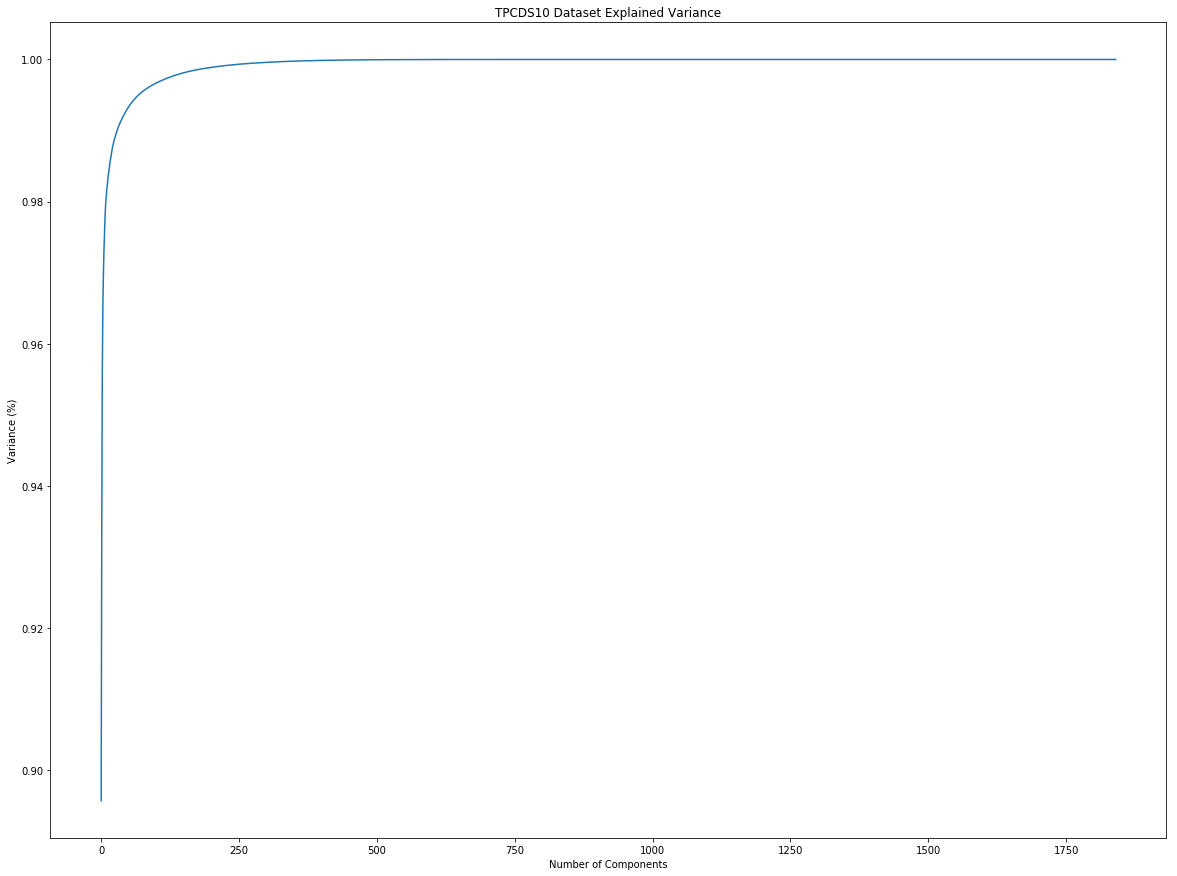

------------------------------
   Component_0  Component_1  Component_2  Component_3  Component_4  \
0    17.236485     3.689500     0.501914     2.681753     1.599894   
1    17.234544     3.683760     0.399543     2.700855     1.439371   
2    17.235142     3.686785     0.721263     2.708240     1.584198   
3    17.233460     3.698846     1.098681     2.708976     1.819206   
4    17.231779     3.704306     1.268417     2.711877     1.960028   

   Component_5  Component_6  Component_7  Component_8  Component_9  \
0     0.667968     0.445638    -0.303959     0.002915     0.389675   
1     0.629082     0.607645    -0.256644    -0.157074     0.525125   
2     0.745305     0.279398    -0.359644    -0.042817     0.402912   
3     0.847625    -0.087275    -0.452240     0.171266     0.575679   
4     0.908412    -0.289206    -0.508445     0.270925     0.674732   

       ...       Component_19  Component_20  Component_21  Component_22  \
0      ...           0.198710      0.638082      0.3

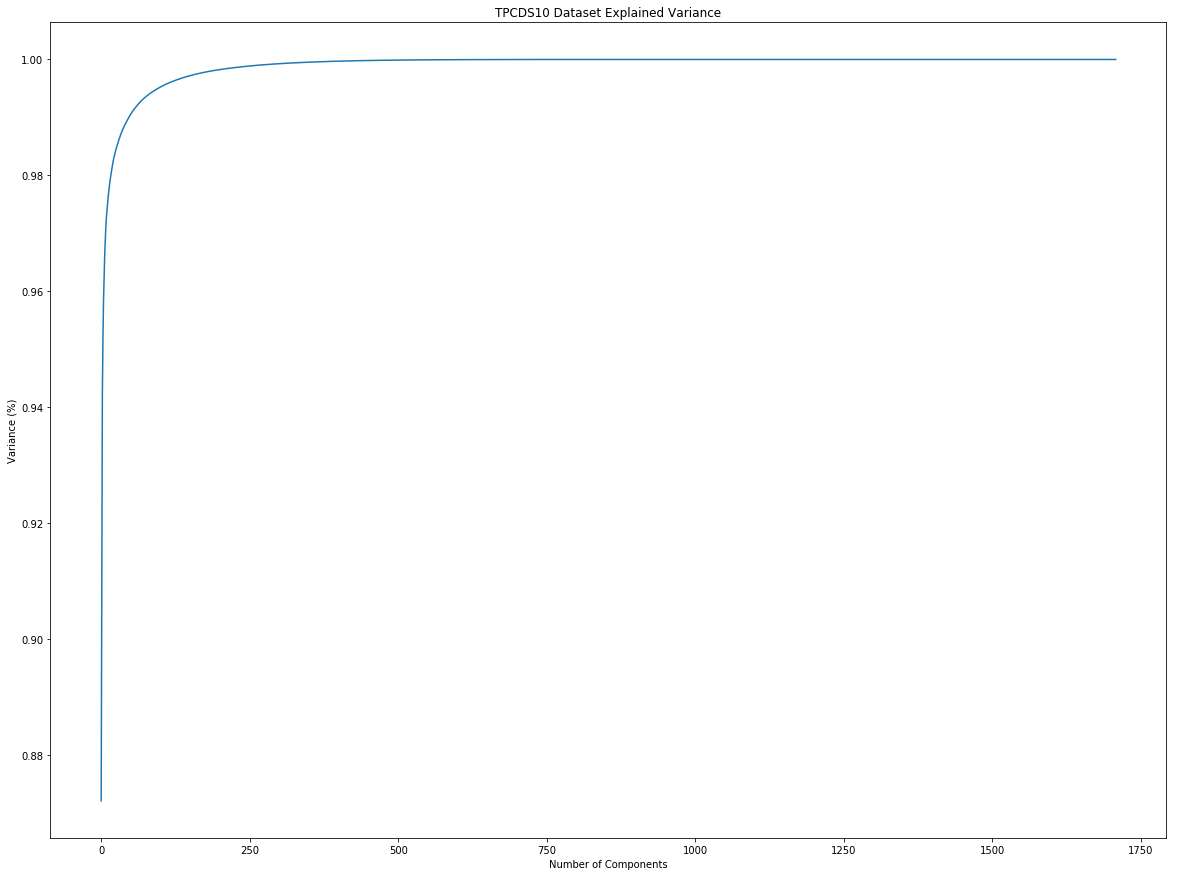

------------------------------
   Component_0  Component_1  Component_2  Component_3  Component_4  \
0    15.363952     3.234479     0.507243     2.384773     1.786828   
1    15.361151     3.248544     0.733806     2.406978     1.847437   
2    15.361187     3.247728     0.831243     2.424899     1.841284   
3    15.360635     3.245737     0.796286     2.425320     1.849178   
4    15.360488     3.263298     1.067591     2.428383     2.117871   

   Component_5  Component_6  Component_7  Component_8  Component_9  \
0    -0.163542     0.640342    -0.469715     0.179367    -0.382612   
1    -0.211648     0.591234    -0.464006     0.122102    -0.909720   
2    -0.243697     0.608228    -0.446695     0.088136    -0.545194   
3    -0.279733     0.582209    -0.490992     0.065579    -0.118248   
4    -0.508921     0.391906    -0.436411     0.157978    -0.353525   

       ...       Component_37  Component_38  Component_39  Component_40  \
0      ...           0.360208     -0.482478     -0.1

In [52]:
class PrincipalComponentAnalysisClass:
    """
    This class handles logic related to PCA data transformations.
    https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
    """
    def __init__(self, X_df):
        """
        Cosntructor method.
        :param X_df: (Pandas) Dataframe consisting of input features, which will be subject to PCA.
        :return: None
        """
        self.__X_df = X_df
        
    def get_default_component_variances(self):
        """
        Fitting the PCA algorithm with our Data.
        :return: (Numpy array) Array of feature variances.
        """
        pca = PCA().fit(self.__X_df.values)
        return np.cumsum(pca.explained_variance_ratio_)
        
    def get_default_component_count(self, threshold=.99):
        """
        Retrieves the recommended number of component decomposition, above which very little variance 
        gain is achieved. This treshold will be set at a 0.999 variance threshold.
        :param threshold: (Float) Threshold value between 0 and 1. Stops immediately as soon the number
                                  of required components exceeds the threshold value.
        :return: (Integer) Returns the number of recommended components.
        """
        variance_ratios = self.get_default_component_variances()
        n = 0
        for val in variance_ratios:
            if val < threshold:
                n += 1
        return n
    
    def plot_variance_per_reduction(self):
        """
        This method subjects the feature matrix to a PCA decomposition. The number of components is plot
        vs the amount of retained variance.
        :return: None
        """
        variance_ratios = self.get_default_component_variances()
        
        #Plotting the Cumulative Summation of the Explained Variance
        plt.figure()
        plt.plot(variance_ratios)
        plt.xlabel('Number of Components')
        plt.ylabel('Variance (%)') #for each component
        plt.title(tpcds + ' Dataset Explained Variance')
        plt.show()
        
    def apply_PCA(self, n_components):
        """
        Applies Principle Component Analysis on the constructor passed data matrix, on a number of components.
        A new pandas data matrix is returned, with renamed 'Principal Component' headers.
        :param n_components: (Integer) Denotes number of component breakdown.
        :return: (Pandas) Dataframe consisting of new decomposed components.
        """
        pca = PCA(n_components=n_components)
        dataset = pca.fit_transform(self.__X_df.values)
        header_list = []
        for i in range(dataset.shape[1]):
            header_list.append('Component_' + str(i))
        return pd.DataFrame(data=dataset, columns=header_list)

print(X_df.head())
print(X_df.shape)

pcac = PrincipalComponentAnalysisClass(X_df=X_df)
pcac.plot_variance_per_reduction()
component_count = pcac.get_default_component_count()
X_df = pcac.apply_PCA(n_components=component_count)

print('-'*30)
print(X_df.head())
print(X_df.shape)

#######################################################################

print(X_df2.head())
print(X_df2.shape)

pcac = PrincipalComponentAnalysisClass(X_df=X_df2)
pcac.plot_variance_per_reduction()
component_count = pcac.get_default_component_count()
X_df2 = pcac.apply_PCA(n_components=component_count)

print('-'*30)
print(X_df2.head())
print(X_df2.shape)

## Random Forest Regression (Many To Many)

Random Forests are an improvement over bagged decision trees.

A problem with decision trees like CART is that they are greedy. They choose which variable to split on using a greedy algorithm that minimizes error. As such, even with Bagging, the decision trees can have a lot of structural similarities and in turn have high correlation in their predictions.

Combining predictions from multiple models in ensembles works better if the predictions from the sub-models are uncorrelated or at best weakly correlated.

Random forest changes the algorithm for the way that the sub-trees are learned so that the resulting predictions from all of the subtrees have less correlation.

https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/

In [53]:
# Random Forest
class RandomForest:
    """
    Random Forest Class (Regression + Classification)
    """

    def __init__(self, n_estimators, max_depth, parallel_degree, y_label, lag, max_features='sqrt'):
        """
        Constructor method for RandomForest wrapper
        :param: n_estimators    - Integer denoting number of decision making forests utilized by inner forests.
        :param: max_depth       - Integer denoting tree purity cut off.
        :param: parallel_degree - Integer denoting model parallel degree.
        :param: y_label         - List columns consisting of labels.
        :param: lag             - Integer denoting lag value.
        :param: max_features    - String denoting the max amount of features to consider.
        :return: None
        """
        self.__y_label = y_label
        self.__lag = lag
        self.__n_estimators = n_estimators
        self.__max_depth = max_depth
        self.__parallel_degree = parallel_degree
        self.__max_features = max_features
        self.__model = RandomForestRegressor(max_depth=self.__max_depth,
                                             n_estimators=self.__n_estimators,
                                             n_jobs=self.__parallel_degree,
                                             max_features=self.__max_features)

    def fit_model(self, X, y):
        """
        This method fits training data to target labels
        :param: X - Numpy array consisting of input feature vectors
        :param: y - Numpy array consisting of output label vectors
        :return: None
        """
        self.__model.fit(X, y)

    def predict(self, X):
        """
        This method predicts the output labels based on the input feature vectors
        :param: X - Numpy array consisting of input feature vectors
        :return: Numpy array consisting of output label vectors
        """
        yhat = self.__model.predict(X)
        return yhat

#     def evaluate(self, y, yhat, plot=False):
#         """
#         Evaluates y vs yhat
#         :param: y    - Numpy array consisting of output label vectors (Test Set)
#         :param: yhat - Numpy array consisting of output label vectors (Prediction Set)
#         :param: plot - Boolean value denoting whether this function should plot out it's evaluation
#         :return: None
#         """
#         if self.__mode == 'regression':

#             # RMSE Evaluation
#             rmse = math.sqrt(mean_squared_error(y, yhat))
#             if not plot:
#                 return rmse
#             print('Test RFR: %.3f\n-----------------------------\n\n' % rmse)

#         elif self.__mode == 'classification':

#             y = BinClass.discretize_value(y, bin_value)
#             yhat = BinClass.discretize_value(yhat, bin_value)
#             y = y.flatten()
#             yhat = yhat.flatten()

#             # Evaluation
#             print(y)
#             print(yhat)
#             accuracy = accuracy_score(y, yhat)
#             f1 = f1_score(y,
#                           yhat,
#                           average='macro')  # Calculate metrics globally by counting the total true positives, false negatives and false positives.
#             print('Accuracy [' + str(accuracy) + ']')
#             print('FScore [' + str(f1) + ']')

#             if not plot:
#                 return accuracy, f1

#         if plot:
#                 plt.rcParams['figure.figsize'] = [20, 15]
#                 plt.plot(y, label='actual')
#                 plt.plot(yhat, label='predicted')
#                 plt.legend(['actual', 'predicted'], loc='upper left')
#                 plt.title('Actual vs Predicted')
#                 plt.show()

    @staticmethod
    def write_results_to_disk(path, iteration, lag, test_split, max_depth, max_features, rmse, accuracy,
                              f_score, time_train):
        """
        Static method which is used for test harness utilities. This method attempts a grid search across many
        trained RandomForest models, each denoted with different configurations.
        Attempted configurations:
        * Varied lag projection
        * Varied data test split
        * Varied forest n_estimators
        Each configuration is denoted with a score, and used to identify the most optimal configuration.

        :param: path         - String denoting path towards result csv output
        :param: iteration    - Integer denoting test iteration (Unique per test configuration)
        :param: lag          - Integer denoting lag value
        :param: test_split   - Float denoting data sample sizes
        :param: max_depth    - Integer denoting max number tree nodes to consider. This param can be 'None'.
        :param: max_features - String denoting amount of feature subset to consider.
        :param: rmse         - (Float) Float denoting experiment configuration RSME score.
        :param: accuracy     - (Float) Float denoting experiment accuracy score.
        :param: fscore       - (Float) Float denoting experiment fscore score.
        :param: time_train   - Integer denoting number of seconds taken by LSTM training iteration
        :return: None
        """
        file_exists = os.path.isfile(path)
        with open(path, 'a') as csvfile:
            headers = ['iteration', 'lag', 'test_split', 'max_depth', 'max_features', 'rmse', 'accuracy', 'f_score', 'time_train']
            writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n', fieldnames=headers)
            if not file_exists:
                writer.writeheader()  # file doesn't exist yet, write a header
            writer.writerow({'iteration': iteration,
                             'lag': lag,
                             'test_split': test_split,
                             'max_depth': max_depth,
                             'max_features': max_features,
                             'rmse': rmse,
                             'accuracy': accuracy,
                             'f_score': f_score,
                             'time_train': time_train})

## Random Forest Training (Week Prior: Day 1 - 7) (CPU)

A random forest model is trained on a week worth of data. Once the model is fit, it will then be used to establish predictions for upcoming days.

In [54]:
%%time
y_labels2 = []
for label in y_df.columns:
    if 'var1' in label:
        y_labels2.append(label)
y_df2 = y_df[y_labels2]
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df2, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))

model = RandomForest(n_estimators=n_estimators, 
                     parallel_degree=parallel_degree,
                     max_depth=max_depth,
                     y_label=y_label,
                     lag=lag,
                     max_features=max_features)

model.fit_model(X=X_train,
               y=y_train)

X_train shape [(5997, 29)] Type - <class 'numpy.ndarray'>
y_train shape [(5997, 12)] Type - <class 'numpy.ndarray'>
X_validate shape [(5998, 29)] Type - <class 'numpy.ndarray'>
y_validate shape [(5998, 12)] Type - <class 'numpy.ndarray'>
Wall time: 7 s


## Random Forest Validation: Day 8 - 14 (CPU)

Evaluating model fit to day 1 forecasts. 

In [55]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for j in range(0, X_validate_temp.shape[0]):
        
        X = X_validate_temp[j,:]
        X = X.reshape(1,-1)
        #X = X.reshape((int(X.shape[0] / lag), lag, X.shape[1]))
        y = np.array(y_validate_temp[j, :])
        yhat = model.predict(X)
        
        y = y.reshape(1,-1)
        model.fit_model(X=X,
                        y=y) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        for z in range(yhat.shape[0]):
#             if i % 2 == 0:
#                 #print('CPU')
#                 y[i] = BinClass.discretize_value(y[i], cpu_avg)
#                 yhat[i] = BinClass.discretize_value(yhat[i], cpu_avg)
#             else:
#                 #print('IO')
#                 y[i] = BinClass.discretize_value(y[i], io_avg)
#                 yhat[i] = BinClass.discretize_value(yhat[i], io_avg)
            y[z] = BinClass.discretize_value(y[z], cpu_avg)
            yhat[z] = BinClass.discretize_value(yhat[z], cpu_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for j in range(len(y_labels2)):
        print('Label: ' + str(j))
        acc = accuracy_score(y_list[:,j],yhat_list[:,j])
        f1 = f1_score(y_list[:,j],yhat_list[:,j], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(j+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)

Day 1
Feature vectors: (856, 29)
Label vectors: (856, 12)
Label: 0
Accuracy: 0.969626168224299
F1Score: 0.9845788849347569
--------------------------
Label: 0
Accuracy: 0.969626168224299
F1Score: 0.9845788849347569
--------------------------
Label: 0
Accuracy: 0.969626168224299
F1Score: 0.9845788849347569
--------------------------
Label: 0
Accuracy: 0.969626168224299
F1Score: 0.9845788849347569
--------------------------
Label: 0
Accuracy: 0.969626168224299
F1Score: 0.9845788849347569
--------------------------
Label: 0
Accuracy: 0.969626168224299
F1Score: 0.9845788849347569
--------------------------
Label: 0
Accuracy: 0.969626168224299
F1Score: 0.9845788849347569
--------------------------
Label: 0
Accuracy: 0.969626168224299
F1Score: 0.9845788849347569
--------------------------
Label: 0
Accuracy: 0.969626168224299
F1Score: 0.9845788849347569
--------------------------
Label: 0
Accuracy: 0.969626168224299
F1Score: 0.9845788849347569
--------------------------
Label: 0
Accuracy: 0.9

## Scoring per day (CPU)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

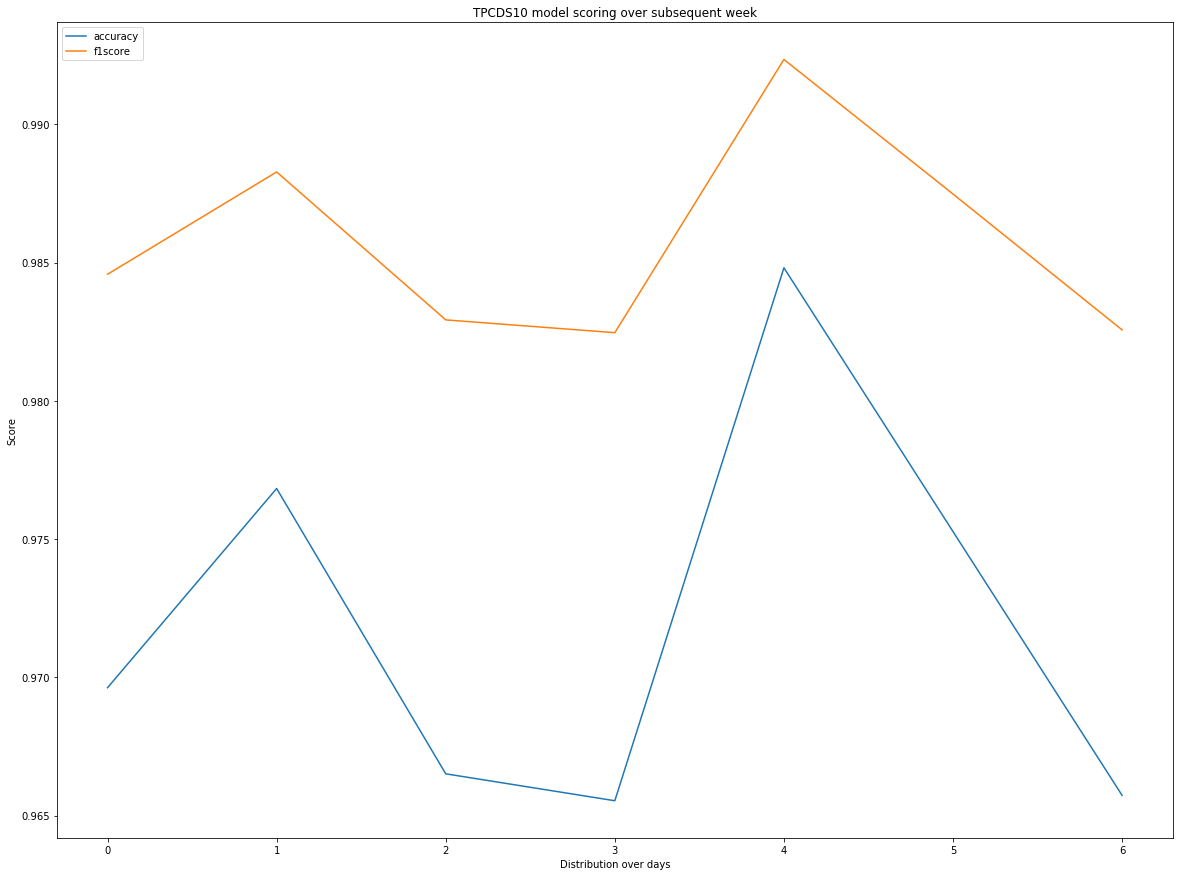

In [56]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()

## Random Forest Training (Week Prior: Day 1 - 7) (IO)

A random forest model is trained on a week worth of data. Once the model is fit, it will then be used to establish predictions for upcoming days.

In [57]:
%%time
y_labels2 = []
for label in y_df.columns:
    if 'var2' in label:
        y_labels2.append(label)
y_df2 = y_df[y_labels2]
X_train, X_validate, y_train, y_validate = train_test_split(X_df2, y_df2, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))

model = RandomForest(n_estimators=n_estimators, 
                     parallel_degree=parallel_degree,
                     max_depth=max_depth,
                     y_label=y_label,
                     lag=lag,
                     max_features=max_features)

model.fit_model(X=X_train,
               y=y_train)

X_train shape [(5997, 47)] Type - <class 'numpy.ndarray'>
y_train shape [(5997, 12)] Type - <class 'numpy.ndarray'>
X_validate shape [(5998, 47)] Type - <class 'numpy.ndarray'>
y_validate shape [(5998, 12)] Type - <class 'numpy.ndarray'>
Wall time: 23.2 s


## Random Forest Validation: Day 8 - 14 (IO)

Evaluating model fit to day 1 forecasts. 

In [58]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for j in range(0, X_validate_temp.shape[0]):
        
        X = X_validate_temp[j,:]
        X = X.reshape(1,-1)
        #X = X.reshape((int(X.shape[0] / lag), lag, X.shape[1]))
        y = np.array(y_validate_temp[j, :])
        yhat = model.predict(X)
        
        y = y.reshape(1,-1)
        model.fit_model(X=X,
                        y=y) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        for z in range(yhat.shape[0]):
#             if i % 2 == 0:
#                 #print('CPU')
#                 y[i] = BinClass.discretize_value(y[i], cpu_avg)
#                 yhat[i] = BinClass.discretize_value(yhat[i], cpu_avg)
#             else:
#                 #print('IO')
#                 y[i] = BinClass.discretize_value(y[i], io_avg)
#                 yhat[i] = BinClass.discretize_value(yhat[i], io_avg)
            #print(y)
            y[z] = BinClass.discretize_value(y[z], io_avg)
            #print(yhat)
            #print(io_avg)
            yhat[z] = BinClass.discretize_value(yhat[z], io_avg)
            #print('************')
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for j in range(len(y_labels2)):
        print('Label: ' + str(j))
        acc = accuracy_score(y_list[:,j],yhat_list[:,j])
        f1 = f1_score(y_list[:,j],yhat_list[:,j], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(j+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)

Day 1
Feature vectors: (856, 47)
Label vectors: (856, 12)
Label: 0
Accuracy: 0.9719626168224299
F1Score: 0.07692307692307693
--------------------------
Label: 1
Accuracy: 0.969626168224299
F1Score: 0.07142857142857142
--------------------------
Label: 2
Accuracy: 0.9672897196261683
F1Score: 0.0
--------------------------
Label: 3
Accuracy: 0.969626168224299
F1Score: 0.07142857142857142
--------------------------
Label: 4
Accuracy: 0.9719626168224299
F1Score: 0.0
--------------------------
Label: 5
Accuracy: 0.9719626168224299
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9789719626168224
F1Score: 0.0
--------------------------
Label: 7
Accuracy: 0.9766355140186916
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9742990654205608
F1Score: 0.0
--------------------------
Label: 9
Accuracy: 0.9742990654205608
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9719626168224299
F1Score: 0.0
--------------------------
Label: 11
Accuracy: 0.976635514018691

## Scoring per day (IO)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

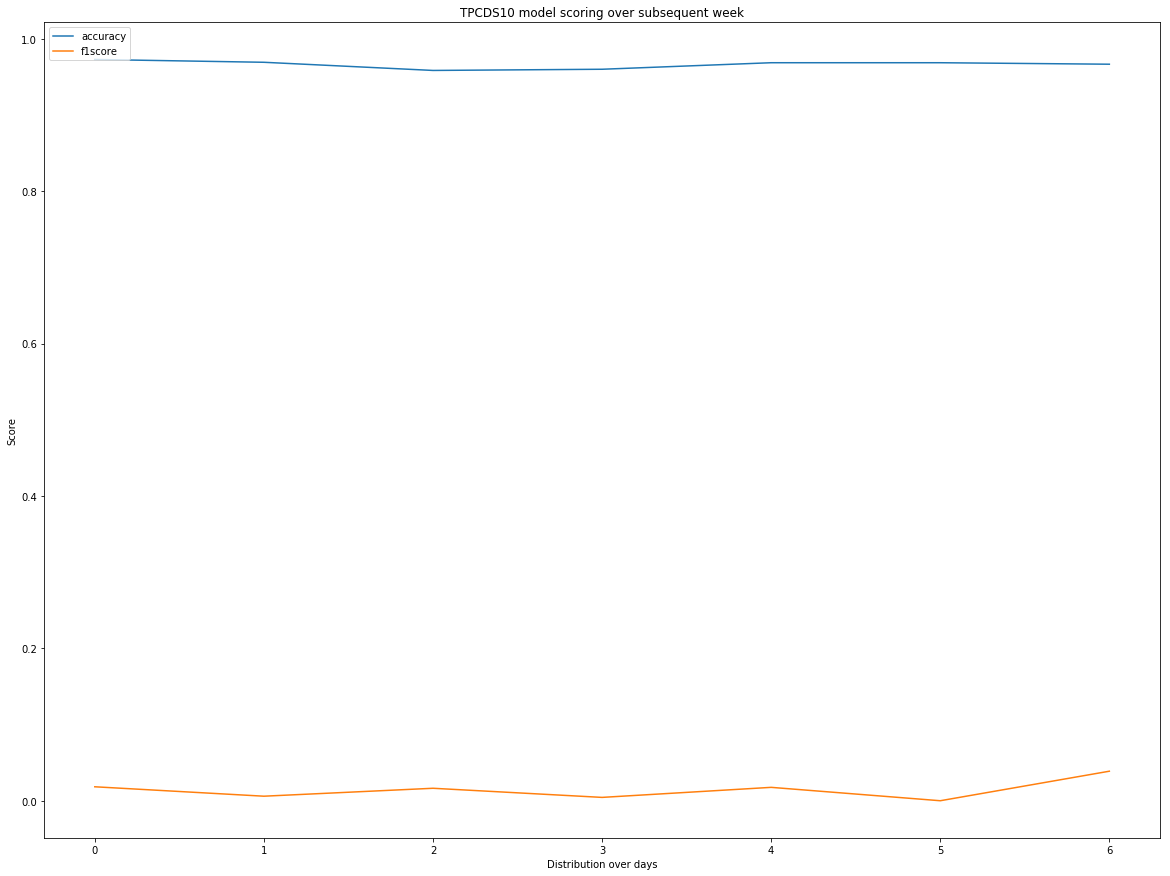

In [59]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()

## Random Forest Training (Week Prior: Day 1 - 7) (CPU + IO)

A random forest model is trained on a week worth of data. Once the model is fit, it will then be used to establish predictions for upcoming days.

In [60]:
%%time
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))

model = RandomForest(n_estimators=n_estimators, 
                     parallel_degree=parallel_degree,
                     max_depth=max_depth,
                     y_label=y_label,
                     lag=lag,
                     max_features=max_features)

model.fit_model(X=X_train,
               y=y_train)

X_train shape [(5997, 29)] Type - <class 'numpy.ndarray'>
y_train shape [(5997, 24)] Type - <class 'numpy.ndarray'>
X_validate shape [(5998, 29)] Type - <class 'numpy.ndarray'>
y_validate shape [(5998, 24)] Type - <class 'numpy.ndarray'>
Wall time: 11.2 s


## Random Forest Validation: Day 8 - 14 (CPU + IO)

Evaluating model fit to day 1 forecasts. 

In [61]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for j in range(0, X_validate_temp.shape[0]):
        
        X = X_validate_temp[j,:]
        X = X.reshape(1,-1)
        #X = X.reshape((int(X.shape[0] / lag), lag, X.shape[1]))
        y = np.array(y_validate_temp[j, :])
        yhat = model.predict(X)
        
        y = y.reshape(1,-1)
        model.fit_model(X=X,
                        y=y) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        for z in range(yhat.shape[0]):
            if z % 2 == 0:
                #print('CPU')
                y[z] = BinClass.discretize_value(y[z], cpu_avg)
                yhat[z] = BinClass.discretize_value(yhat[z], cpu_avg)
            else:
                #print('IO')
                y[z] = BinClass.discretize_value(y[z], io_avg)
                yhat[z] = BinClass.discretize_value(yhat[z], io_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for j in range(lag * len(y_label)):
        print('Label: ' + str(j))
        acc = accuracy_score(y_list[:,j],yhat_list[:,j])
        f1 = f1_score(y_list[:,j],yhat_list[:,j], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(j+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)

Day 1
Feature vectors: (856, 29)
Label vectors: (856, 24)
Label: 0
Accuracy: 0.9626168224299065
F1Score: 0.9809523809523809
--------------------------
Label: 1
Accuracy: 0.9742990654205608
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9626168224299065
F1Score: 0.9809523809523809
--------------------------
Label: 3
Accuracy: 0.9742990654205608
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9626168224299065
F1Score: 0.9809523809523809
--------------------------
Label: 5
Accuracy: 0.9813084112149533
F1Score: 0.1111111111111111
--------------------------
Label: 6
Accuracy: 0.9626168224299065
F1Score: 0.9809523809523809
--------------------------
Label: 7
Accuracy: 0.9789719626168224
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9626168224299065
F1Score: 0.9809523809523809
--------------------------
Label: 9
Accuracy: 0.9742990654205608
F1Score: 0.08333333333333333
--------------------------
Label: 10
Accuracy: 0.9626168224299065
F1Score: 0.980952

Label: 0
Accuracy: 0.9672897196261683
F1Score: 0.9833729216152018
--------------------------
Label: 1
Accuracy: 0.9789719626168224
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9672897196261683
F1Score: 0.9833729216152018
--------------------------
Label: 3
Accuracy: 0.9649532710280374
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.969626168224299
F1Score: 0.9845788849347569
--------------------------
Label: 5
Accuracy: 0.9672897196261683
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.969626168224299
F1Score: 0.9845788849347569
--------------------------
Label: 7
Accuracy: 0.9719626168224299
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.969626168224299
F1Score: 0.9845788849347569
--------------------------
Label: 9
Accuracy: 0.9813084112149533
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.969626168224299
F1Score: 0.9845788849347569
--------------------------
Label: 11
Accuracy: 0.9789719626168224
F1Score: 0.10000

## Scoring per day (CPU + IO)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

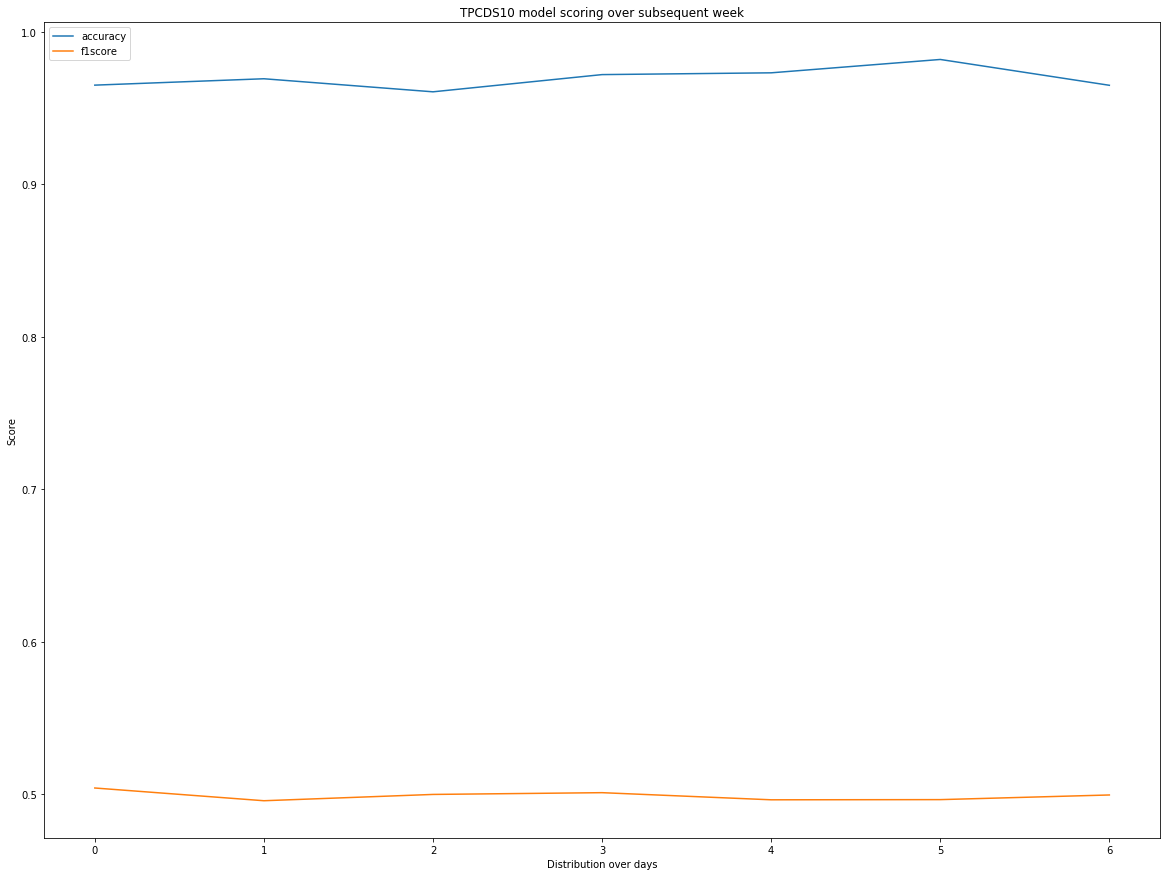

In [62]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()